<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 6th exercise: <font color="#C70039">Work with Autoencoders for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Student: Nicolas Rehbach
* Matriculation Number: 11133387
* Date:   05.11.2022

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float: center;" width="700">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
Autoencoder is an unsupervised artificial neural network (ANN) that learns how to efficiently compress and encode data and then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

An Autoencoder reduces data dimensions by learning how to ignore the noise in the data and thus outliers.
In the section above, you can seen an example of the input/output image from the MNIST dataset to an Autoencoder.

#### Autoencoder Components:
An Autoencoder consists of four main parts:

1. Encoder: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2. Bottleneck: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data. The bottlneck is also called latent vector. The concept of the latent space and latent vectors becomes important later on as we move forward to understand Generative Models. 

3. Decoder: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

4. Reconstruction Loss: This is the method that measures how well the decoder is performing and how close the output is to the original input.

As always in ANNs, the training itself involves back propagation in order to minimize the network’s reconstruction loss.

Due to this features of an Autoencoder the use cases are manyfold. One of the obviously is anomaly detection. 

#### Autoencoder Architecture:

The network architecture for Autoencoders can vary between simple Feed Forward networks, Recurrent Neural Networks (LSTM) or Convolutional Neural Networks (CNN) depending on the use case. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * the example below shows how to use an autoencoder for anomaly detection

4. <font color=green>Develop an Autoencoder for Domain Adaptation (Me -> Walter White ). You can of course also take own data, e.g. a photo of yours and someone else.</font>
5. Set at least the following hyperparameters for training (epochs=100000, shuffle=True).
6. Implement a CNN for working out important features for the adaptation. If you feel lost in the exercise, please visit the sample solution.
7. There is also an implementation of data augmentation that helps you building up your data set from one single "original" image. 
---------------------------------

### Personal understanding: what are Autoencoders: (https://www.youtube.com/watch?v=5WoItGTWV54&t=2s)

- A type of unsupervised learning model
- Not used to generate data but:
- Approach to learn lower dimension feature representation from the training data 
- We want to learn features (z) from our input data (x) by using an encoder, which is a function mapping from input to the features.
    - Encoder could be Linear + nonlinear (sigmoid), deep, fully-connected or ReLU and CNN in our case
- Why dimensionality reduction?
    - z should contain the most important features of x
- How do we learn feature representation?
    - We train a model, such that the features can be used to reconstruct the original data.
    - Input data is mapped by the encoder to a lower dimension feature z.
    - Based on z, the second network (decoder) maps the lower dimension to the same size dimensionality as x.
- L2 loss function: the pixel of the input data should be the same as the pixels of the output data.
    - Loss function does not use labels, only training data
- Our decoder is Generative, as long as we provide a latent vector

### Auto-Encoding
If you have correlated input data, the auto-encoder method will work very well because the encoding operation relies on the correlated features to compress the data.
Let’s consider that an auto-encoder is trained on the MNIST dataset. 
As you know already, using a simple FeedForward neural network, this can be done by building a simple 6 layers network as below:

In [1]:
#pip install numpy --upgrade

In [2]:
from matplotlib import pyplot as plt #Plotting
import numpy as np #numeric stuff
import cv2 #opencv a python computer vision library
import tensorflow as tf #tensorflow for building the ANNs
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img #transfer the image data into a np array?
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Input, Flatten #Import Layers
from tensorflow.keras.models import Sequential, Model #Import Sequential to stack layers?
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from   keras.datasets import mnist
from   keras.models import Sequential, Model
from   keras.layers import Dense, Input, Flatten
from   keras import optimizers
from   keras.optimizers import Adam
from   keras.preprocessing import image

import os
from tqdm import tqdm #a progress bar
import time

In [3]:
# load the inbuild mnist data set (8bit grayscale digits)
# https://en.wikipedia.org/wiki/MNIST_database
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize the training and the validation data set
train_x = x_train.reshape(60000, 784) / 255
val_x = x_test.reshape(10000, 784) / 255

# build the auto-encoding layers
# We define the autoencoder as Sequential 
# Dense = fully connected
# (a stack of layers where each layer has exactly one input tensor and one output tensor.)
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,   activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(784,  activation='sigmoid'))
# after adding our layers, we use compile to configure the model for training
# the MSE is the loss function and Adam the optimizer (stochastic gradient descent method)
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

'''
NOTE:
-----
The Exponential Linear Unit (ELU) is an activation function for neural networks. 
In contrast to ReLUs (which you know), ELUs have negative values which allows them to push mean unit 
activations closer to zero like batch normalization but with lower computational complexity.
'''    

# train the model and finally assign the encoding to the decoder
'''
NOTE:
-----
make sure you understand, that you are training on train_x and not on train_y but train_x again for the reconstruction
the same for the validation (val_x, val_x)
'''
# our output should be the same as the input, therefore we train on x, x
# batch size = the amount of data propagated through the network per epoch
trained_model = autoencoder.fit(train_x, train_x, batch_size=1024, epochs=1, verbose=1, validation_data=(val_x, val_x))
# we define our encoder as a new model which gets the autoencoders input 
# and the bottleneck layer
# Bottleneck layer = a layer with fewer nodes compared to the previous ones
# therefore our representation of the input with reduced dimensionality
# here the actual encoding model is defined
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

# we define our lower feature representation as encoded_data of train_x
encoded_data = encoder.predict(train_x)  # bottleneck representation

# now we are reconstructing the images
decoded_output = autoencoder.predict(train_x)        # reconstruction
encoding_dim = 10

# return the decoder
# our decoder model consists of the final layers of the autoencoder?
# the input are first the encoding dimension (10) before feeding the 
# decoder data in the following layers. The final Model consists of the 
# encoded input and the decoders output
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

Metal device set to: Apple M1


2023-01-14 19:58:14.201890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-14 19:58:14.201976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-01-14 19:58:14.444378: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-14 19:58:14.642011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 2s 35ms/step - loss: 0.0761 - val_loss: 0.0505


2023-01-14 19:58:16.623447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  66/1875 [>.............................] - ETA: 4s

2023-01-14 19:58:16.938155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  34/1875 [..............................] - ETA: 8s

2023-01-14 19:58:21.841056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 8s 4ms/step


As you can see in the output, the last reconstruction loss/error for the validation set is approx. 0.0197, which is great. 
Now, if we pass any normal image from the MNIST dataset, the reconstruction loss will be very low (< 0.02) BUT if we tried to pass any other different image (outlier / anomaly), we will get a high reconstruction loss value because the network failed to reconstruct the image/input that is considered an anomaly.

Notice in the code above, you can use only the encoder part to compress some data or images and you can also only use the decoder part to decompress the data by loading the decoder layers.

#### Auto-Encoders for Anomaly Detection
Now, let’s do some anomaly detection. The code below uses two different images to predict the anomaly score (reconstruction error) using the autoencoder network we trained above. 

The first image is from the MNIST and the result is error=2.46241018. This means that the image is not an anomaly. The second image (yoda.png) obviously does not belong to the training dataset and the result is: error=2727.0718. This high error means that the image is an anomaly. Even the third image. The same concept applies to any type of dataset.

In [4]:
from keras.preprocessing import image

# take an image from the validation data set or the training data set, respectively
# we are using image 50. Flattening the data to 1 image with 28x28 pixels
input_img = val_x[50] 
input_img_flat = input_img.reshape(1,784)

target_data = autoencoder.predict(input_img_flat)

dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 48ms/step
[5.85025118]


2023-01-14 19:58:30.734529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [5]:
# Now take Master Yoda as the test image. The error score will be very high (error=2727.0718)

# load Yoda, same size and greyscale coloring
img = tf.keras.utils.load_img("./data/yoda.png", target_size=(28, 28), color_mode = "grayscale")
input_img = tf.keras.utils.img_to_array(img)

input_img_flat = input_img.reshape(1,784)
#target_data = autoencoder.predict(input_img_flat)
#dist = np.linalg.norm(input_img_flat - target_data, axis=-1)
#print(dist)

In [6]:
''' 
Now take a Mnist image which is taken from the google image search and although it is super similar to the training data
it does not belong to the same data distribution the auto-encoder was trained on. 
It produces an error almost as high as yoda.png (error=2551.99)
This makes autoencoders being a very robust technique for anomaly detection.
'''

img = tf.keras.utils.load_img("./data/similarMnistNumber.jpg", target_size=(28, 28), color_mode = "grayscale")
input_img = tf.keras.utils.img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 12ms/step
[2553.5518]


Summarizing why the autoencoder is robust:

When we reconstruct from our training data, the error is fairly low (2.54). We can therefore ensure, that the data is from our input data. However, Yoda or just a similar MNIST number which is not in the training does give an high error, since the lower dimension representations learned to not interwine with the new images.

# General Autoencoder: Yoda to Michaelangelo

# Add more samples

In [ ]:
#Create an datagenerator to rotate training pictures

#datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=90) 
datagenerator = ImageDataGenerator(
                    rotation_range=90,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=45.0,
                    height_shift_range=45.0) 

#specify folder, change into the right one with chdir otherwise there were problems
img_folder = '/Users/nicolasrehbach/Documents/GitHub/AML_privaterepo/data/ex6.1'
os.chdir(img_folder)
image_names = os.listdir(img_folder)

#loop through the data, reshape the images and create new ones

#remove comment on for to create augmented data

#for filename in image_names:
    print(filename)
    img = tf.keras.utils.load_img(filename)  
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0
    n = 50
    # generate n new augmented images 
    for batch in datagenerator.flow(x, batch_size = 1, save_to_dir = img_folder, save_format ='jpeg'):
        i += 1
        if i > n: 
            break

In [7]:
def preprocess_img(size, input_path, output_path, test_path):
    SIZE = size

#import the input images
    input_img_data = []
    input_path = input_path
    files = os.listdir(input_path)
    
    for i in tqdm(files):
        if(i != ".DS_Store"):
            img=cv2.imread(input_path+'/'+i,1)   #Change 0 to 1 for color images
            img=cv2.resize(img,(SIZE, SIZE))
            input_img_data.append(img_to_array(img))
        
        
    output_img_data = []
    output_path = output_path
    files = os.listdir(output_path)
    
    for i in tqdm(files):
        if(i != ".DS_Store"):
            img = cv2.imread(output_path+'/'+i,1)
            img = cv2.resize(img, (SIZE, SIZE))
            output_img_data.append(img_to_array(img))
            
    #reshape the images and normalize
    # we create an array of: input data length (50, since we created them previously, 256x256, 3)
    # 3 used for RGB
    input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 3))
    # our input image is defined as float and divided through 255. Now each image has its unique 
    # converting every pixel to float and dividing every pixel trough 255 (normalize each pixel) 
    input_img_array = input_img_array.astype('float32')/255

    output_img_array = np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 3))
    output_img_array = output_img_array.astype('float32')/255
    
    #take an image that does not belong to the training set
    test_img_data = []
    test_img = cv2.imread(test_path,1)
    test_img = cv2.resize(test_img, (SIZE, SIZE))
    test_img_data.append(img_to_array(test_img))

    test_img_array = np.reshape(test_img_data, (len(test_img_data), SIZE, SIZE, 3))
    test_img_array = test_img_array.astype('float32')/255

    start = time.time()
    
    return(size, input_img_array, output_img_array, test_img_array, start)

In [8]:
SIZE, input_img_array, output_img_array, test_img_array, start = preprocess_img(128, './data/ex6.1/yoda/', './data/ex6.1/michael/', './data/ex6.1/yoda.png')



100%|█████████████████████████████████████████| 52/52 [00:00<00:00, 1954.07it/s]


In [9]:
train_y = output_img_array
val_y = output_img_array

train_x = input_img_array
val_x = input_img_array
#x_train = tf.keras.utils.load_img("./data/ex6.1/yoda.png", target_size=(SIZE, SIZE, 3), color_mode = "grayscale")

#input_x_train = tf.keras.utils.img_to_array(x_train)

In [10]:
train_x[0].size

49152

In [11]:
train_x = train_x.reshape(51, 49152)
val_x = train_x.reshape(51, 49152)

train_y = train_y.reshape(51, 49152)
val_y = train_y.reshape(51, 49152)

In [12]:
train_x[0].size

49152

In [13]:
train_x_resize = train_x[0].reshape(128,128,3)

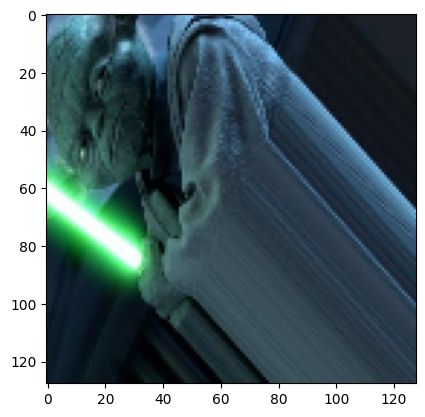

In [14]:
plt.imshow(train_x_resize, cmap = "gray")

In [15]:
train_x[4].shape

(49152,)

Design a Autoencoder to reduce the dimensionality of the input data from input 49152 to 16 dimensions, and then reconstruct the original input data from the bottleneck representation.

In [16]:
#Encoder Network
autoencoder = Sequential()

autoencoder.add(Dense(1024,  activation='elu', input_shape=(49152,)))
autoencoder.add(Dense(256,  activation='elu'))
autoencoder.add(Dense(64,  activation='elu'))

autoencoder.add(Dense(16,   activation='linear', name="bottleneck"))

autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(256,  activation='elu'))
autoencoder.add(Dense(49152,  activation='sigmoid'))

autoencoder.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['accuracy'])

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              50332672  
                                                                 
 dense_6 (Dense)             (None, 256)               262400    
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 bottleneck (Dense)          (None, 16)                1040      
                                                                 
 dense_8 (Dense)             (None, 64)                1088      
                                                                 
 dense_9 (Dense)             (None, 256)               16640     
                                                                 
 dense_10 (Dense)            (None, 49152)            

In [17]:
trained_model = autoencoder.fit(train_x, train_y, batch_size=1024, epochs= 10_000, verbose=1, validation_data=(val_x, val_y))

encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)


Epoch 1/10000


2023-01-14 19:58:34.601678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 727ms/step - loss: 0.0739 - accuracy: 0.0000e+00 - val_loss: 0.0779 - val_accuracy: 0.0000e+00
Epoch 2/10000


2023-01-14 19:58:34.927122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 180ms/step - loss: 0.0779 - accuracy: 0.0000e+00 - val_loss: 0.0715 - val_accuracy: 0.0000e+00
Epoch 3/10000
1/1 [==============================] - 0s 175ms/step - loss: 0.0715 - accuracy: 0.0000e+00 - val_loss: 0.0496 - val_accuracy: 0.0000e+00
Epoch 4/10000
1/1 [==============================] - 0s 178ms/step - loss: 0.0496 - accuracy: 0.0000e+00 - val_loss: 0.0326 - val_accuracy: 0.0000e+00
Epoch 5/10000
1/1 [==============================] - 0s 169ms/step - loss: 0.0326 - accuracy: 0.0000e+00 - val_loss: 0.0292 - val_accuracy: 0.0000e+00
Epoch 6/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0292 - accuracy: 0.0000e+00 - val_loss: 0.0207 - val_accuracy: 0.0000e+00
Epoch 7/10000
1/1 [==============================] - 0s 166ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - val_loss: 0.0218 - val_accuracy: 0.0000e+00
Epoch 8/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0218 - accuracy: 0.0000e+00 - v

1/1 [==============================] - 0s 167ms/step - loss: 0.0170 - accuracy: 0.0000e+00 - val_loss: 0.0169 - val_accuracy: 0.0000e+00
Epoch 57/10000
1/1 [==============================] - 0s 168ms/step - loss: 0.0169 - accuracy: 0.0000e+00 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 58/10000
1/1 [==============================] - 0s 170ms/step - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 59/10000
1/1 [==============================] - 0s 166ms/step - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.0167 - val_accuracy: 0.0000e+00
Epoch 60/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0167 - accuracy: 0.0000e+00 - val_loss: 0.0166 - val_accuracy: 0.0000e+00
Epoch 61/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.0166 - accuracy: 0.0000e+00 - val_loss: 0.0165 - val_accuracy: 0.0000e+00
Epoch 62/10000
1/1 [==============================] - 0s 166ms/step - loss: 0.0165 - accuracy: 0.0000e+

Epoch 110/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0122 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 111/10000
1/1 [==============================] - 0s 166ms/step - loss: 0.0121 - accuracy: 0.0000e+00 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 112/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0120 - accuracy: 0.0000e+00 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 113/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.0119 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 114/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0118 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 115/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0118 - accuracy: 0.0000e+00 - val_loss: 0.0117 - val_accuracy: 0.0000e+00
Epoch 116/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.011

1/1 [==============================] - 0s 165ms/step - loss: 0.0030 - accuracy: 0.0196 - val_loss: 0.0030 - val_accuracy: 0.0196
Epoch 219/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0030 - accuracy: 0.0196 - val_loss: 0.0029 - val_accuracy: 0.0196
Epoch 220/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.0029 - accuracy: 0.0196 - val_loss: 0.0028 - val_accuracy: 0.0196
Epoch 221/10000
1/1 [==============================] - 0s 166ms/step - loss: 0.0028 - accuracy: 0.0196 - val_loss: 0.0028 - val_accuracy: 0.0196
Epoch 222/10000
1/1 [==============================] - 0s 166ms/step - loss: 0.0028 - accuracy: 0.0196 - val_loss: 0.0027 - val_accuracy: 0.0196
Epoch 223/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0027 - accuracy: 0.0196 - val_loss: 0.0027 - val_accuracy: 0.0196
Epoch 224/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0027 - accuracy: 0.0196 - val_loss: 0.0026 - val_accuracy: 0.0196
E

Epoch 274/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.3581e-04 - accuracy: 0.0392 - val_loss: 9.0043e-04 - val_accuracy: 0.0392
Epoch 275/10000
1/1 [==============================] - 0s 172ms/step - loss: 9.0043e-04 - accuracy: 0.0392 - val_loss: 8.6250e-04 - val_accuracy: 0.0392
Epoch 276/10000
1/1 [==============================] - 0s 164ms/step - loss: 8.6250e-04 - accuracy: 0.0392 - val_loss: 8.5639e-04 - val_accuracy: 0.0392
Epoch 277/10000
1/1 [==============================] - 0s 164ms/step - loss: 8.5639e-04 - accuracy: 0.0392 - val_loss: 8.3051e-04 - val_accuracy: 0.0392
Epoch 278/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.3051e-04 - accuracy: 0.0392 - val_loss: 7.9356e-04 - val_accuracy: 0.0392
Epoch 279/10000
1/1 [==============================] - 0s 166ms/step - loss: 7.9356e-04 - accuracy: 0.0392 - val_loss: 7.8430e-04 - val_accuracy: 0.0392
Epoch 280/10000
1/1 [==============================] - 0s 166ms/step - loss: 7.843

Epoch 328/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.5047e-04 - accuracy: 0.0588 - val_loss: 2.2595e-04 - val_accuracy: 0.0588
Epoch 329/10000
1/1 [==============================] - 0s 167ms/step - loss: 2.2595e-04 - accuracy: 0.0588 - val_loss: 2.3132e-04 - val_accuracy: 0.0588
Epoch 330/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.3132e-04 - accuracy: 0.0588 - val_loss: 2.1485e-04 - val_accuracy: 0.0588
Epoch 331/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.1485e-04 - accuracy: 0.0588 - val_loss: 2.1509e-04 - val_accuracy: 0.0588
Epoch 332/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.1509e-04 - accuracy: 0.0588 - val_loss: 2.0356e-04 - val_accuracy: 0.0588
Epoch 333/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.0356e-04 - accuracy: 0.0588 - val_loss: 2.0032e-04 - val_accuracy: 0.0588
Epoch 334/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.003

1/1 [==============================] - 0s 170ms/step - loss: 7.5741e-05 - accuracy: 0.0588 - val_loss: 1.3182e-04 - val_accuracy: 0.0784
Epoch 435/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.3182e-04 - accuracy: 0.0784 - val_loss: 2.3254e-04 - val_accuracy: 0.0784
Epoch 436/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.3254e-04 - accuracy: 0.0784 - val_loss: 4.1863e-04 - val_accuracy: 0.0784
Epoch 437/10000
1/1 [==============================] - 0s 173ms/step - loss: 4.1863e-04 - accuracy: 0.0784 - val_loss: 6.6974e-04 - val_accuracy: 0.0980
Epoch 438/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.6974e-04 - accuracy: 0.0980 - val_loss: 7.8608e-04 - val_accuracy: 0.0784
Epoch 439/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.8608e-04 - accuracy: 0.0784 - val_loss: 5.2295e-04 - val_accuracy: 0.1176
Epoch 440/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.2295e-04 - accuracy

1/1 [==============================] - 0s 169ms/step - loss: 1.1658e-05 - accuracy: 0.1961 - val_loss: 1.1566e-05 - val_accuracy: 0.1961
Epoch 541/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.1566e-05 - accuracy: 0.1961 - val_loss: 1.1470e-05 - val_accuracy: 0.1961
Epoch 542/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.1470e-05 - accuracy: 0.1961 - val_loss: 1.1365e-05 - val_accuracy: 0.1961
Epoch 543/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1365e-05 - accuracy: 0.1961 - val_loss: 1.1279e-05 - val_accuracy: 0.1961
Epoch 544/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.1279e-05 - accuracy: 0.1961 - val_loss: 1.1178e-05 - val_accuracy: 0.1961
Epoch 545/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.1178e-05 - accuracy: 0.1961 - val_loss: 1.1088e-05 - val_accuracy: 0.1961
Epoch 546/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1088e-05 - accuracy

1/1 [==============================] - 0s 165ms/step - loss: 9.7150e-05 - accuracy: 0.1569 - val_loss: 9.6595e-05 - val_accuracy: 0.1569
Epoch 648/10000
1/1 [==============================] - 0s 166ms/step - loss: 9.6595e-05 - accuracy: 0.1569 - val_loss: 8.4416e-05 - val_accuracy: 0.1765
Epoch 649/10000
1/1 [==============================] - 0s 166ms/step - loss: 8.4416e-05 - accuracy: 0.1765 - val_loss: 7.9667e-05 - val_accuracy: 0.1765
Epoch 650/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.9667e-05 - accuracy: 0.1765 - val_loss: 7.8450e-05 - val_accuracy: 0.1569
Epoch 651/10000
1/1 [==============================] - 0s 166ms/step - loss: 7.8450e-05 - accuracy: 0.1569 - val_loss: 6.9516e-05 - val_accuracy: 0.1765
Epoch 652/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.9516e-05 - accuracy: 0.1765 - val_loss: 6.4923e-05 - val_accuracy: 0.1765
Epoch 653/10000
1/1 [==============================] - 0s 164ms/step - loss: 6.4923e-05 - accuracy

1/1 [==============================] - 0s 166ms/step - loss: 7.3979e-06 - accuracy: 0.1765 - val_loss: 7.3382e-06 - val_accuracy: 0.1765
Epoch 754/10000
1/1 [==============================] - 0s 171ms/step - loss: 7.3382e-06 - accuracy: 0.1765 - val_loss: 7.2795e-06 - val_accuracy: 0.1765
Epoch 755/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.2795e-06 - accuracy: 0.1765 - val_loss: 7.2218e-06 - val_accuracy: 0.1765
Epoch 756/10000
1/1 [==============================] - 0s 163ms/step - loss: 7.2218e-06 - accuracy: 0.1765 - val_loss: 7.1647e-06 - val_accuracy: 0.1765
Epoch 757/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.1647e-06 - accuracy: 0.1765 - val_loss: 7.1085e-06 - val_accuracy: 0.1765
Epoch 758/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.1085e-06 - accuracy: 0.1765 - val_loss: 7.0533e-06 - val_accuracy: 0.1765
Epoch 759/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.0533e-06 - accuracy

1/1 [==============================] - 0s 165ms/step - loss: 3.8101e-06 - accuracy: 0.1569 - val_loss: 3.7908e-06 - val_accuracy: 0.1569
Epoch 860/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.7908e-06 - accuracy: 0.1569 - val_loss: 3.7718e-06 - val_accuracy: 0.1765
Epoch 861/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.7718e-06 - accuracy: 0.1765 - val_loss: 3.7528e-06 - val_accuracy: 0.1765
Epoch 862/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.7528e-06 - accuracy: 0.1765 - val_loss: 3.7341e-06 - val_accuracy: 0.1765
Epoch 863/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.7341e-06 - accuracy: 0.1765 - val_loss: 3.7154e-06 - val_accuracy: 0.1765
Epoch 864/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.7154e-06 - accuracy: 0.1765 - val_loss: 3.6970e-06 - val_accuracy: 0.1765
Epoch 865/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.6970e-06 - accuracy

1/1 [==============================] - 0s 163ms/step - loss: 2.3832e-06 - accuracy: 0.1961 - val_loss: 2.3739e-06 - val_accuracy: 0.1961
Epoch 966/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3739e-06 - accuracy: 0.1961 - val_loss: 2.3647e-06 - val_accuracy: 0.1961
Epoch 967/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.3647e-06 - accuracy: 0.1961 - val_loss: 2.3555e-06 - val_accuracy: 0.1961
Epoch 968/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3555e-06 - accuracy: 0.1961 - val_loss: 2.3464e-06 - val_accuracy: 0.1961
Epoch 969/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3464e-06 - accuracy: 0.1961 - val_loss: 2.3373e-06 - val_accuracy: 0.1961
Epoch 970/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3373e-06 - accuracy: 0.1961 - val_loss: 2.3283e-06 - val_accuracy: 0.1961
Epoch 971/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3283e-06 - accuracy

1/1 [==============================] - 0s 166ms/step - loss: 1.6362e-06 - accuracy: 0.2549 - val_loss: 1.6309e-06 - val_accuracy: 0.2549
Epoch 1072/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.6309e-06 - accuracy: 0.2549 - val_loss: 1.6257e-06 - val_accuracy: 0.2549
Epoch 1073/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.6257e-06 - accuracy: 0.2549 - val_loss: 1.6204e-06 - val_accuracy: 0.2549
Epoch 1074/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.6204e-06 - accuracy: 0.2549 - val_loss: 1.6152e-06 - val_accuracy: 0.2549
Epoch 1075/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6152e-06 - accuracy: 0.2549 - val_loss: 1.6100e-06 - val_accuracy: 0.2549
Epoch 1076/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6100e-06 - accuracy: 0.2549 - val_loss: 1.6049e-06 - val_accuracy: 0.2549
Epoch 1077/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.6049e-06 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.1919e-06 - accuracy: 0.2941 - val_loss: 1.1886e-06 - val_accuracy: 0.2941
Epoch 1178/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1886e-06 - accuracy: 0.2941 - val_loss: 1.1853e-06 - val_accuracy: 0.2941
Epoch 1179/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.1853e-06 - accuracy: 0.2941 - val_loss: 1.1820e-06 - val_accuracy: 0.2941
Epoch 1180/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.1820e-06 - accuracy: 0.2941 - val_loss: 1.1788e-06 - val_accuracy: 0.2941
Epoch 1181/10000
1/1 [==============================] - 0s 169ms/step - loss: 1.1788e-06 - accuracy: 0.2941 - val_loss: 1.1755e-06 - val_accuracy: 0.2941
Epoch 1182/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1755e-06 - accuracy: 0.2941 - val_loss: 1.1723e-06 - val_accuracy: 0.2941
Epoch 1183/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.1723e-06 - ac

1/1 [==============================] - 0s 169ms/step - loss: 9.2395e-07 - accuracy: 0.3137 - val_loss: 9.3372e-07 - val_accuracy: 0.3137
Epoch 1284/10000
1/1 [==============================] - 0s 164ms/step - loss: 9.3372e-07 - accuracy: 0.3137 - val_loss: 9.5190e-07 - val_accuracy: 0.3137
Epoch 1285/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.5190e-07 - accuracy: 0.3137 - val_loss: 9.8464e-07 - val_accuracy: 0.3137
Epoch 1286/10000
1/1 [==============================] - 0s 163ms/step - loss: 9.8464e-07 - accuracy: 0.3137 - val_loss: 1.0429e-06 - val_accuracy: 0.3137
Epoch 1287/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.0429e-06 - accuracy: 0.3137 - val_loss: 1.1458e-06 - val_accuracy: 0.3137
Epoch 1288/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.1458e-06 - accuracy: 0.3137 - val_loss: 1.3283e-06 - val_accuracy: 0.3137
Epoch 1289/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.3283e-06 - ac

1/1 [==============================] - 0s 165ms/step - loss: 9.3979e-07 - accuracy: 0.3137 - val_loss: 9.2347e-07 - val_accuracy: 0.3137
Epoch 1390/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.2347e-07 - accuracy: 0.3137 - val_loss: 9.3257e-07 - val_accuracy: 0.3333
Epoch 1391/10000
1/1 [==============================] - 0s 163ms/step - loss: 9.3257e-07 - accuracy: 0.3333 - val_loss: 9.0904e-07 - val_accuracy: 0.3137
Epoch 1392/10000
1/1 [==============================] - 0s 164ms/step - loss: 9.0904e-07 - accuracy: 0.3137 - val_loss: 9.2306e-07 - val_accuracy: 0.3137
Epoch 1393/10000
1/1 [==============================] - 0s 164ms/step - loss: 9.2306e-07 - accuracy: 0.3137 - val_loss: 8.9939e-07 - val_accuracy: 0.3137
Epoch 1394/10000
1/1 [==============================] - 0s 164ms/step - loss: 8.9939e-07 - accuracy: 0.3137 - val_loss: 9.0902e-07 - val_accuracy: 0.3333
Epoch 1395/10000
1/1 [==============================] - 0s 166ms/step - loss: 9.0902e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 6.6277e-07 - accuracy: 0.3137 - val_loss: 6.6119e-07 - val_accuracy: 0.3137
Epoch 1496/10000
1/1 [==============================] - 0s 164ms/step - loss: 6.6119e-07 - accuracy: 0.3137 - val_loss: 6.5962e-07 - val_accuracy: 0.3137
Epoch 1497/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.5962e-07 - accuracy: 0.3137 - val_loss: 6.5806e-07 - val_accuracy: 0.3137
Epoch 1498/10000
1/1 [==============================] - 0s 164ms/step - loss: 6.5806e-07 - accuracy: 0.3137 - val_loss: 6.5650e-07 - val_accuracy: 0.3137
Epoch 1499/10000
1/1 [==============================] - 0s 163ms/step - loss: 6.5650e-07 - accuracy: 0.3137 - val_loss: 6.5495e-07 - val_accuracy: 0.3137
Epoch 1500/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.5495e-07 - accuracy: 0.3137 - val_loss: 6.5341e-07 - val_accuracy: 0.3137
Epoch 1501/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.5341e-07 - ac

1/1 [==============================] - 0s 169ms/step - loss: 5.2717e-07 - accuracy: 0.3333 - val_loss: 5.2613e-07 - val_accuracy: 0.3333
Epoch 1602/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.2613e-07 - accuracy: 0.3333 - val_loss: 5.2509e-07 - val_accuracy: 0.3333
Epoch 1603/10000
1/1 [==============================] - 0s 172ms/step - loss: 5.2509e-07 - accuracy: 0.3333 - val_loss: 5.2405e-07 - val_accuracy: 0.3333
Epoch 1604/10000
1/1 [==============================] - 0s 167ms/step - loss: 5.2405e-07 - accuracy: 0.3333 - val_loss: 5.2302e-07 - val_accuracy: 0.3333
Epoch 1605/10000
1/1 [==============================] - 0s 169ms/step - loss: 5.2302e-07 - accuracy: 0.3333 - val_loss: 5.2199e-07 - val_accuracy: 0.3333
Epoch 1606/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.2199e-07 - accuracy: 0.3333 - val_loss: 5.2096e-07 - val_accuracy: 0.3333
Epoch 1607/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.2096e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 2.9712e-05 - accuracy: 0.2941 - val_loss: 4.9925e-05 - val_accuracy: 0.4118
Epoch 1708/10000
1/1 [==============================] - 0s 163ms/step - loss: 4.9925e-05 - accuracy: 0.4118 - val_loss: 8.5247e-05 - val_accuracy: 0.3137
Epoch 1709/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.5247e-05 - accuracy: 0.3137 - val_loss: 1.3638e-04 - val_accuracy: 0.3922
Epoch 1710/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.3638e-04 - accuracy: 0.3922 - val_loss: 2.1291e-04 - val_accuracy: 0.2941
Epoch 1711/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.1291e-04 - accuracy: 0.2941 - val_loss: 2.6727e-04 - val_accuracy: 0.3333
Epoch 1712/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.6727e-04 - accuracy: 0.3333 - val_loss: 2.7923e-04 - val_accuracy: 0.2745
Epoch 1713/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.7923e-04 - ac

1/1 [==============================] - 0s 164ms/step - loss: 4.2650e-07 - accuracy: 0.3529 - val_loss: 4.2626e-07 - val_accuracy: 0.3922
Epoch 1814/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.2626e-07 - accuracy: 0.3922 - val_loss: 4.2476e-07 - val_accuracy: 0.3529
Epoch 1815/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.2476e-07 - accuracy: 0.3529 - val_loss: 4.2259e-07 - val_accuracy: 0.3529
Epoch 1816/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.2259e-07 - accuracy: 0.3529 - val_loss: 4.2230e-07 - val_accuracy: 0.3922
Epoch 1817/10000
1/1 [==============================] - 0s 163ms/step - loss: 4.2230e-07 - accuracy: 0.3922 - val_loss: 4.2048e-07 - val_accuracy: 0.3529
Epoch 1818/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.2048e-07 - accuracy: 0.3529 - val_loss: 4.1897e-07 - val_accuracy: 0.3725
Epoch 1819/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.1897e-07 - ac

1/1 [==============================] - 0s 162ms/step - loss: 1.8852e-06 - accuracy: 0.3137 - val_loss: 2.9194e-06 - val_accuracy: 0.4118
Epoch 1920/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.9194e-06 - accuracy: 0.4118 - val_loss: 4.7595e-06 - val_accuracy: 0.2941
Epoch 1921/10000
1/1 [==============================] - 0s 162ms/step - loss: 4.7595e-06 - accuracy: 0.2941 - val_loss: 7.7905e-06 - val_accuracy: 0.4314
Epoch 1922/10000
1/1 [==============================] - 0s 163ms/step - loss: 7.7905e-06 - accuracy: 0.4314 - val_loss: 1.3411e-05 - val_accuracy: 0.2745
Epoch 1923/10000
1/1 [==============================] - 0s 162ms/step - loss: 1.3411e-05 - accuracy: 0.2745 - val_loss: 2.2485e-05 - val_accuracy: 0.4314
Epoch 1924/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.2485e-05 - accuracy: 0.4314 - val_loss: 4.0192e-05 - val_accuracy: 0.2745
Epoch 1925/10000
1/1 [==============================] - 0s 163ms/step - loss: 4.0192e-05 - ac

1/1 [==============================] - 0s 165ms/step - loss: 3.3719e-07 - accuracy: 0.4118 - val_loss: 3.3769e-07 - val_accuracy: 0.4118
Epoch 2026/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.3769e-07 - accuracy: 0.4118 - val_loss: 3.3272e-07 - val_accuracy: 0.4118
Epoch 2027/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.3272e-07 - accuracy: 0.4118 - val_loss: 3.3330e-07 - val_accuracy: 0.4118
Epoch 2028/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.3330e-07 - accuracy: 0.4118 - val_loss: 3.3409e-07 - val_accuracy: 0.4118
Epoch 2029/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.3409e-07 - accuracy: 0.4118 - val_loss: 3.2962e-07 - val_accuracy: 0.4118
Epoch 2030/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.2962e-07 - accuracy: 0.4118 - val_loss: 3.2949e-07 - val_accuracy: 0.4118
Epoch 2031/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.2949e-07 - ac

1/1 [==============================] - 0s 163ms/step - loss: 2.7100e-07 - accuracy: 0.4118 - val_loss: 2.7057e-07 - val_accuracy: 0.4118
Epoch 2132/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.7057e-07 - accuracy: 0.4118 - val_loss: 2.7014e-07 - val_accuracy: 0.4118
Epoch 2133/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.7014e-07 - accuracy: 0.4118 - val_loss: 2.6972e-07 - val_accuracy: 0.4118
Epoch 2134/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.6972e-07 - accuracy: 0.4118 - val_loss: 2.6929e-07 - val_accuracy: 0.4118
Epoch 2135/10000
1/1 [==============================] - 0s 168ms/step - loss: 2.6929e-07 - accuracy: 0.4118 - val_loss: 2.6887e-07 - val_accuracy: 0.4118
Epoch 2136/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.6887e-07 - accuracy: 0.4118 - val_loss: 2.6844e-07 - val_accuracy: 0.4118
Epoch 2137/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.6844e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 2.3210e-07 - accuracy: 0.4118 - val_loss: 2.3178e-07 - val_accuracy: 0.4118
Epoch 2238/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3178e-07 - accuracy: 0.4118 - val_loss: 2.3147e-07 - val_accuracy: 0.4118
Epoch 2239/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.3147e-07 - accuracy: 0.4118 - val_loss: 2.3115e-07 - val_accuracy: 0.4118
Epoch 2240/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3115e-07 - accuracy: 0.4118 - val_loss: 2.3084e-07 - val_accuracy: 0.4118
Epoch 2241/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.3084e-07 - accuracy: 0.4118 - val_loss: 2.3053e-07 - val_accuracy: 0.4118
Epoch 2242/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3053e-07 - accuracy: 0.4118 - val_loss: 2.3021e-07 - val_accuracy: 0.4118
Epoch 2243/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.3021e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 2.7385e-06 - accuracy: 0.4118 - val_loss: 4.5976e-06 - val_accuracy: 0.3725
Epoch 2344/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.5976e-06 - accuracy: 0.3725 - val_loss: 7.7534e-06 - val_accuracy: 0.4118
Epoch 2345/10000
1/1 [==============================] - 0s 166ms/step - loss: 7.7534e-06 - accuracy: 0.4118 - val_loss: 1.3260e-05 - val_accuracy: 0.4118
Epoch 2346/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.3260e-05 - accuracy: 0.4118 - val_loss: 2.2248e-05 - val_accuracy: 0.4706
Epoch 2347/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.2248e-05 - accuracy: 0.4706 - val_loss: 3.7304e-05 - val_accuracy: 0.4314
Epoch 2348/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.7304e-05 - accuracy: 0.4314 - val_loss: 5.9024e-05 - val_accuracy: 0.4314
Epoch 2349/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.9024e-05 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.9548e-07 - accuracy: 0.4118 - val_loss: 1.9374e-07 - val_accuracy: 0.4118
Epoch 2450/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.9374e-07 - accuracy: 0.4118 - val_loss: 1.9474e-07 - val_accuracy: 0.4118
Epoch 2451/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.9474e-07 - accuracy: 0.4118 - val_loss: 1.9513e-07 - val_accuracy: 0.4118
Epoch 2452/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.9513e-07 - accuracy: 0.4118 - val_loss: 1.9346e-07 - val_accuracy: 0.4118
Epoch 2453/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.9346e-07 - accuracy: 0.4118 - val_loss: 1.9240e-07 - val_accuracy: 0.4118
Epoch 2454/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.9240e-07 - accuracy: 0.4118 - val_loss: 1.9290e-07 - val_accuracy: 0.4118
Epoch 2455/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.9290e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 1.6782e-07 - accuracy: 0.4118 - val_loss: 1.6763e-07 - val_accuracy: 0.4118
Epoch 2556/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.6763e-07 - accuracy: 0.4118 - val_loss: 1.6743e-07 - val_accuracy: 0.4118
Epoch 2557/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.6743e-07 - accuracy: 0.4118 - val_loss: 1.6723e-07 - val_accuracy: 0.4118
Epoch 2558/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6723e-07 - accuracy: 0.4118 - val_loss: 1.6704e-07 - val_accuracy: 0.4118
Epoch 2559/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.6704e-07 - accuracy: 0.4118 - val_loss: 1.6684e-07 - val_accuracy: 0.4118
Epoch 2560/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6684e-07 - accuracy: 0.4118 - val_loss: 1.6664e-07 - val_accuracy: 0.4118
Epoch 2561/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6664e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 6.7634e-04 - accuracy: 0.3529 - val_loss: 0.0016 - val_accuracy: 0.2549
Epoch 2662/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.0016 - accuracy: 0.2549 - val_loss: 0.0039 - val_accuracy: 0.2941
Epoch 2663/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.0039 - accuracy: 0.2941 - val_loss: 0.0034 - val_accuracy: 0.1765
Epoch 2664/10000
1/1 [==============================] - 0s 167ms/step - loss: 0.0034 - accuracy: 0.1765 - val_loss: 0.0067 - val_accuracy: 0.1373
Epoch 2665/10000
1/1 [==============================] - 0s 165ms/step - loss: 0.0067 - accuracy: 0.1373 - val_loss: 0.0082 - val_accuracy: 0.1569
Epoch 2666/10000
1/1 [==============================] - 0s 163ms/step - loss: 0.0082 - accuracy: 0.1569 - val_loss: 0.0051 - val_accuracy: 0.1373
Epoch 2667/10000
1/1 [==============================] - 0s 164ms/step - loss: 0.0051 - accuracy: 0.1373 - val_loss: 0.0071 - val_accuracy

1/1 [==============================] - 0s 164ms/step - loss: 6.9788e-06 - accuracy: 0.2549 - val_loss: 6.8283e-06 - val_accuracy: 0.2549
Epoch 2769/10000
1/1 [==============================] - 0s 164ms/step - loss: 6.8283e-06 - accuracy: 0.2549 - val_loss: 6.6902e-06 - val_accuracy: 0.2549
Epoch 2770/10000
1/1 [==============================] - 0s 164ms/step - loss: 6.6902e-06 - accuracy: 0.2549 - val_loss: 6.5642e-06 - val_accuracy: 0.2549
Epoch 2771/10000
1/1 [==============================] - 0s 164ms/step - loss: 6.5642e-06 - accuracy: 0.2549 - val_loss: 6.4379e-06 - val_accuracy: 0.2549
Epoch 2772/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.4379e-06 - accuracy: 0.2549 - val_loss: 6.3129e-06 - val_accuracy: 0.2549
Epoch 2773/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.3129e-06 - accuracy: 0.2549 - val_loss: 6.1987e-06 - val_accuracy: 0.2549
Epoch 2774/10000
1/1 [==============================] - 0s 164ms/step - loss: 6.1987e-06 - ac

1/1 [==============================] - 0s 166ms/step - loss: 2.0269e-06 - accuracy: 0.3137 - val_loss: 2.0120e-06 - val_accuracy: 0.3137
Epoch 2875/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.0120e-06 - accuracy: 0.3137 - val_loss: 1.9973e-06 - val_accuracy: 0.3137
Epoch 2876/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.9973e-06 - accuracy: 0.3137 - val_loss: 1.9828e-06 - val_accuracy: 0.3137
Epoch 2877/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.9828e-06 - accuracy: 0.3137 - val_loss: 1.9685e-06 - val_accuracy: 0.3137
Epoch 2878/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.9685e-06 - accuracy: 0.3137 - val_loss: 1.9544e-06 - val_accuracy: 0.3137
Epoch 2879/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.9544e-06 - accuracy: 0.3137 - val_loss: 1.9405e-06 - val_accuracy: 0.3137
Epoch 2880/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.9405e-06 - ac

1/1 [==============================] - 0s 164ms/step - loss: 1.1039e-06 - accuracy: 0.3333 - val_loss: 1.0990e-06 - val_accuracy: 0.3333
Epoch 2981/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.0990e-06 - accuracy: 0.3333 - val_loss: 1.0940e-06 - val_accuracy: 0.3333
Epoch 2982/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.0940e-06 - accuracy: 0.3333 - val_loss: 1.0891e-06 - val_accuracy: 0.3333
Epoch 2983/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.0891e-06 - accuracy: 0.3333 - val_loss: 1.0843e-06 - val_accuracy: 0.3333
Epoch 2984/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.0843e-06 - accuracy: 0.3333 - val_loss: 1.0794e-06 - val_accuracy: 0.3333
Epoch 2985/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.0794e-06 - accuracy: 0.3333 - val_loss: 1.0747e-06 - val_accuracy: 0.3333
Epoch 2986/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.0747e-06 - ac

1/1 [==============================] - 0s 165ms/step - loss: 7.3631e-07 - accuracy: 0.3137 - val_loss: 7.3393e-07 - val_accuracy: 0.3137
Epoch 3087/10000
1/1 [==============================] - 0s 171ms/step - loss: 7.3393e-07 - accuracy: 0.3137 - val_loss: 7.3155e-07 - val_accuracy: 0.3137
Epoch 3088/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.3155e-07 - accuracy: 0.3137 - val_loss: 7.2919e-07 - val_accuracy: 0.3137
Epoch 3089/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.2919e-07 - accuracy: 0.3137 - val_loss: 7.2684e-07 - val_accuracy: 0.3137
Epoch 3090/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.2684e-07 - accuracy: 0.3137 - val_loss: 7.2451e-07 - val_accuracy: 0.3137
Epoch 3091/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.2451e-07 - accuracy: 0.3137 - val_loss: 7.2219e-07 - val_accuracy: 0.3137
Epoch 3092/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.2219e-07 - ac

1/1 [==============================] - 0s 163ms/step - loss: 5.4327e-07 - accuracy: 0.3725 - val_loss: 5.4190e-07 - val_accuracy: 0.3725
Epoch 3193/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.4190e-07 - accuracy: 0.3725 - val_loss: 5.4052e-07 - val_accuracy: 0.3725
Epoch 3194/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.4052e-07 - accuracy: 0.3725 - val_loss: 5.3916e-07 - val_accuracy: 0.3725
Epoch 3195/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.3916e-07 - accuracy: 0.3725 - val_loss: 5.3780e-07 - val_accuracy: 0.3725
Epoch 3196/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.3780e-07 - accuracy: 0.3725 - val_loss: 5.3644e-07 - val_accuracy: 0.3725
Epoch 3197/10000
1/1 [==============================] - 0s 163ms/step - loss: 5.3644e-07 - accuracy: 0.3725 - val_loss: 5.3510e-07 - val_accuracy: 0.3725
Epoch 3198/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.3510e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 4.2553e-07 - accuracy: 0.3529 - val_loss: 4.2464e-07 - val_accuracy: 0.3529
Epoch 3299/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.2464e-07 - accuracy: 0.3529 - val_loss: 4.2375e-07 - val_accuracy: 0.3529
Epoch 3300/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.2375e-07 - accuracy: 0.3529 - val_loss: 4.2287e-07 - val_accuracy: 0.3529
Epoch 3301/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.2287e-07 - accuracy: 0.3529 - val_loss: 4.2199e-07 - val_accuracy: 0.3529
Epoch 3302/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.2199e-07 - accuracy: 0.3529 - val_loss: 4.2111e-07 - val_accuracy: 0.3529
Epoch 3303/10000
1/1 [==============================] - 0s 163ms/step - loss: 4.2111e-07 - accuracy: 0.3529 - val_loss: 4.2023e-07 - val_accuracy: 0.3529
Epoch 3304/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.2023e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 3.4664e-07 - accuracy: 0.3922 - val_loss: 3.4602e-07 - val_accuracy: 0.3922
Epoch 3405/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.4602e-07 - accuracy: 0.3922 - val_loss: 3.4541e-07 - val_accuracy: 0.3922
Epoch 3406/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.4541e-07 - accuracy: 0.3922 - val_loss: 3.4479e-07 - val_accuracy: 0.3922
Epoch 3407/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.4479e-07 - accuracy: 0.3922 - val_loss: 3.4418e-07 - val_accuracy: 0.3922
Epoch 3408/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.4418e-07 - accuracy: 0.3922 - val_loss: 3.4357e-07 - val_accuracy: 0.3922
Epoch 3409/10000
1/1 [==============================] - 0s 163ms/step - loss: 3.4357e-07 - accuracy: 0.3922 - val_loss: 3.4296e-07 - val_accuracy: 0.3922
Epoch 3410/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.4296e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 2.9031e-07 - accuracy: 0.4118 - val_loss: 2.8986e-07 - val_accuracy: 0.4118
Epoch 3511/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.8986e-07 - accuracy: 0.4118 - val_loss: 2.8940e-07 - val_accuracy: 0.4118
Epoch 3512/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.8940e-07 - accuracy: 0.4118 - val_loss: 2.8895e-07 - val_accuracy: 0.4118
Epoch 3513/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.8895e-07 - accuracy: 0.4118 - val_loss: 2.8850e-07 - val_accuracy: 0.4118
Epoch 3514/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.8850e-07 - accuracy: 0.4118 - val_loss: 2.8805e-07 - val_accuracy: 0.4118
Epoch 3515/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.8805e-07 - accuracy: 0.4118 - val_loss: 2.8760e-07 - val_accuracy: 0.4118
Epoch 3516/10000
1/1 [==============================] - 0s 168ms/step - loss: 2.8760e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 2.4819e-07 - accuracy: 0.4510 - val_loss: 2.4784e-07 - val_accuracy: 0.4510
Epoch 3617/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.4784e-07 - accuracy: 0.4510 - val_loss: 2.4749e-07 - val_accuracy: 0.4510
Epoch 3618/10000
1/1 [==============================] - 0s 167ms/step - loss: 2.4749e-07 - accuracy: 0.4510 - val_loss: 2.4715e-07 - val_accuracy: 0.4510
Epoch 3619/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.4715e-07 - accuracy: 0.4510 - val_loss: 2.4681e-07 - val_accuracy: 0.4510
Epoch 3620/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.4681e-07 - accuracy: 0.4510 - val_loss: 2.4646e-07 - val_accuracy: 0.4510
Epoch 3621/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.4646e-07 - accuracy: 0.4510 - val_loss: 2.4612e-07 - val_accuracy: 0.4510
Epoch 3622/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.4612e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 2.1558e-07 - accuracy: 0.4510 - val_loss: 2.1531e-07 - val_accuracy: 0.4510
Epoch 3723/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.1531e-07 - accuracy: 0.4510 - val_loss: 2.1504e-07 - val_accuracy: 0.4510
Epoch 3724/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.1504e-07 - accuracy: 0.4510 - val_loss: 2.1477e-07 - val_accuracy: 0.4510
Epoch 3725/10000
1/1 [==============================] - 0s 163ms/step - loss: 2.1477e-07 - accuracy: 0.4510 - val_loss: 2.1450e-07 - val_accuracy: 0.4510
Epoch 3726/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.1450e-07 - accuracy: 0.4510 - val_loss: 2.1423e-07 - val_accuracy: 0.4510
Epoch 3727/10000
1/1 [==============================] - 0s 172ms/step - loss: 2.1423e-07 - accuracy: 0.4510 - val_loss: 2.1396e-07 - val_accuracy: 0.4510
Epoch 3728/10000
1/1 [==============================] - 0s 164ms/step - loss: 2.1396e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.8966e-07 - accuracy: 0.4314 - val_loss: 1.8944e-07 - val_accuracy: 0.4314
Epoch 3829/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.8944e-07 - accuracy: 0.4314 - val_loss: 1.8922e-07 - val_accuracy: 0.4314
Epoch 3830/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.8922e-07 - accuracy: 0.4314 - val_loss: 1.8900e-07 - val_accuracy: 0.4314
Epoch 3831/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.8900e-07 - accuracy: 0.4314 - val_loss: 1.8878e-07 - val_accuracy: 0.4314
Epoch 3832/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.8878e-07 - accuracy: 0.4314 - val_loss: 1.8857e-07 - val_accuracy: 0.4314
Epoch 3833/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.8857e-07 - accuracy: 0.4314 - val_loss: 1.8835e-07 - val_accuracy: 0.4314
Epoch 3834/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.8835e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.6860e-07 - accuracy: 0.4314 - val_loss: 1.6842e-07 - val_accuracy: 0.4314
Epoch 3935/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6842e-07 - accuracy: 0.4314 - val_loss: 1.6824e-07 - val_accuracy: 0.4314
Epoch 3936/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6824e-07 - accuracy: 0.4314 - val_loss: 1.6806e-07 - val_accuracy: 0.4314
Epoch 3937/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6806e-07 - accuracy: 0.4314 - val_loss: 1.6788e-07 - val_accuracy: 0.4314
Epoch 3938/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6788e-07 - accuracy: 0.4314 - val_loss: 1.6770e-07 - val_accuracy: 0.4314
Epoch 3939/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6770e-07 - accuracy: 0.4314 - val_loss: 1.6752e-07 - val_accuracy: 0.4314
Epoch 3940/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6752e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.5123e-07 - accuracy: 0.4118 - val_loss: 1.5110e-07 - val_accuracy: 0.4118
Epoch 4041/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.5110e-07 - accuracy: 0.4118 - val_loss: 1.5098e-07 - val_accuracy: 0.4118
Epoch 4042/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.5098e-07 - accuracy: 0.4118 - val_loss: 1.5087e-07 - val_accuracy: 0.4118
Epoch 4043/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.5087e-07 - accuracy: 0.4118 - val_loss: 1.5078e-07 - val_accuracy: 0.4118
Epoch 4044/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.5078e-07 - accuracy: 0.4118 - val_loss: 1.5073e-07 - val_accuracy: 0.4118
Epoch 4045/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.5073e-07 - accuracy: 0.4118 - val_loss: 1.5072e-07 - val_accuracy: 0.4118
Epoch 4046/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.5072e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.5621e-07 - accuracy: 0.4118 - val_loss: 1.4763e-07 - val_accuracy: 0.4118
Epoch 4147/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.4763e-07 - accuracy: 0.4118 - val_loss: 1.4464e-07 - val_accuracy: 0.4118
Epoch 4148/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.4464e-07 - accuracy: 0.4118 - val_loss: 1.5134e-07 - val_accuracy: 0.4118
Epoch 4149/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.5134e-07 - accuracy: 0.4118 - val_loss: 1.5126e-07 - val_accuracy: 0.4118
Epoch 4150/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.5126e-07 - accuracy: 0.4118 - val_loss: 1.4370e-07 - val_accuracy: 0.4118
Epoch 4151/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.4370e-07 - accuracy: 0.4118 - val_loss: 1.4303e-07 - val_accuracy: 0.4118
Epoch 4152/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.4303e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.2757e-07 - accuracy: 0.4118 - val_loss: 1.2745e-07 - val_accuracy: 0.4118
Epoch 4253/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.2745e-07 - accuracy: 0.4118 - val_loss: 1.2733e-07 - val_accuracy: 0.4118
Epoch 4254/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.2733e-07 - accuracy: 0.4118 - val_loss: 1.2721e-07 - val_accuracy: 0.4118
Epoch 4255/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.2721e-07 - accuracy: 0.4118 - val_loss: 1.2710e-07 - val_accuracy: 0.4118
Epoch 4256/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.2710e-07 - accuracy: 0.4118 - val_loss: 1.2698e-07 - val_accuracy: 0.4118
Epoch 4257/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.2698e-07 - accuracy: 0.4118 - val_loss: 1.2686e-07 - val_accuracy: 0.4118
Epoch 4258/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.2686e-07 - ac

1/1 [==============================] - 0s 181ms/step - loss: 1.1615e-07 - accuracy: 0.4118 - val_loss: 1.1605e-07 - val_accuracy: 0.4118
Epoch 4359/10000
1/1 [==============================] - 0s 178ms/step - loss: 1.1605e-07 - accuracy: 0.4118 - val_loss: 1.1595e-07 - val_accuracy: 0.4118
Epoch 4360/10000
1/1 [==============================] - 0s 183ms/step - loss: 1.1595e-07 - accuracy: 0.4118 - val_loss: 1.1585e-07 - val_accuracy: 0.4118
Epoch 4361/10000
1/1 [==============================] - 0s 181ms/step - loss: 1.1585e-07 - accuracy: 0.4118 - val_loss: 1.1576e-07 - val_accuracy: 0.4118
Epoch 4362/10000
1/1 [==============================] - 0s 187ms/step - loss: 1.1576e-07 - accuracy: 0.4118 - val_loss: 1.1566e-07 - val_accuracy: 0.4118
Epoch 4363/10000
1/1 [==============================] - 0s 179ms/step - loss: 1.1566e-07 - accuracy: 0.4118 - val_loss: 1.1556e-07 - val_accuracy: 0.4118
Epoch 4364/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.1556e-07 - ac

1/1 [==============================] - 0s 184ms/step - loss: 1.0646e-07 - accuracy: 0.4118 - val_loss: 1.0637e-07 - val_accuracy: 0.4118
Epoch 4465/10000
1/1 [==============================] - 0s 182ms/step - loss: 1.0637e-07 - accuracy: 0.4118 - val_loss: 1.0629e-07 - val_accuracy: 0.4118
Epoch 4466/10000
1/1 [==============================] - 0s 183ms/step - loss: 1.0629e-07 - accuracy: 0.4118 - val_loss: 1.0620e-07 - val_accuracy: 0.4118
Epoch 4467/10000
1/1 [==============================] - 0s 185ms/step - loss: 1.0620e-07 - accuracy: 0.4118 - val_loss: 1.0612e-07 - val_accuracy: 0.4118
Epoch 4468/10000
1/1 [==============================] - 0s 184ms/step - loss: 1.0612e-07 - accuracy: 0.4118 - val_loss: 1.0604e-07 - val_accuracy: 0.4118
Epoch 4469/10000
1/1 [==============================] - 0s 184ms/step - loss: 1.0604e-07 - accuracy: 0.4118 - val_loss: 1.0595e-07 - val_accuracy: 0.4118
Epoch 4470/10000
1/1 [==============================] - 0s 185ms/step - loss: 1.0595e-07 - ac

1/1 [==============================] - 0s 202ms/step - loss: 8.5492e-07 - accuracy: 0.4118 - val_loss: 1.1495e-06 - val_accuracy: 0.3922
Epoch 4571/10000
1/1 [==============================] - 0s 188ms/step - loss: 1.1495e-06 - accuracy: 0.3922 - val_loss: 6.1821e-07 - val_accuracy: 0.3922
Epoch 4572/10000
1/1 [==============================] - 0s 213ms/step - loss: 6.1821e-07 - accuracy: 0.3922 - val_loss: 3.1499e-07 - val_accuracy: 0.4314
Epoch 4573/10000
1/1 [==============================] - 0s 186ms/step - loss: 3.1499e-07 - accuracy: 0.4314 - val_loss: 7.8021e-07 - val_accuracy: 0.3529
Epoch 4574/10000
1/1 [==============================] - 0s 187ms/step - loss: 7.8021e-07 - accuracy: 0.3529 - val_loss: 8.4749e-07 - val_accuracy: 0.4118
Epoch 4575/10000
1/1 [==============================] - 0s 188ms/step - loss: 8.4749e-07 - accuracy: 0.4118 - val_loss: 2.9124e-07 - val_accuracy: 0.3725
Epoch 4576/10000
1/1 [==============================] - 0s 195ms/step - loss: 2.9124e-07 - ac

1/1 [==============================] - 0s 183ms/step - loss: 9.4091e-08 - accuracy: 0.3725 - val_loss: 9.4006e-08 - val_accuracy: 0.3725
Epoch 4677/10000
1/1 [==============================] - 0s 188ms/step - loss: 9.4006e-08 - accuracy: 0.3725 - val_loss: 9.3918e-08 - val_accuracy: 0.3725
Epoch 4678/10000
1/1 [==============================] - 0s 184ms/step - loss: 9.3918e-08 - accuracy: 0.3725 - val_loss: 9.3839e-08 - val_accuracy: 0.3725
Epoch 4679/10000
1/1 [==============================] - 0s 188ms/step - loss: 9.3839e-08 - accuracy: 0.3725 - val_loss: 9.3767e-08 - val_accuracy: 0.3725
Epoch 4680/10000
1/1 [==============================] - 0s 184ms/step - loss: 9.3767e-08 - accuracy: 0.3725 - val_loss: 9.3686e-08 - val_accuracy: 0.3725
Epoch 4681/10000
1/1 [==============================] - 0s 186ms/step - loss: 9.3686e-08 - accuracy: 0.3725 - val_loss: 9.3600e-08 - val_accuracy: 0.3725
Epoch 4682/10000
1/1 [==============================] - 0s 183ms/step - loss: 9.3600e-08 - ac

1/1 [==============================] - 0s 185ms/step - loss: 8.6668e-08 - accuracy: 0.3725 - val_loss: 8.6605e-08 - val_accuracy: 0.3725
Epoch 4783/10000
1/1 [==============================] - 0s 187ms/step - loss: 8.6605e-08 - accuracy: 0.3725 - val_loss: 8.6542e-08 - val_accuracy: 0.3725
Epoch 4784/10000
1/1 [==============================] - 0s 181ms/step - loss: 8.6542e-08 - accuracy: 0.3725 - val_loss: 8.6480e-08 - val_accuracy: 0.3725
Epoch 4785/10000
1/1 [==============================] - 0s 185ms/step - loss: 8.6480e-08 - accuracy: 0.3725 - val_loss: 8.6417e-08 - val_accuracy: 0.3725
Epoch 4786/10000
1/1 [==============================] - 0s 193ms/step - loss: 8.6417e-08 - accuracy: 0.3725 - val_loss: 8.6355e-08 - val_accuracy: 0.3725
Epoch 4787/10000
1/1 [==============================] - 0s 186ms/step - loss: 8.6355e-08 - accuracy: 0.3725 - val_loss: 8.6293e-08 - val_accuracy: 0.3725
Epoch 4788/10000
1/1 [==============================] - 0s 185ms/step - loss: 8.6293e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 6.8096e-07 - accuracy: 0.3922 - val_loss: 5.8132e-07 - val_accuracy: 0.3922
Epoch 4889/10000
1/1 [==============================] - 0s 169ms/step - loss: 5.8132e-07 - accuracy: 0.3922 - val_loss: 3.1224e-07 - val_accuracy: 0.3725
Epoch 4890/10000
1/1 [==============================] - 0s 169ms/step - loss: 3.1224e-07 - accuracy: 0.3725 - val_loss: 7.0718e-07 - val_accuracy: 0.4118
Epoch 4891/10000
1/1 [==============================] - 0s 176ms/step - loss: 7.0718e-07 - accuracy: 0.4118 - val_loss: 2.2800e-07 - val_accuracy: 0.3725
Epoch 4892/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.2800e-07 - accuracy: 0.3725 - val_loss: 3.7579e-07 - val_accuracy: 0.3725
Epoch 4893/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.7579e-07 - accuracy: 0.3725 - val_loss: 4.4316e-07 - val_accuracy: 0.3725
Epoch 4894/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.4316e-07 - ac

1/1 [==============================] - 0s 166ms/step - loss: 8.2204e-08 - accuracy: 0.3922 - val_loss: 8.2121e-08 - val_accuracy: 0.3922
Epoch 4995/10000
1/1 [==============================] - 0s 166ms/step - loss: 8.2121e-08 - accuracy: 0.3922 - val_loss: 8.2027e-08 - val_accuracy: 0.3922
Epoch 4996/10000
1/1 [==============================] - 0s 166ms/step - loss: 8.2027e-08 - accuracy: 0.3922 - val_loss: 8.1948e-08 - val_accuracy: 0.3922
Epoch 4997/10000
1/1 [==============================] - 0s 166ms/step - loss: 8.1948e-08 - accuracy: 0.3922 - val_loss: 8.1864e-08 - val_accuracy: 0.3922
Epoch 4998/10000
1/1 [==============================] - 0s 166ms/step - loss: 8.1864e-08 - accuracy: 0.3922 - val_loss: 8.1776e-08 - val_accuracy: 0.3922
Epoch 4999/10000
1/1 [==============================] - 0s 168ms/step - loss: 8.1776e-08 - accuracy: 0.3922 - val_loss: 8.1698e-08 - val_accuracy: 0.3922
Epoch 5000/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.1698e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 7.5132e-08 - accuracy: 0.3922 - val_loss: 7.5077e-08 - val_accuracy: 0.3922
Epoch 5101/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.5077e-08 - accuracy: 0.3922 - val_loss: 7.5022e-08 - val_accuracy: 0.3922
Epoch 5102/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.5022e-08 - accuracy: 0.3922 - val_loss: 7.4967e-08 - val_accuracy: 0.3922
Epoch 5103/10000
1/1 [==============================] - 0s 167ms/step - loss: 7.4967e-08 - accuracy: 0.3922 - val_loss: 7.4912e-08 - val_accuracy: 0.3922
Epoch 5104/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.4912e-08 - accuracy: 0.3922 - val_loss: 7.4857e-08 - val_accuracy: 0.3922
Epoch 5105/10000
1/1 [==============================] - 0s 166ms/step - loss: 7.4857e-08 - accuracy: 0.3922 - val_loss: 7.4803e-08 - val_accuracy: 0.3922
Epoch 5106/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.4803e-08 - ac

1/1 [==============================] - 0s 164ms/step - loss: 6.9843e-08 - accuracy: 0.3725 - val_loss: 6.9798e-08 - val_accuracy: 0.3725
Epoch 5207/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.9798e-08 - accuracy: 0.3725 - val_loss: 6.9752e-08 - val_accuracy: 0.3725
Epoch 5208/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.9752e-08 - accuracy: 0.3725 - val_loss: 6.9707e-08 - val_accuracy: 0.3725
Epoch 5209/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.9707e-08 - accuracy: 0.3725 - val_loss: 6.9661e-08 - val_accuracy: 0.3725
Epoch 5210/10000
1/1 [==============================] - 0s 164ms/step - loss: 6.9661e-08 - accuracy: 0.3725 - val_loss: 6.9616e-08 - val_accuracy: 0.3725
Epoch 5211/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.9616e-08 - accuracy: 0.3725 - val_loss: 6.9571e-08 - val_accuracy: 0.3725
Epoch 5212/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.9571e-08 - ac

1/1 [==============================] - 0s 164ms/step - loss: 1.4118e-07 - accuracy: 0.3725 - val_loss: 8.8227e-08 - val_accuracy: 0.3725
Epoch 5313/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.8227e-08 - accuracy: 0.3725 - val_loss: 1.6238e-07 - val_accuracy: 0.3725
Epoch 5314/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.6238e-07 - accuracy: 0.3725 - val_loss: 2.0419e-07 - val_accuracy: 0.3725
Epoch 5315/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.0419e-07 - accuracy: 0.3725 - val_loss: 1.4551e-07 - val_accuracy: 0.3725
Epoch 5316/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.4551e-07 - accuracy: 0.3725 - val_loss: 9.1431e-08 - val_accuracy: 0.3725
Epoch 5317/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.1431e-08 - accuracy: 0.3725 - val_loss: 1.1409e-07 - val_accuracy: 0.3725
Epoch 5318/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1409e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 6.2836e-08 - accuracy: 0.3725 - val_loss: 6.2794e-08 - val_accuracy: 0.3725
Epoch 5419/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.2794e-08 - accuracy: 0.3725 - val_loss: 6.2754e-08 - val_accuracy: 0.3725
Epoch 5420/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.2754e-08 - accuracy: 0.3725 - val_loss: 6.2714e-08 - val_accuracy: 0.3725
Epoch 5421/10000
1/1 [==============================] - 0s 169ms/step - loss: 6.2714e-08 - accuracy: 0.3725 - val_loss: 6.2675e-08 - val_accuracy: 0.3725
Epoch 5422/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.2675e-08 - accuracy: 0.3725 - val_loss: 6.2635e-08 - val_accuracy: 0.3725
Epoch 5423/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.2635e-08 - accuracy: 0.3725 - val_loss: 6.2595e-08 - val_accuracy: 0.3725
Epoch 5424/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.2595e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 5.8964e-08 - accuracy: 0.3529 - val_loss: 5.8931e-08 - val_accuracy: 0.3529
Epoch 5525/10000
1/1 [==============================] - 0s 168ms/step - loss: 5.8931e-08 - accuracy: 0.3529 - val_loss: 5.8897e-08 - val_accuracy: 0.3529
Epoch 5526/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.8897e-08 - accuracy: 0.3529 - val_loss: 5.8863e-08 - val_accuracy: 0.3529
Epoch 5527/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.8863e-08 - accuracy: 0.3529 - val_loss: 5.8830e-08 - val_accuracy: 0.3529
Epoch 5528/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.8830e-08 - accuracy: 0.3529 - val_loss: 5.8796e-08 - val_accuracy: 0.3529
Epoch 5529/10000
1/1 [==============================] - 0s 169ms/step - loss: 5.8796e-08 - accuracy: 0.3529 - val_loss: 5.8763e-08 - val_accuracy: 0.3529
Epoch 5530/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.8763e-08 - ac

1/1 [==============================] - 0s 159ms/step - loss: 1.4854e-05 - accuracy: 0.3922 - val_loss: 2.3924e-05 - val_accuracy: 0.4902
Epoch 5631/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.3924e-05 - accuracy: 0.4902 - val_loss: 3.6484e-05 - val_accuracy: 0.3922
Epoch 5632/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.6484e-05 - accuracy: 0.3922 - val_loss: 5.6171e-05 - val_accuracy: 0.4902
Epoch 5633/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.6171e-05 - accuracy: 0.4902 - val_loss: 7.8537e-05 - val_accuracy: 0.3529
Epoch 5634/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.8537e-05 - accuracy: 0.3529 - val_loss: 1.0679e-04 - val_accuracy: 0.4706
Epoch 5635/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.0679e-04 - accuracy: 0.4706 - val_loss: 1.1627e-04 - val_accuracy: 0.3529
Epoch 5636/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1627e-04 - ac

1/1 [==============================] - 0s 166ms/step - loss: 6.2459e-08 - accuracy: 0.3333 - val_loss: 6.1532e-08 - val_accuracy: 0.3333
Epoch 5737/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.1532e-08 - accuracy: 0.3333 - val_loss: 6.2573e-08 - val_accuracy: 0.3333
Epoch 5738/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.2573e-08 - accuracy: 0.3333 - val_loss: 6.1626e-08 - val_accuracy: 0.3333
Epoch 5739/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.1626e-08 - accuracy: 0.3333 - val_loss: 6.1221e-08 - val_accuracy: 0.3333
Epoch 5740/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.1221e-08 - accuracy: 0.3333 - val_loss: 6.1611e-08 - val_accuracy: 0.3333
Epoch 5741/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.1611e-08 - accuracy: 0.3333 - val_loss: 6.0548e-08 - val_accuracy: 0.3333
Epoch 5742/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.0548e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 5.4085e-08 - accuracy: 0.3333 - val_loss: 5.4045e-08 - val_accuracy: 0.3333
Epoch 5843/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.4045e-08 - accuracy: 0.3333 - val_loss: 5.4005e-08 - val_accuracy: 0.3333
Epoch 5844/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.4005e-08 - accuracy: 0.3333 - val_loss: 5.3966e-08 - val_accuracy: 0.3333
Epoch 5845/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.3966e-08 - accuracy: 0.3333 - val_loss: 5.3926e-08 - val_accuracy: 0.3333
Epoch 5846/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.3926e-08 - accuracy: 0.3333 - val_loss: 5.3887e-08 - val_accuracy: 0.3333
Epoch 5847/10000
1/1 [==============================] - 0s 164ms/step - loss: 5.3887e-08 - accuracy: 0.3333 - val_loss: 5.3847e-08 - val_accuracy: 0.3333
Epoch 5848/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.3847e-08 - ac

1/1 [==============================] - 0s 166ms/step - loss: 8.4755e-07 - accuracy: 0.3529 - val_loss: 1.0169e-06 - val_accuracy: 0.3529
Epoch 5949/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.0169e-06 - accuracy: 0.3529 - val_loss: 5.6850e-07 - val_accuracy: 0.3529
Epoch 5950/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.6850e-07 - accuracy: 0.3529 - val_loss: 1.1528e-07 - val_accuracy: 0.3333
Epoch 5951/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1528e-07 - accuracy: 0.3333 - val_loss: 1.7739e-07 - val_accuracy: 0.3333
Epoch 5952/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.7739e-07 - accuracy: 0.3333 - val_loss: 5.2659e-07 - val_accuracy: 0.3529
Epoch 5953/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.2659e-07 - accuracy: 0.3529 - val_loss: 6.1953e-07 - val_accuracy: 0.3529
Epoch 5954/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.1953e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 4.8515e-08 - accuracy: 0.3333 - val_loss: 4.8488e-08 - val_accuracy: 0.3333
Epoch 6055/10000
1/1 [==============================] - 0s 162ms/step - loss: 4.8488e-08 - accuracy: 0.3333 - val_loss: 4.8466e-08 - val_accuracy: 0.3333
Epoch 6056/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.8466e-08 - accuracy: 0.3333 - val_loss: 4.8443e-08 - val_accuracy: 0.3333
Epoch 6057/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.8443e-08 - accuracy: 0.3333 - val_loss: 4.8415e-08 - val_accuracy: 0.3333
Epoch 6058/10000
1/1 [==============================] - 0s 166ms/step - loss: 4.8415e-08 - accuracy: 0.3333 - val_loss: 4.8382e-08 - val_accuracy: 0.3333
Epoch 6059/10000
1/1 [==============================] - 0s 167ms/step - loss: 4.8382e-08 - accuracy: 0.3333 - val_loss: 4.8350e-08 - val_accuracy: 0.3333
Epoch 6060/10000
1/1 [==============================] - 0s 172ms/step - loss: 4.8350e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 4.5866e-08 - accuracy: 0.3333 - val_loss: 4.5844e-08 - val_accuracy: 0.3333
Epoch 6161/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.5844e-08 - accuracy: 0.3333 - val_loss: 4.5821e-08 - val_accuracy: 0.3333
Epoch 6162/10000
1/1 [==============================] - 0s 170ms/step - loss: 4.5821e-08 - accuracy: 0.3333 - val_loss: 4.5799e-08 - val_accuracy: 0.3333
Epoch 6163/10000
1/1 [==============================] - 0s 166ms/step - loss: 4.5799e-08 - accuracy: 0.3333 - val_loss: 4.5777e-08 - val_accuracy: 0.3333
Epoch 6164/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.5777e-08 - accuracy: 0.3333 - val_loss: 4.5755e-08 - val_accuracy: 0.3333
Epoch 6165/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.5755e-08 - accuracy: 0.3333 - val_loss: 4.5733e-08 - val_accuracy: 0.3333
Epoch 6166/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.5733e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 6.7165e-08 - accuracy: 0.3529 - val_loss: 6.3015e-08 - val_accuracy: 0.3725
Epoch 6267/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.3015e-08 - accuracy: 0.3725 - val_loss: 5.2009e-08 - val_accuracy: 0.3529
Epoch 6268/10000
1/1 [==============================] - 0s 168ms/step - loss: 5.2009e-08 - accuracy: 0.3529 - val_loss: 5.1389e-08 - val_accuracy: 0.3529
Epoch 6269/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.1389e-08 - accuracy: 0.3529 - val_loss: 6.0126e-08 - val_accuracy: 0.3725
Epoch 6270/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.0126e-08 - accuracy: 0.3725 - val_loss: 6.3714e-08 - val_accuracy: 0.3529
Epoch 6271/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.3714e-08 - accuracy: 0.3529 - val_loss: 5.8370e-08 - val_accuracy: 0.3725
Epoch 6272/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.8370e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 4.8973e-08 - accuracy: 0.3529 - val_loss: 5.1832e-08 - val_accuracy: 0.3333
Epoch 6373/10000
1/1 [==============================] - 0s 170ms/step - loss: 5.1832e-08 - accuracy: 0.3333 - val_loss: 5.2055e-08 - val_accuracy: 0.3529
Epoch 6374/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.2055e-08 - accuracy: 0.3529 - val_loss: 4.9635e-08 - val_accuracy: 0.3333
Epoch 6375/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.9635e-08 - accuracy: 0.3333 - val_loss: 4.6145e-08 - val_accuracy: 0.3529
Epoch 6376/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.6145e-08 - accuracy: 0.3529 - val_loss: 4.3477e-08 - val_accuracy: 0.3333
Epoch 6377/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.3477e-08 - accuracy: 0.3333 - val_loss: 4.2748e-08 - val_accuracy: 0.3333
Epoch 6378/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.2748e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 2.6826e-06 - accuracy: 0.3922 - val_loss: 4.0123e-06 - val_accuracy: 0.4510
Epoch 6479/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.0123e-06 - accuracy: 0.4510 - val_loss: 1.6955e-06 - val_accuracy: 0.3333
Epoch 6480/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.6955e-06 - accuracy: 0.3333 - val_loss: 3.7322e-07 - val_accuracy: 0.4118
Epoch 6481/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.7322e-07 - accuracy: 0.4118 - val_loss: 1.8607e-06 - val_accuracy: 0.4118
Epoch 6482/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.8607e-06 - accuracy: 0.4118 - val_loss: 2.3384e-06 - val_accuracy: 0.3725
Epoch 6483/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.3384e-06 - accuracy: 0.3725 - val_loss: 8.5483e-07 - val_accuracy: 0.4118
Epoch 6484/10000
1/1 [==============================] - 0s 163ms/step - loss: 8.5483e-07 - ac

1/1 [==============================] - 0s 166ms/step - loss: 2.9139e-07 - accuracy: 0.3725 - val_loss: 9.8038e-07 - val_accuracy: 0.3725
Epoch 6585/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.8038e-07 - accuracy: 0.3725 - val_loss: 1.7242e-06 - val_accuracy: 0.3529
Epoch 6586/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.7242e-06 - accuracy: 0.3529 - val_loss: 2.0022e-06 - val_accuracy: 0.3725
Epoch 6587/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.0022e-06 - accuracy: 0.3725 - val_loss: 1.7310e-06 - val_accuracy: 0.3529
Epoch 6588/10000
1/1 [==============================] - 0s 167ms/step - loss: 1.7310e-06 - accuracy: 0.3529 - val_loss: 1.0664e-06 - val_accuracy: 0.3725
Epoch 6589/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.0664e-06 - accuracy: 0.3725 - val_loss: 4.3727e-07 - val_accuracy: 0.3725
Epoch 6590/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.3727e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 3.8589e-08 - accuracy: 0.3725 - val_loss: 3.8630e-08 - val_accuracy: 0.3725
Epoch 6691/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.8630e-08 - accuracy: 0.3725 - val_loss: 3.8684e-08 - val_accuracy: 0.3725
Epoch 6692/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.8684e-08 - accuracy: 0.3725 - val_loss: 3.8761e-08 - val_accuracy: 0.3725
Epoch 6693/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.8761e-08 - accuracy: 0.3725 - val_loss: 3.8868e-08 - val_accuracy: 0.3725
Epoch 6694/10000
1/1 [==============================] - 0s 168ms/step - loss: 3.8868e-08 - accuracy: 0.3725 - val_loss: 3.9019e-08 - val_accuracy: 0.3725
Epoch 6695/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.9019e-08 - accuracy: 0.3725 - val_loss: 3.9230e-08 - val_accuracy: 0.3725
Epoch 6696/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.9230e-08 - ac

1/1 [==============================] - 0s 166ms/step - loss: 4.3925e-08 - accuracy: 0.3922 - val_loss: 4.4438e-08 - val_accuracy: 0.3922
Epoch 6797/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.4438e-08 - accuracy: 0.3922 - val_loss: 4.2720e-08 - val_accuracy: 0.3922
Epoch 6798/10000
1/1 [==============================] - 0s 166ms/step - loss: 4.2720e-08 - accuracy: 0.3922 - val_loss: 4.1100e-08 - val_accuracy: 0.3922
Epoch 6799/10000
1/1 [==============================] - 0s 166ms/step - loss: 4.1100e-08 - accuracy: 0.3922 - val_loss: 4.1510e-08 - val_accuracy: 0.3922
Epoch 6800/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.1510e-08 - accuracy: 0.3922 - val_loss: 4.3842e-08 - val_accuracy: 0.3922
Epoch 6801/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.3842e-08 - accuracy: 0.3922 - val_loss: 4.6484e-08 - val_accuracy: 0.3922
Epoch 6802/10000
1/1 [==============================] - 0s 167ms/step - loss: 4.6484e-08 - ac

1/1 [==============================] - 0s 164ms/step - loss: 4.4129e-08 - accuracy: 0.3529 - val_loss: 4.9418e-08 - val_accuracy: 0.3529
Epoch 6903/10000
1/1 [==============================] - 0s 164ms/step - loss: 4.9418e-08 - accuracy: 0.3529 - val_loss: 5.3990e-08 - val_accuracy: 0.3529
Epoch 6904/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.3990e-08 - accuracy: 0.3529 - val_loss: 5.6658e-08 - val_accuracy: 0.3529
Epoch 6905/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.6658e-08 - accuracy: 0.3529 - val_loss: 5.7970e-08 - val_accuracy: 0.3725
Epoch 6906/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.7970e-08 - accuracy: 0.3725 - val_loss: 5.9988e-08 - val_accuracy: 0.3529
Epoch 6907/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.9988e-08 - accuracy: 0.3529 - val_loss: 6.4786e-08 - val_accuracy: 0.3725
Epoch 6908/10000
1/1 [==============================] - 0s 163ms/step - loss: 6.4786e-08 - ac

1/1 [==============================] - 0s 170ms/step - loss: 3.5005e-08 - accuracy: 0.3922 - val_loss: 3.5486e-08 - val_accuracy: 0.3725
Epoch 7009/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.5486e-08 - accuracy: 0.3725 - val_loss: 3.6241e-08 - val_accuracy: 0.3922
Epoch 7010/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.6241e-08 - accuracy: 0.3922 - val_loss: 3.6431e-08 - val_accuracy: 0.3725
Epoch 7011/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.6431e-08 - accuracy: 0.3725 - val_loss: 3.5874e-08 - val_accuracy: 0.3922
Epoch 7012/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.5874e-08 - accuracy: 0.3922 - val_loss: 3.5082e-08 - val_accuracy: 0.3922
Epoch 7013/10000
1/1 [==============================] - 0s 167ms/step - loss: 3.5082e-08 - accuracy: 0.3922 - val_loss: 3.4680e-08 - val_accuracy: 0.3922
Epoch 7014/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.4680e-08 - ac

1/1 [==============================] - 0s 161ms/step - loss: 5.8005e-07 - accuracy: 0.3725 - val_loss: 1.3382e-06 - val_accuracy: 0.3725
Epoch 7115/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.3382e-06 - accuracy: 0.3725 - val_loss: 3.6735e-06 - val_accuracy: 0.4118
Epoch 7116/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.6735e-06 - accuracy: 0.4118 - val_loss: 4.5500e-06 - val_accuracy: 0.3725
Epoch 7117/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.5500e-06 - accuracy: 0.3725 - val_loss: 3.2813e-06 - val_accuracy: 0.4314
Epoch 7118/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.2813e-06 - accuracy: 0.4314 - val_loss: 1.2502e-06 - val_accuracy: 0.3725
Epoch 7119/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.2502e-06 - accuracy: 0.3725 - val_loss: 6.8149e-07 - val_accuracy: 0.4118
Epoch 7120/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.8149e-07 - ac

1/1 [==============================] - 0s 168ms/step - loss: 9.0018e-07 - accuracy: 0.3922 - val_loss: 1.0702e-06 - val_accuracy: 0.4510
Epoch 7221/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.0702e-06 - accuracy: 0.4510 - val_loss: 1.2769e-06 - val_accuracy: 0.4118
Epoch 7222/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.2769e-06 - accuracy: 0.4118 - val_loss: 1.5732e-06 - val_accuracy: 0.4510
Epoch 7223/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.5732e-06 - accuracy: 0.4510 - val_loss: 1.9150e-06 - val_accuracy: 0.4118
Epoch 7224/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.9150e-06 - accuracy: 0.4118 - val_loss: 2.3761e-06 - val_accuracy: 0.4314
Epoch 7225/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.3761e-06 - accuracy: 0.4314 - val_loss: 2.8478e-06 - val_accuracy: 0.4118
Epoch 7226/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.8478e-06 - ac

1/1 [==============================] - 0s 164ms/step - loss: 7.2337e-08 - accuracy: 0.3725 - val_loss: 8.9480e-08 - val_accuracy: 0.3725
Epoch 7327/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.9480e-08 - accuracy: 0.3725 - val_loss: 1.1439e-07 - val_accuracy: 0.3922
Epoch 7328/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.1439e-07 - accuracy: 0.3922 - val_loss: 1.5036e-07 - val_accuracy: 0.3529
Epoch 7329/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.5036e-07 - accuracy: 0.3529 - val_loss: 2.0326e-07 - val_accuracy: 0.3922
Epoch 7330/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.0326e-07 - accuracy: 0.3922 - val_loss: 2.8009e-07 - val_accuracy: 0.3529
Epoch 7331/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.8009e-07 - accuracy: 0.3529 - val_loss: 3.9432e-07 - val_accuracy: 0.3922
Epoch 7332/10000
1/1 [==============================] - 0s 172ms/step - loss: 3.9432e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 4.6339e-08 - accuracy: 0.4314 - val_loss: 5.1838e-08 - val_accuracy: 0.4118
Epoch 7433/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.1838e-08 - accuracy: 0.4118 - val_loss: 5.8910e-08 - val_accuracy: 0.4314
Epoch 7434/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.8910e-08 - accuracy: 0.4314 - val_loss: 6.6774e-08 - val_accuracy: 0.4118
Epoch 7435/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.6774e-08 - accuracy: 0.4118 - val_loss: 7.7675e-08 - val_accuracy: 0.4510
Epoch 7436/10000
1/1 [==============================] - 0s 167ms/step - loss: 7.7675e-08 - accuracy: 0.4510 - val_loss: 9.4062e-08 - val_accuracy: 0.4314
Epoch 7437/10000
1/1 [==============================] - 0s 170ms/step - loss: 9.4062e-08 - accuracy: 0.4314 - val_loss: 1.1751e-07 - val_accuracy: 0.4510
Epoch 7438/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1751e-07 - ac

1/1 [==============================] - 0s 164ms/step - loss: 6.5308e-08 - accuracy: 0.4510 - val_loss: 6.3871e-08 - val_accuracy: 0.4314
Epoch 7539/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.3871e-08 - accuracy: 0.4314 - val_loss: 6.3616e-08 - val_accuracy: 0.4510
Epoch 7540/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.3616e-08 - accuracy: 0.4510 - val_loss: 6.4364e-08 - val_accuracy: 0.4510
Epoch 7541/10000
1/1 [==============================] - 0s 172ms/step - loss: 6.4364e-08 - accuracy: 0.4510 - val_loss: 6.4563e-08 - val_accuracy: 0.4314
Epoch 7542/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.4563e-08 - accuracy: 0.4314 - val_loss: 6.3161e-08 - val_accuracy: 0.4510
Epoch 7543/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.3161e-08 - accuracy: 0.4510 - val_loss: 6.1465e-08 - val_accuracy: 0.4314
Epoch 7544/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.1465e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 5.0948e-07 - accuracy: 0.4510 - val_loss: 6.2264e-07 - val_accuracy: 0.4510
Epoch 7645/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.2264e-07 - accuracy: 0.4510 - val_loss: 7.5562e-07 - val_accuracy: 0.4706
Epoch 7646/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.5562e-07 - accuracy: 0.4706 - val_loss: 9.2836e-07 - val_accuracy: 0.4510
Epoch 7647/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.2836e-07 - accuracy: 0.4510 - val_loss: 1.1342e-06 - val_accuracy: 0.4706
Epoch 7648/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1342e-06 - accuracy: 0.4706 - val_loss: 1.4067e-06 - val_accuracy: 0.4510
Epoch 7649/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.4067e-06 - accuracy: 0.4510 - val_loss: 1.7306e-06 - val_accuracy: 0.4902
Epoch 7650/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.7306e-06 - ac

1/1 [==============================] - 0s 164ms/step - loss: 1.1863e-07 - accuracy: 0.4510 - val_loss: 5.9348e-08 - val_accuracy: 0.4706
Epoch 7751/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.9348e-08 - accuracy: 0.4706 - val_loss: 1.6595e-07 - val_accuracy: 0.4314
Epoch 7752/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.6595e-07 - accuracy: 0.4314 - val_loss: 2.5654e-07 - val_accuracy: 0.4118
Epoch 7753/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.5654e-07 - accuracy: 0.4118 - val_loss: 2.0750e-07 - val_accuracy: 0.4510
Epoch 7754/10000
1/1 [==============================] - 0s 168ms/step - loss: 2.0750e-07 - accuracy: 0.4510 - val_loss: 9.5080e-08 - val_accuracy: 0.4510
Epoch 7755/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.5080e-08 - accuracy: 0.4510 - val_loss: 6.1727e-08 - val_accuracy: 0.4510
Epoch 7756/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.1727e-08 - ac

1/1 [==============================] - 0s 165ms/step - loss: 5.5972e-08 - accuracy: 0.4706 - val_loss: 4.4216e-08 - val_accuracy: 0.4706
Epoch 7857/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.4216e-08 - accuracy: 0.4706 - val_loss: 3.4370e-08 - val_accuracy: 0.4706
Epoch 7858/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.4370e-08 - accuracy: 0.4706 - val_loss: 2.9171e-08 - val_accuracy: 0.4706
Epoch 7859/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.9171e-08 - accuracy: 0.4706 - val_loss: 2.9160e-08 - val_accuracy: 0.4706
Epoch 7860/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.9160e-08 - accuracy: 0.4706 - val_loss: 3.2903e-08 - val_accuracy: 0.4706
Epoch 7861/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.2903e-08 - accuracy: 0.4706 - val_loss: 3.7922e-08 - val_accuracy: 0.4706
Epoch 7862/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.7922e-08 - ac

1/1 [==============================] - 0s 164ms/step - loss: 3.1920e-07 - accuracy: 0.4706 - val_loss: 5.4599e-07 - val_accuracy: 0.4706
Epoch 7963/10000
1/1 [==============================] - 0s 163ms/step - loss: 5.4599e-07 - accuracy: 0.4706 - val_loss: 4.3532e-07 - val_accuracy: 0.4706
Epoch 7964/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.3532e-07 - accuracy: 0.4706 - val_loss: 1.5746e-07 - val_accuracy: 0.4706
Epoch 7965/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.5746e-07 - accuracy: 0.4706 - val_loss: 5.1578e-08 - val_accuracy: 0.4510
Epoch 7966/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.1578e-08 - accuracy: 0.4510 - val_loss: 1.8205e-07 - val_accuracy: 0.4706
Epoch 7967/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.8205e-07 - accuracy: 0.4706 - val_loss: 3.1356e-07 - val_accuracy: 0.4706
Epoch 7968/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.1356e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 2.9199e-06 - accuracy: 0.4902 - val_loss: 3.7480e-06 - val_accuracy: 0.4510
Epoch 8069/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.7480e-06 - accuracy: 0.4510 - val_loss: 4.7983e-06 - val_accuracy: 0.5098
Epoch 8070/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.7983e-06 - accuracy: 0.5098 - val_loss: 5.8440e-06 - val_accuracy: 0.4510
Epoch 8071/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.8440e-06 - accuracy: 0.4510 - val_loss: 6.8989e-06 - val_accuracy: 0.4902
Epoch 8072/10000
1/1 [==============================] - 0s 170ms/step - loss: 6.8989e-06 - accuracy: 0.4902 - val_loss: 7.5445e-06 - val_accuracy: 0.4510
Epoch 8073/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.5445e-06 - accuracy: 0.4510 - val_loss: 7.6228e-06 - val_accuracy: 0.4902
Epoch 8074/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.6228e-06 - ac

1/1 [==============================] - 0s 164ms/step - loss: 2.2172e-07 - accuracy: 0.4902 - val_loss: 2.5991e-07 - val_accuracy: 0.4706
Epoch 8175/10000
1/1 [==============================] - 0s 168ms/step - loss: 2.5991e-07 - accuracy: 0.4706 - val_loss: 3.1104e-07 - val_accuracy: 0.4902
Epoch 8176/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.1104e-07 - accuracy: 0.4902 - val_loss: 3.7035e-07 - val_accuracy: 0.4706
Epoch 8177/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.7035e-07 - accuracy: 0.4706 - val_loss: 4.4211e-07 - val_accuracy: 0.4902
Epoch 8178/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.4211e-07 - accuracy: 0.4902 - val_loss: 5.2153e-07 - val_accuracy: 0.4706
Epoch 8179/10000
1/1 [==============================] - 0s 165ms/step - loss: 5.2153e-07 - accuracy: 0.4706 - val_loss: 6.2013e-07 - val_accuracy: 0.4706
Epoch 8180/10000
1/1 [==============================] - 0s 166ms/step - loss: 6.2013e-07 - ac

1/1 [==============================] - 0s 177ms/step - loss: 2.4091e-07 - accuracy: 0.4706 - val_loss: 1.0413e-07 - val_accuracy: 0.5098
Epoch 8281/10000
1/1 [==============================] - 0s 171ms/step - loss: 1.0413e-07 - accuracy: 0.5098 - val_loss: 1.1673e-07 - val_accuracy: 0.4706
Epoch 8282/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1673e-07 - accuracy: 0.4706 - val_loss: 2.2630e-07 - val_accuracy: 0.5294
Epoch 8283/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.2630e-07 - accuracy: 0.5294 - val_loss: 3.4854e-07 - val_accuracy: 0.5098
Epoch 8284/10000
1/1 [==============================] - 0s 164ms/step - loss: 3.4854e-07 - accuracy: 0.5098 - val_loss: 4.0733e-07 - val_accuracy: 0.4706
Epoch 8285/10000
1/1 [==============================] - 0s 165ms/step - loss: 4.0733e-07 - accuracy: 0.4706 - val_loss: 3.8024e-07 - val_accuracy: 0.5098
Epoch 8286/10000
1/1 [==============================] - 0s 168ms/step - loss: 3.8024e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.7008e-07 - accuracy: 0.5098 - val_loss: 1.9025e-07 - val_accuracy: 0.4510
Epoch 8387/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.9025e-07 - accuracy: 0.4510 - val_loss: 2.1207e-07 - val_accuracy: 0.5098
Epoch 8388/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.1207e-07 - accuracy: 0.5098 - val_loss: 2.3642e-07 - val_accuracy: 0.4510
Epoch 8389/10000
1/1 [==============================] - 0s 167ms/step - loss: 2.3642e-07 - accuracy: 0.4510 - val_loss: 2.6202e-07 - val_accuracy: 0.5098
Epoch 8390/10000
1/1 [==============================] - 0s 166ms/step - loss: 2.6202e-07 - accuracy: 0.5098 - val_loss: 2.9423e-07 - val_accuracy: 0.4510
Epoch 8391/10000
1/1 [==============================] - 0s 165ms/step - loss: 2.9423e-07 - accuracy: 0.4510 - val_loss: 3.3298e-07 - val_accuracy: 0.5098
Epoch 8392/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.3298e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 1.0849e-05 - accuracy: 0.4902 - val_loss: 1.0880e-05 - val_accuracy: 0.4510
Epoch 8493/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.0880e-05 - accuracy: 0.4510 - val_loss: 1.0495e-05 - val_accuracy: 0.4902
Epoch 8494/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.0495e-05 - accuracy: 0.4902 - val_loss: 8.4452e-06 - val_accuracy: 0.4706
Epoch 8495/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.4452e-06 - accuracy: 0.4706 - val_loss: 5.9762e-06 - val_accuracy: 0.4902
Epoch 8496/10000
1/1 [==============================] - 0s 166ms/step - loss: 5.9762e-06 - accuracy: 0.4902 - val_loss: 3.1408e-06 - val_accuracy: 0.4706
Epoch 8497/10000
1/1 [==============================] - 0s 166ms/step - loss: 3.1408e-06 - accuracy: 0.4706 - val_loss: 1.0972e-06 - val_accuracy: 0.5098
Epoch 8498/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.0972e-06 - ac

1/1 [==============================] - 0s 165ms/step - loss: 6.2048e-08 - accuracy: 0.5490 - val_loss: 6.0544e-08 - val_accuracy: 0.5294
Epoch 8599/10000
1/1 [==============================] - 0s 177ms/step - loss: 6.0544e-08 - accuracy: 0.5294 - val_loss: 6.4325e-08 - val_accuracy: 0.5098
Epoch 8600/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.4325e-08 - accuracy: 0.5098 - val_loss: 7.0622e-08 - val_accuracy: 0.5294
Epoch 8601/10000
1/1 [==============================] - 0s 166ms/step - loss: 7.0622e-08 - accuracy: 0.5294 - val_loss: 7.6570e-08 - val_accuracy: 0.5098
Epoch 8602/10000
1/1 [==============================] - 0s 164ms/step - loss: 7.6570e-08 - accuracy: 0.5098 - val_loss: 8.0266e-08 - val_accuracy: 0.5294
Epoch 8603/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.0266e-08 - accuracy: 0.5294 - val_loss: 8.3497e-08 - val_accuracy: 0.5098
Epoch 8604/10000
1/1 [==============================] - 0s 165ms/step - loss: 8.3497e-08 - ac

1/1 [==============================] - 0s 185ms/step - loss: 2.9300e-08 - accuracy: 0.5098 - val_loss: 3.1424e-08 - val_accuracy: 0.5098
Epoch 8705/10000
1/1 [==============================] - 0s 186ms/step - loss: 3.1424e-08 - accuracy: 0.5098 - val_loss: 2.9961e-08 - val_accuracy: 0.5098
Epoch 8706/10000
1/1 [==============================] - 0s 187ms/step - loss: 2.9961e-08 - accuracy: 0.5098 - val_loss: 2.6454e-08 - val_accuracy: 0.5098
Epoch 8707/10000
1/1 [==============================] - 0s 185ms/step - loss: 2.6454e-08 - accuracy: 0.5098 - val_loss: 2.4736e-08 - val_accuracy: 0.5098
Epoch 8708/10000
1/1 [==============================] - 0s 186ms/step - loss: 2.4736e-08 - accuracy: 0.5098 - val_loss: 2.6107e-08 - val_accuracy: 0.5098
Epoch 8709/10000
1/1 [==============================] - 0s 188ms/step - loss: 2.6107e-08 - accuracy: 0.5098 - val_loss: 2.8295e-08 - val_accuracy: 0.5098
Epoch 8710/10000
1/1 [==============================] - 0s 183ms/step - loss: 2.8295e-08 - ac

1/1 [==============================] - 0s 187ms/step - loss: 8.6599e-07 - accuracy: 0.4902 - val_loss: 8.8208e-07 - val_accuracy: 0.5294
Epoch 8811/10000
1/1 [==============================] - 0s 179ms/step - loss: 8.8208e-07 - accuracy: 0.5294 - val_loss: 4.6622e-07 - val_accuracy: 0.4902
Epoch 8812/10000
1/1 [==============================] - 0s 189ms/step - loss: 4.6622e-07 - accuracy: 0.4902 - val_loss: 1.4176e-07 - val_accuracy: 0.5686
Epoch 8813/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.4176e-07 - accuracy: 0.5686 - val_loss: 2.2737e-07 - val_accuracy: 0.5098
Epoch 8814/10000
1/1 [==============================] - 0s 190ms/step - loss: 2.2737e-07 - accuracy: 0.5098 - val_loss: 4.8704e-07 - val_accuracy: 0.5294
Epoch 8815/10000
1/1 [==============================] - 0s 186ms/step - loss: 4.8704e-07 - accuracy: 0.5294 - val_loss: 5.2916e-07 - val_accuracy: 0.5098
Epoch 8816/10000
1/1 [==============================] - 0s 185ms/step - loss: 5.2916e-07 - ac

1/1 [==============================] - 0s 196ms/step - loss: 5.8689e-07 - accuracy: 0.5098 - val_loss: 6.8452e-07 - val_accuracy: 0.5490
Epoch 8917/10000
1/1 [==============================] - 0s 201ms/step - loss: 6.8452e-07 - accuracy: 0.5490 - val_loss: 7.3851e-07 - val_accuracy: 0.5098
Epoch 8918/10000
1/1 [==============================] - 0s 184ms/step - loss: 7.3851e-07 - accuracy: 0.5098 - val_loss: 7.6716e-07 - val_accuracy: 0.5490
Epoch 8919/10000
1/1 [==============================] - 0s 186ms/step - loss: 7.6716e-07 - accuracy: 0.5490 - val_loss: 7.5708e-07 - val_accuracy: 0.5098
Epoch 8920/10000
1/1 [==============================] - 0s 185ms/step - loss: 7.5708e-07 - accuracy: 0.5098 - val_loss: 7.4701e-07 - val_accuracy: 0.5490
Epoch 8921/10000
1/1 [==============================] - 0s 188ms/step - loss: 7.4701e-07 - accuracy: 0.5490 - val_loss: 7.2901e-07 - val_accuracy: 0.5098
Epoch 8922/10000
1/1 [==============================] - 0s 178ms/step - loss: 7.2901e-07 - ac

1/1 [==============================] - 0s 183ms/step - loss: 9.3997e-07 - accuracy: 0.5098 - val_loss: 1.0135e-06 - val_accuracy: 0.5490
Epoch 9023/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.0135e-06 - accuracy: 0.5490 - val_loss: 1.1626e-06 - val_accuracy: 0.5098
Epoch 9024/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.1626e-06 - accuracy: 0.5098 - val_loss: 1.3164e-06 - val_accuracy: 0.5490
Epoch 9025/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.3164e-06 - accuracy: 0.5490 - val_loss: 1.4530e-06 - val_accuracy: 0.5098
Epoch 9026/10000
1/1 [==============================] - 0s 183ms/step - loss: 1.4530e-06 - accuracy: 0.5098 - val_loss: 1.5220e-06 - val_accuracy: 0.5686
Epoch 9027/10000
1/1 [==============================] - 0s 182ms/step - loss: 1.5220e-06 - accuracy: 0.5686 - val_loss: 1.5508e-06 - val_accuracy: 0.5098
Epoch 9028/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.5508e-06 - ac

1/1 [==============================] - 0s 190ms/step - loss: 1.0828e-06 - accuracy: 0.5294 - val_loss: 7.5326e-07 - val_accuracy: 0.5294
Epoch 9129/10000
1/1 [==============================] - 0s 187ms/step - loss: 7.5326e-07 - accuracy: 0.5294 - val_loss: 8.9580e-07 - val_accuracy: 0.4902
Epoch 9130/10000
1/1 [==============================] - 0s 188ms/step - loss: 8.9580e-07 - accuracy: 0.4902 - val_loss: 1.4330e-06 - val_accuracy: 0.5686
Epoch 9131/10000
1/1 [==============================] - 0s 182ms/step - loss: 1.4330e-06 - accuracy: 0.5686 - val_loss: 2.0750e-06 - val_accuracy: 0.5098
Epoch 9132/10000
1/1 [==============================] - 0s 187ms/step - loss: 2.0750e-06 - accuracy: 0.5098 - val_loss: 2.6279e-06 - val_accuracy: 0.5098
Epoch 9133/10000
1/1 [==============================] - 0s 186ms/step - loss: 2.6279e-06 - accuracy: 0.5098 - val_loss: 2.9686e-06 - val_accuracy: 0.4902
Epoch 9134/10000
1/1 [==============================] - 0s 184ms/step - loss: 2.9686e-06 - ac

1/1 [==============================] - 0s 181ms/step - loss: 4.4092e-06 - accuracy: 0.4510 - val_loss: 5.1977e-06 - val_accuracy: 0.5098
Epoch 9235/10000
1/1 [==============================] - 0s 183ms/step - loss: 5.1977e-06 - accuracy: 0.5098 - val_loss: 6.0797e-06 - val_accuracy: 0.4510
Epoch 9236/10000
1/1 [==============================] - 0s 182ms/step - loss: 6.0797e-06 - accuracy: 0.4510 - val_loss: 6.4899e-06 - val_accuracy: 0.5098
Epoch 9237/10000
1/1 [==============================] - 0s 184ms/step - loss: 6.4899e-06 - accuracy: 0.5098 - val_loss: 6.7297e-06 - val_accuracy: 0.4510
Epoch 9238/10000
1/1 [==============================] - 0s 189ms/step - loss: 6.7297e-06 - accuracy: 0.4510 - val_loss: 6.1091e-06 - val_accuracy: 0.5098
Epoch 9239/10000
1/1 [==============================] - 0s 182ms/step - loss: 6.1091e-06 - accuracy: 0.5098 - val_loss: 5.1974e-06 - val_accuracy: 0.4314
Epoch 9240/10000
1/1 [==============================] - 0s 186ms/step - loss: 5.1974e-06 - ac

1/1 [==============================] - 0s 185ms/step - loss: 1.9027e-07 - accuracy: 0.5490 - val_loss: 1.2115e-07 - val_accuracy: 0.5098
Epoch 9341/10000
1/1 [==============================] - 0s 185ms/step - loss: 1.2115e-07 - accuracy: 0.5098 - val_loss: 1.2718e-07 - val_accuracy: 0.5686
Epoch 9342/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.2718e-07 - accuracy: 0.5686 - val_loss: 1.7843e-07 - val_accuracy: 0.5098
Epoch 9343/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.7843e-07 - accuracy: 0.5098 - val_loss: 2.1788e-07 - val_accuracy: 0.5490
Epoch 9344/10000
1/1 [==============================] - 0s 193ms/step - loss: 2.1788e-07 - accuracy: 0.5490 - val_loss: 2.1286e-07 - val_accuracy: 0.5294
Epoch 9345/10000
1/1 [==============================] - 0s 187ms/step - loss: 2.1286e-07 - accuracy: 0.5294 - val_loss: 1.6789e-07 - val_accuracy: 0.5294
Epoch 9346/10000
1/1 [==============================] - 0s 186ms/step - loss: 1.6789e-07 - ac

1/1 [==============================] - 0s 184ms/step - loss: 6.5767e-07 - accuracy: 0.5098 - val_loss: 6.6035e-07 - val_accuracy: 0.5098
Epoch 9447/10000
1/1 [==============================] - 0s 185ms/step - loss: 6.6035e-07 - accuracy: 0.5098 - val_loss: 6.7299e-07 - val_accuracy: 0.5098
Epoch 9448/10000
1/1 [==============================] - 0s 184ms/step - loss: 6.7299e-07 - accuracy: 0.5098 - val_loss: 6.8185e-07 - val_accuracy: 0.5098
Epoch 9449/10000
1/1 [==============================] - 0s 185ms/step - loss: 6.8185e-07 - accuracy: 0.5098 - val_loss: 7.0284e-07 - val_accuracy: 0.5098
Epoch 9450/10000
1/1 [==============================] - 0s 186ms/step - loss: 7.0284e-07 - accuracy: 0.5098 - val_loss: 7.2117e-07 - val_accuracy: 0.5098
Epoch 9451/10000
1/1 [==============================] - 0s 186ms/step - loss: 7.2117e-07 - accuracy: 0.5098 - val_loss: 7.5479e-07 - val_accuracy: 0.5098
Epoch 9452/10000
1/1 [==============================] - 0s 186ms/step - loss: 7.5479e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 5.6560e-07 - accuracy: 0.5294 - val_loss: 6.4001e-07 - val_accuracy: 0.4902
Epoch 9553/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.4001e-07 - accuracy: 0.4902 - val_loss: 7.6840e-07 - val_accuracy: 0.5686
Epoch 9554/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.6840e-07 - accuracy: 0.5686 - val_loss: 9.2787e-07 - val_accuracy: 0.5098
Epoch 9555/10000
1/1 [==============================] - 0s 163ms/step - loss: 9.2787e-07 - accuracy: 0.5098 - val_loss: 1.1362e-06 - val_accuracy: 0.5490
Epoch 9556/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.1362e-06 - accuracy: 0.5490 - val_loss: 1.3572e-06 - val_accuracy: 0.4902
Epoch 9557/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.3572e-06 - accuracy: 0.4902 - val_loss: 1.6399e-06 - val_accuracy: 0.5490
Epoch 9558/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.6399e-06 - ac

1/1 [==============================] - 0s 170ms/step - loss: 1.2582e-06 - accuracy: 0.4706 - val_loss: 9.4561e-07 - val_accuracy: 0.5490
Epoch 9659/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.4561e-07 - accuracy: 0.5490 - val_loss: 6.4694e-07 - val_accuracy: 0.4510
Epoch 9660/10000
1/1 [==============================] - 0s 169ms/step - loss: 6.4694e-07 - accuracy: 0.4510 - val_loss: 5.5775e-07 - val_accuracy: 0.5490
Epoch 9661/10000
1/1 [==============================] - 0s 163ms/step - loss: 5.5775e-07 - accuracy: 0.5490 - val_loss: 7.2382e-07 - val_accuracy: 0.4902
Epoch 9662/10000
1/1 [==============================] - 0s 166ms/step - loss: 7.2382e-07 - accuracy: 0.4902 - val_loss: 1.0041e-06 - val_accuracy: 0.5294
Epoch 9663/10000
1/1 [==============================] - 0s 163ms/step - loss: 1.0041e-06 - accuracy: 0.5294 - val_loss: 1.2281e-06 - val_accuracy: 0.4902
Epoch 9664/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.2281e-06 - ac

1/1 [==============================] - 0s 164ms/step - loss: 1.7528e-06 - accuracy: 0.5490 - val_loss: 1.1949e-06 - val_accuracy: 0.4902
Epoch 9765/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.1949e-06 - accuracy: 0.4902 - val_loss: 1.2388e-06 - val_accuracy: 0.5294
Epoch 9766/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.2388e-06 - accuracy: 0.5294 - val_loss: 1.3093e-06 - val_accuracy: 0.4314
Epoch 9767/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.3093e-06 - accuracy: 0.4314 - val_loss: 9.8852e-07 - val_accuracy: 0.5294
Epoch 9768/10000
1/1 [==============================] - 0s 165ms/step - loss: 9.8852e-07 - accuracy: 0.5294 - val_loss: 4.8892e-07 - val_accuracy: 0.4706
Epoch 9769/10000
1/1 [==============================] - 0s 167ms/step - loss: 4.8892e-07 - accuracy: 0.4706 - val_loss: 3.1410e-07 - val_accuracy: 0.5098
Epoch 9770/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.1410e-07 - ac

1/1 [==============================] - 0s 165ms/step - loss: 3.3993e-07 - accuracy: 0.4510 - val_loss: 1.0735e-07 - val_accuracy: 0.4510
Epoch 9871/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.0735e-07 - accuracy: 0.4510 - val_loss: 1.3734e-07 - val_accuracy: 0.4902
Epoch 9872/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.3734e-07 - accuracy: 0.4902 - val_loss: 3.0220e-07 - val_accuracy: 0.4510
Epoch 9873/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.0220e-07 - accuracy: 0.4510 - val_loss: 3.3642e-07 - val_accuracy: 0.5098
Epoch 9874/10000
1/1 [==============================] - 0s 165ms/step - loss: 3.3642e-07 - accuracy: 0.5098 - val_loss: 1.9217e-07 - val_accuracy: 0.4706
Epoch 9875/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.9217e-07 - accuracy: 0.4706 - val_loss: 6.4245e-08 - val_accuracy: 0.4510
Epoch 9876/10000
1/1 [==============================] - 0s 165ms/step - loss: 6.4245e-08 - ac

1/1 [==============================] - 0s 169ms/step - loss: 8.3059e-08 - accuracy: 0.4706 - val_loss: 1.0459e-07 - val_accuracy: 0.5098
Epoch 9977/10000
1/1 [==============================] - 0s 166ms/step - loss: 1.0459e-07 - accuracy: 0.5098 - val_loss: 1.2058e-07 - val_accuracy: 0.5490
Epoch 9978/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.2058e-07 - accuracy: 0.5490 - val_loss: 1.0920e-07 - val_accuracy: 0.5098
Epoch 9979/10000
1/1 [==============================] - 0s 164ms/step - loss: 1.0920e-07 - accuracy: 0.5098 - val_loss: 7.8362e-08 - val_accuracy: 0.5098
Epoch 9980/10000
1/1 [==============================] - 0s 165ms/step - loss: 7.8362e-08 - accuracy: 0.5098 - val_loss: 4.9548e-08 - val_accuracy: 0.5098
Epoch 9981/10000
1/1 [==============================] - 0s 166ms/step - loss: 4.9548e-08 - accuracy: 0.5098 - val_loss: 3.8450e-08 - val_accuracy: 0.5098
Epoch 9982/10000
1/1 [==============================] - 0s 168ms/step - loss: 3.8450e-08 - ac

In [18]:
#encoder = load_model('./models/yoda_michael_128_domain-adapt_autoencoder_epochs.100000.model')

In [19]:
# This whole part shouldnt be necessary right?

decoded_output = encoder.predict(train_x)        # reconstruction
encoding_dim = 16

# return the decoder
# our decoder model consists of the final layers of the autoencoder?
# the input are first the encoding dimension (10) before feeding the 
# decoder data in the following layers. The final Model consists of the 
# encoded input and the decoders output

encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

2/2 [==============================] - 0s 24ms/step


2023-01-14 20:58:42.209877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Converting Yoda into Michaelangelo

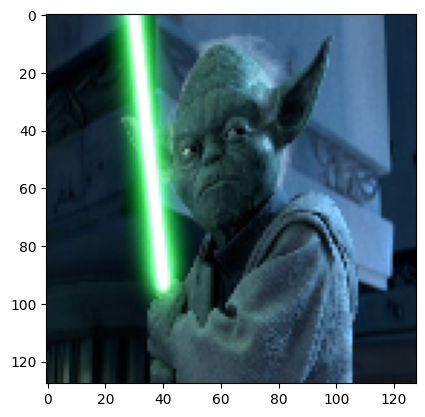

In [20]:
yoda = test_img_array
yoda = yoda.reshape(1, 49152)

yoda_res = yoda[0].reshape(128,128,3)
plt.imshow(yoda_res, cmap = "gray")

1/1 [==============================] - 0s 58ms/step


2023-01-14 20:58:42.465964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


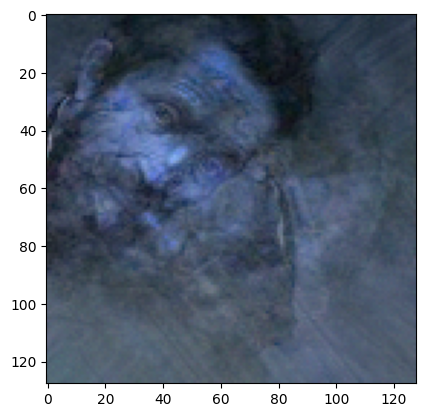

In [21]:
test = autoencoder.predict(yoda)
test = test[0].reshape(128, 128, 3)
plt.imshow(test, cmap = 'gray')

# CNN Autoencoder: Convert Harry into Voldemort

Use the Helper Code to augment our data 

# Add more samples

In [3]:
#Create an datagenerator to rotate training pictures

#datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=90) 
datagenerator = ImageDataGenerator(
                    rotation_range=90,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=45.0,
                    height_shift_range=45.0) 

#specify folder, change into the right one with chdir otherwise there were problems
img_folder = '/Users/nicolasrehbach/Documents/GitHub/AML_fork/data/ex_six'
os.chdir(img_folder)
image_names = os.listdir(img_folder)

#loop through the data, reshape the images and create new ones

#remove comment on for to create augmented data

#for filename in image_names:
    print(filename)
    img = tf.keras.utils.load_img(filename)  
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0
    n = 50
    # generate n new augmented images 
    for batch in datagenerator.flow(x, batch_size = 1, save_to_dir = img_folder, save_format ='jpeg'):
        i += 1
        if i > n: 
            break

IndentationError: unexpected indent (4156070555.py, line 21)

In [42]:
def preprocess_img(size, input_path, output_path, test_path):
    SIZE = size

#import the input images
    input_img_data = []
    input_path = input_path
    files = os.listdir(input_path)
    
    for i in tqdm(files):
        if(i != ".DS_Store"):
            img=cv2.imread(input_path+'/'+i,1)   #Change 0 to 1 for color images
            img=cv2.resize(img,(SIZE, SIZE))
            input_img_data.append(img_to_array(img))
        
        
    output_img_data = []
    output_path = output_path
    files = os.listdir(output_path)
    
    for i in tqdm(files):
        if(i != ".DS_Store"):
            img = cv2.imread(output_path+'/'+i,1)
            img = cv2.resize(img, (SIZE, SIZE))
            output_img_data.append(img_to_array(img))
            
    #reshape the images and normalize
    # we create an array of: input data length (50, since we created them previously, 256x256, 3)
    # 3 used for RGB
    input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 3))
    # our input image is defined as float and divided through 255. Now each image has its unique 
    # converting every pixel to float and dividing every pixel trough 255 (normalize each pixel) 
    input_img_array = input_img_array.astype('float32')/255

    output_img_array = np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 3))
    output_img_array = output_img_array.astype('float32')/255
    
    #take an image that does not belong to the training set
    test_img_data = []
    test_img = cv2.imread(test_path,1)
    test_img = cv2.resize(test_img, (SIZE, SIZE))
    test_img_data.append(img_to_array(test_img))

    test_img_array = np.reshape(test_img_data, (len(test_img_data), SIZE, SIZE, 3))
    test_img_array = test_img_array.astype('float32')/255

    start = time.time()
    
    return(size, input_img_array, output_img_array, test_img_array, start)

In [43]:
SIZE, input_img_array, output_img_array, test_img_array, start = preprocess_img(16, './data/ex_six/harrypotter/', './data/ex_six/voldemort/', './data/ex_six/harrypotter.jpeg')



100%|█████████████████████████████████████████| 52/52 [00:00<00:00, 1750.49it/s]


### Now our data is fully read in. We have 50 Harry Potter pictures and 50 Voldemort pictures.

### Now the autoencoder-decoder model is build

## How does a CNN work? 

based on [computerphile](https://www.youtube.com/watch?v=py5byOOHZM8)

- Combine deep neural networks and kernel convolution 
- In DNN the output is a complicated outcome of the input
- For images normal DNN are not really useful
  -  7MB image leads to 7 million input neurons
- Therefore, we downsample the pictures
- CNNs however, replace the nodes with a kernel convolution
  - let the CNN figure out, which features are important
  - Input: Picture
  - Layer1: Feature (e.g.: Edges, corners etc.)
  - LayerN: More features based on the features
    - Combinations of features (numbers of corners, edges, shapes etc.)
  - We end up with a smaller image and lots of features and basically convolutions of convolutions of convolutions...
    - each one looks different and represents something different (one is highlighed when a face is in the middle, another when a ear is seen)
  - These go down to a single pixel, without any spatial information just features
    - These are our final neurons, which are then used for the ouput
  - We adjust weights by backwards propagation
  - We train the network on input images. If the test image classifies the image as one of the input images, the output is 1, else 0
  

In [44]:
model = Sequential()
# Input shape 3 because we are dealing with RGB
# Conv2D: applies a 2d convolution over an input signal Conv2D(number of neurons, (kernelsize, kernelsize))
# Relu: activation function
# Padding: number of pixels added to an image while processed by the kernel
# We use Relu as our activation, since Relu is the mostly used for image processing 

model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same', input_shape = (SIZE, SIZE, 3)))
model.add(MaxPooling2D((2,2), padding = 'same'))
#MaxPooling2D, downsample the input along its height and width
model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'same'))
model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'same'))

model.add(Conv2D(8, (3,3), activation = 'relu', padding = 'same'))

model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
#Add our output layer
model.add(Conv2D(3, (3,3), activation = 'relu', padding = "same"))

#we use adam as our optimizer and mse as our loss function
model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 512)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          147520    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)        

Observations:
- Other shaped (64x32x8) etc. were tried however did not lead to a result
- Selu is another activation function, however takes about double the time of relu
- Loss: BinaryCrossentropy as loss was slower than MSE
- Loss: MeanAbsoluteError did not perform well
- Optimizer: Adamax did not work, SGD worked but didnt pass a loss of 0.08 for 70+ epochs.
- Overall Adam seemed to work out pretty well

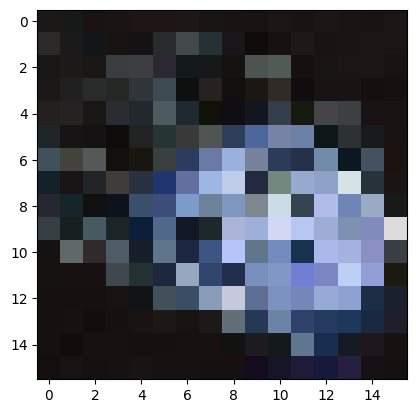

In [45]:
plt.imshow(input_img_array[0].reshape(SIZE,SIZE,3))

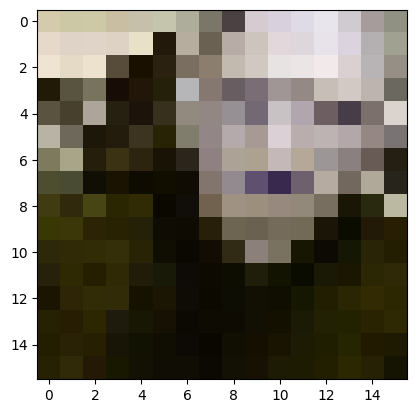

In [46]:
plt.imshow(output_img_array[0].reshape(SIZE,SIZE,3))

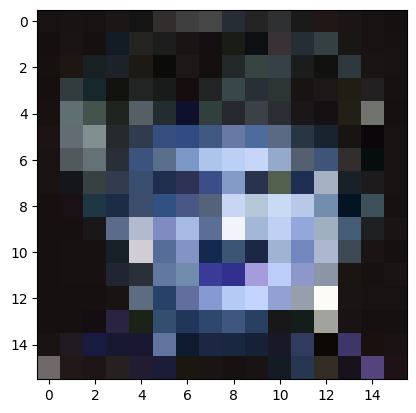

In [47]:
plt.imshow(test_img_array[0].reshape(SIZE, SIZE, 3))

In [48]:
train_y = output_img_array
train_x = input_img_array
val_y = output_img_array
val_x = input_img_array

In [49]:
epochs = 20000
# fitting the model on harry pictures to voldemort pictures
model.fit(train_x, train_y, epochs = epochs, shuffle = True, validation_data = (val_x, val_y))
finish=time.time()
print('total computation time = ', finish-start)

Epoch 1/20000


2023-01-11 14:53:57.372051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 335ms/step - loss: 0.1921 - accuracy: 0.1821 - val_loss: 0.1819 - val_accuracy: 0.8758
Epoch 2/20000
1/2 [==============>...............] - ETA: 0s - loss: 0.1867 - accuracy: 0.8715

2023-01-11 14:53:57.880891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 85ms/step - loss: 0.1631 - accuracy: 0.8769 - val_loss: 0.2717 - val_accuracy: 0.8787
Epoch 3/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.2138 - accuracy: 0.8787 - val_loss: 0.1593 - val_accuracy: 0.8648
Epoch 4/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.1655 - accuracy: 0.8434 - val_loss: 0.1805 - val_accuracy: 0.0347
Epoch 5/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.1789 - accuracy: 0.0347 - val_loss: 0.1674 - val_accuracy: 0.0347
Epoch 6/20000
2/2 [==============================] - 0s 86ms/step - loss: 0.1627 - accuracy: 0.0347 - val_loss: 0.1364 - val_accuracy: 0.0347
Epoch 7/20000
2/2 [==============================] - 0s 92ms/step - loss: 0.1292 - accuracy: 0.0347 - val_loss: 0.1057 - val_accuracy: 0.0347
Epoch 8/20000
2/2 [==============================] - 0s 82ms/step - loss: 0.1111 - accuracy: 0.0347 - val_loss: 0.1166 - val_accuracy: 0.0347
Epoch 9/20000
2/2 [=

2/2 [==============================] - 0s 84ms/step - loss: 0.0272 - accuracy: 0.8734 - val_loss: 0.0278 - val_accuracy: 0.8752
Epoch 117/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0271 - accuracy: 0.8743 - val_loss: 0.0292 - val_accuracy: 0.8682
Epoch 118/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0283 - accuracy: 0.8703 - val_loss: 0.0285 - val_accuracy: 0.8759
Epoch 119/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.0278 - accuracy: 0.8756 - val_loss: 0.0284 - val_accuracy: 0.8739
Epoch 120/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0274 - accuracy: 0.8756 - val_loss: 0.0282 - val_accuracy: 0.8775
Epoch 121/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0273 - accuracy: 0.8773 - val_loss: 0.0276 - val_accuracy: 0.8762
Epoch 122/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.0276 - accuracy: 0.8768 - val_loss: 0.0259 - val_accuracy: 0.8776
Epoch 12

2/2 [==============================] - 0s 81ms/step - loss: 0.0196 - accuracy: 0.8757 - val_loss: 0.0191 - val_accuracy: 0.8763
Epoch 174/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0194 - accuracy: 0.8760 - val_loss: 0.0186 - val_accuracy: 0.8748
Epoch 175/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0191 - accuracy: 0.8739 - val_loss: 0.0186 - val_accuracy: 0.8734
Epoch 176/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0187 - accuracy: 0.8732 - val_loss: 0.0193 - val_accuracy: 0.8733
Epoch 177/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0190 - accuracy: 0.8738 - val_loss: 0.0187 - val_accuracy: 0.8745
Epoch 178/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0186 - accuracy: 0.8742 - val_loss: 0.0182 - val_accuracy: 0.8758
Epoch 179/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0183 - accuracy: 0.8758 - val_loss: 0.0180 - val_accuracy: 0.8757
Epoch 18

2/2 [==============================] - 0s 79ms/step - loss: 0.0133 - accuracy: 0.8608 - val_loss: 0.0132 - val_accuracy: 0.8581
Epoch 231/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.0132 - accuracy: 0.8589 - val_loss: 0.0131 - val_accuracy: 0.8653
Epoch 232/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0131 - accuracy: 0.8673 - val_loss: 0.0131 - val_accuracy: 0.8726
Epoch 233/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0130 - accuracy: 0.8732 - val_loss: 0.0131 - val_accuracy: 0.8712
Epoch 234/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0131 - accuracy: 0.8696 - val_loss: 0.0132 - val_accuracy: 0.8660
Epoch 235/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0131 - accuracy: 0.8650 - val_loss: 0.0135 - val_accuracy: 0.8575
Epoch 236/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0132 - accuracy: 0.8565 - val_loss: 0.0130 - val_accuracy: 0.8623
Epoch 23

2/2 [==============================] - 0s 83ms/step - loss: 0.0095 - accuracy: 0.8611 - val_loss: 0.0101 - val_accuracy: 0.8593
Epoch 288/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.0099 - accuracy: 0.8575 - val_loss: 0.0097 - val_accuracy: 0.8545
Epoch 289/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.0100 - accuracy: 0.8566 - val_loss: 0.0093 - val_accuracy: 0.8588
Epoch 290/20000
2/2 [==============================] - 0s 95ms/step - loss: 0.0099 - accuracy: 0.8592 - val_loss: 0.0106 - val_accuracy: 0.8669
Epoch 291/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0102 - accuracy: 0.8666 - val_loss: 0.0122 - val_accuracy: 0.8619
Epoch 292/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0111 - accuracy: 0.8613 - val_loss: 0.0131 - val_accuracy: 0.8578
Epoch 293/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.0128 - accuracy: 0.8552 - val_loss: 0.0139 - val_accuracy: 0.8585
Epoch 29

2/2 [==============================] - 0s 84ms/step - loss: 0.0067 - accuracy: 0.8500 - val_loss: 0.0067 - val_accuracy: 0.8553
Epoch 345/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0067 - accuracy: 0.8542 - val_loss: 0.0067 - val_accuracy: 0.8515
Epoch 346/20000
2/2 [==============================] - 0s 78ms/step - loss: 0.0067 - accuracy: 0.8503 - val_loss: 0.0066 - val_accuracy: 0.8482
Epoch 347/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.0066 - accuracy: 0.8493 - val_loss: 0.0065 - val_accuracy: 0.8532
Epoch 348/20000
2/2 [==============================] - 0s 82ms/step - loss: 0.0065 - accuracy: 0.8529 - val_loss: 0.0065 - val_accuracy: 0.8559
Epoch 349/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0065 - accuracy: 0.8549 - val_loss: 0.0065 - val_accuracy: 0.8499
Epoch 350/20000
2/2 [==============================] - 0s 78ms/step - loss: 0.0065 - accuracy: 0.8487 - val_loss: 0.0065 - val_accuracy: 0.8516
Epoch 35

2/2 [==============================] - 0s 79ms/step - loss: 0.0048 - accuracy: 0.8572 - val_loss: 0.0047 - val_accuracy: 0.8552
Epoch 402/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0047 - accuracy: 0.8552 - val_loss: 0.0047 - val_accuracy: 0.8547
Epoch 403/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0047 - accuracy: 0.8548 - val_loss: 0.0046 - val_accuracy: 0.8578
Epoch 404/20000
2/2 [==============================] - 0s 82ms/step - loss: 0.0047 - accuracy: 0.8566 - val_loss: 0.0046 - val_accuracy: 0.8573
Epoch 405/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.0046 - accuracy: 0.8562 - val_loss: 0.0045 - val_accuracy: 0.8555
Epoch 406/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0046 - accuracy: 0.8553 - val_loss: 0.0044 - val_accuracy: 0.8602
Epoch 407/20000
2/2 [==============================] - 0s 87ms/step - loss: 0.0045 - accuracy: 0.8609 - val_loss: 0.0044 - val_accuracy: 0.8563
Epoch 40

Epoch 458/20000
2/2 [==============================] - 0s 78ms/step - loss: 0.0065 - accuracy: 0.8740 - val_loss: 0.0058 - val_accuracy: 0.8638
Epoch 459/20000
2/2 [==============================] - 0s 78ms/step - loss: 0.0060 - accuracy: 0.8637 - val_loss: 0.0070 - val_accuracy: 0.8681
Epoch 460/20000
2/2 [==============================] - 0s 78ms/step - loss: 0.0064 - accuracy: 0.8709 - val_loss: 0.0066 - val_accuracy: 0.8841
Epoch 461/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0062 - accuracy: 0.8837 - val_loss: 0.0057 - val_accuracy: 0.8840
Epoch 462/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0060 - accuracy: 0.8827 - val_loss: 0.0048 - val_accuracy: 0.8708
Epoch 463/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0054 - accuracy: 0.8688 - val_loss: 0.0046 - val_accuracy: 0.8773
Epoch 464/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0050 - accuracy: 0.8780 - val_loss: 0.0053 - val_accuracy:

Epoch 515/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0022 - accuracy: 0.8699 - val_loss: 0.0022 - val_accuracy: 0.8727
Epoch 516/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0022 - accuracy: 0.8722 - val_loss: 0.0022 - val_accuracy: 0.8683
Epoch 517/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0022 - accuracy: 0.8679 - val_loss: 0.0022 - val_accuracy: 0.8689
Epoch 518/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0021 - accuracy: 0.8709 - val_loss: 0.0021 - val_accuracy: 0.8742
Epoch 519/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0021 - accuracy: 0.8729 - val_loss: 0.0021 - val_accuracy: 0.8673
Epoch 520/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.0021 - accuracy: 0.8679 - val_loss: 0.0021 - val_accuracy: 0.8705
Epoch 521/20000
2/2 [==============================] - 0s 86ms/step - loss: 0.0021 - accuracy: 0.8713 - val_loss: 0.0021 - val_accuracy:

Epoch 572/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0017 - accuracy: 0.8858 - val_loss: 0.0016 - val_accuracy: 0.8799
Epoch 573/20000
2/2 [==============================] - 0s 86ms/step - loss: 0.0016 - accuracy: 0.8794 - val_loss: 0.0016 - val_accuracy: 0.8788
Epoch 574/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0016 - accuracy: 0.8822 - val_loss: 0.0016 - val_accuracy: 0.8859
Epoch 575/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0016 - accuracy: 0.8869 - val_loss: 0.0016 - val_accuracy: 0.8879
Epoch 576/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0016 - accuracy: 0.8823 - val_loss: 0.0016 - val_accuracy: 0.8664
Epoch 577/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0017 - accuracy: 0.8719 - val_loss: 0.0016 - val_accuracy: 0.8930
Epoch 578/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0017 - accuracy: 0.8921 - val_loss: 0.0015 - val_accuracy:

Epoch 629/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0023 - accuracy: 0.8829 - val_loss: 0.0024 - val_accuracy: 0.9013
Epoch 630/20000
2/2 [==============================] - 0s 88ms/step - loss: 0.0026 - accuracy: 0.9015 - val_loss: 0.0021 - val_accuracy: 0.9005
Epoch 631/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0022 - accuracy: 0.8975 - val_loss: 0.0025 - val_accuracy: 0.8719
Epoch 632/20000
2/2 [==============================] - 0s 87ms/step - loss: 0.0023 - accuracy: 0.8763 - val_loss: 0.0030 - val_accuracy: 0.9028
Epoch 633/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.0026 - accuracy: 0.9029 - val_loss: 0.0027 - val_accuracy: 0.8955
Epoch 634/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0024 - accuracy: 0.8899 - val_loss: 0.0024 - val_accuracy: 0.8609
Epoch 635/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0022 - accuracy: 0.8645 - val_loss: 0.0022 - val_accuracy:

2/2 [==============================] - 0s 79ms/step - loss: 8.0710e-04 - accuracy: 0.9048 - val_loss: 7.8841e-04 - val_accuracy: 0.9052
Epoch 740/20000
2/2 [==============================] - 0s 81ms/step - loss: 8.0161e-04 - accuracy: 0.9040 - val_loss: 7.8221e-04 - val_accuracy: 0.9063
Epoch 741/20000
2/2 [==============================] - 0s 81ms/step - loss: 7.9939e-04 - accuracy: 0.9069 - val_loss: 7.9318e-04 - val_accuracy: 0.9051
Epoch 742/20000
2/2 [==============================] - 0s 87ms/step - loss: 8.0867e-04 - accuracy: 0.9020 - val_loss: 7.8005e-04 - val_accuracy: 0.9052
Epoch 743/20000
2/2 [==============================] - 0s 80ms/step - loss: 7.8870e-04 - accuracy: 0.9063 - val_loss: 7.9010e-04 - val_accuracy: 0.9054
Epoch 744/20000
2/2 [==============================] - 0s 85ms/step - loss: 7.8494e-04 - accuracy: 0.9026 - val_loss: 7.9842e-04 - val_accuracy: 0.8993
Epoch 745/20000
2/2 [==============================] - 0s 81ms/step - loss: 7.9804e-04 - accuracy: 0.905

Epoch 794/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0012 - accuracy: 0.9147 - val_loss: 0.0012 - val_accuracy: 0.9198
Epoch 795/20000
2/2 [==============================] - 0s 83ms/step - loss: 0.0011 - accuracy: 0.9136 - val_loss: 0.0011 - val_accuracy: 0.8850
Epoch 796/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0010 - accuracy: 0.8940 - val_loss: 0.0012 - val_accuracy: 0.9157
Epoch 797/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0011 - accuracy: 0.9167 - val_loss: 0.0012 - val_accuracy: 0.9091
Epoch 798/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0010 - accuracy: 0.9017 - val_loss: 0.0014 - val_accuracy: 0.9062
Epoch 799/20000
2/2 [==============================] - 0s 78ms/step - loss: 0.0013 - accuracy: 0.9096 - val_loss: 0.0012 - val_accuracy: 0.9151
Epoch 800/20000
2/2 [==============================] - 0s 78ms/step - loss: 0.0012 - accuracy: 0.9138 - val_loss: 0.0011 - val_accuracy:

2/2 [==============================] - 0s 78ms/step - loss: 0.0015 - accuracy: 0.9183 - val_loss: 0.0015 - val_accuracy: 0.9141
Epoch 904/20000
2/2 [==============================] - 0s 78ms/step - loss: 0.0014 - accuracy: 0.9111 - val_loss: 0.0016 - val_accuracy: 0.9055
Epoch 905/20000
2/2 [==============================] - 0s 86ms/step - loss: 0.0014 - accuracy: 0.9107 - val_loss: 0.0016 - val_accuracy: 0.9148
Epoch 906/20000
2/2 [==============================] - 0s 77ms/step - loss: 0.0015 - accuracy: 0.9169 - val_loss: 0.0015 - val_accuracy: 0.9077
Epoch 907/20000
2/2 [==============================] - 0s 82ms/step - loss: 0.0013 - accuracy: 0.8992 - val_loss: 0.0014 - val_accuracy: 0.9092
Epoch 908/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0013 - accuracy: 0.9127 - val_loss: 0.0013 - val_accuracy: 0.9188
Epoch 909/20000
2/2 [==============================] - 0s 77ms/step - loss: 0.0012 - accuracy: 0.9207 - val_loss: 0.0013 - val_accuracy: 0.9005
Epoch 91

Epoch 960/20000
2/2 [==============================] - 0s 80ms/step - loss: 9.5819e-04 - accuracy: 0.9212 - val_loss: 0.0010 - val_accuracy: 0.9200
Epoch 961/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.0010 - accuracy: 0.9182 - val_loss: 0.0011 - val_accuracy: 0.9170
Epoch 962/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0010 - accuracy: 0.9194 - val_loss: 0.0011 - val_accuracy: 0.9256
Epoch 963/20000
2/2 [==============================] - 0s 80ms/step - loss: 9.6506e-04 - accuracy: 0.9259 - val_loss: 9.3304e-04 - val_accuracy: 0.9230
Epoch 964/20000
2/2 [==============================] - 0s 80ms/step - loss: 9.5738e-04 - accuracy: 0.9229 - val_loss: 7.3535e-04 - val_accuracy: 0.9168
Epoch 965/20000
2/2 [==============================] - 0s 80ms/step - loss: 8.5082e-04 - accuracy: 0.9169 - val_loss: 6.4662e-04 - val_accuracy: 0.9197
Epoch 966/20000
2/2 [==============================] - 0s 79ms/step - loss: 7.7026e-04 - accuracy: 0.9205 - 

Epoch 1014/20000
2/2 [==============================] - 0s 83ms/step - loss: 4.2190e-04 - accuracy: 0.9277 - val_loss: 4.1792e-04 - val_accuracy: 0.9278
Epoch 1015/20000
2/2 [==============================] - 0s 84ms/step - loss: 4.1912e-04 - accuracy: 0.9278 - val_loss: 4.1778e-04 - val_accuracy: 0.9280
Epoch 1016/20000
2/2 [==============================] - 0s 82ms/step - loss: 4.1725e-04 - accuracy: 0.9285 - val_loss: 4.1850e-04 - val_accuracy: 0.9272
Epoch 1017/20000
2/2 [==============================] - 0s 80ms/step - loss: 4.1701e-04 - accuracy: 0.9273 - val_loss: 4.1791e-04 - val_accuracy: 0.9275
Epoch 1018/20000
2/2 [==============================] - 0s 83ms/step - loss: 4.1664e-04 - accuracy: 0.9274 - val_loss: 4.1569e-04 - val_accuracy: 0.9278
Epoch 1019/20000
2/2 [==============================] - 0s 85ms/step - loss: 4.1452e-04 - accuracy: 0.9278 - val_loss: 4.1578e-04 - val_accuracy: 0.9282
Epoch 1020/20000
2/2 [==============================] - 0s 79ms/step - loss: 4.139

Epoch 1122/20000
2/2 [==============================] - 0s 81ms/step - loss: 7.7650e-04 - accuracy: 0.9281 - val_loss: 6.4132e-04 - val_accuracy: 0.9179
Epoch 1123/20000
2/2 [==============================] - 0s 84ms/step - loss: 7.2651e-04 - accuracy: 0.9144 - val_loss: 7.1254e-04 - val_accuracy: 0.9319
Epoch 1124/20000
2/2 [==============================] - 0s 83ms/step - loss: 7.0828e-04 - accuracy: 0.9293 - val_loss: 8.3119e-04 - val_accuracy: 0.9283
Epoch 1125/20000
2/2 [==============================] - 0s 87ms/step - loss: 7.7124e-04 - accuracy: 0.9296 - val_loss: 7.8660e-04 - val_accuracy: 0.9177
Epoch 1126/20000
2/2 [==============================] - 0s 84ms/step - loss: 7.3890e-04 - accuracy: 0.9206 - val_loss: 7.9089e-04 - val_accuracy: 0.9348
Epoch 1127/20000
2/2 [==============================] - 0s 80ms/step - loss: 7.1897e-04 - accuracy: 0.9358 - val_loss: 7.3834e-04 - val_accuracy: 0.9367
Epoch 1128/20000
2/2 [==============================] - 0s 84ms/step - loss: 6.829

Epoch 1230/20000
2/2 [==============================] - 0s 89ms/step - loss: 0.0021 - accuracy: 0.9334 - val_loss: 0.0016 - val_accuracy: 0.9293
Epoch 1231/20000
2/2 [==============================] - 0s 87ms/step - loss: 0.0018 - accuracy: 0.9290 - val_loss: 0.0013 - val_accuracy: 0.9285
Epoch 1232/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0016 - accuracy: 0.9280 - val_loss: 7.9945e-04 - val_accuracy: 0.9336
Epoch 1233/20000
2/2 [==============================] - 0s 82ms/step - loss: 0.0011 - accuracy: 0.9334 - val_loss: 0.0010 - val_accuracy: 0.9306
Epoch 1234/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.0011 - accuracy: 0.9302 - val_loss: 0.0016 - val_accuracy: 0.9295
Epoch 1235/20000
2/2 [==============================] - 0s 79ms/step - loss: 0.0014 - accuracy: 0.9309 - val_loss: 0.0016 - val_accuracy: 0.9333
Epoch 1236/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0014 - accuracy: 0.9334 - val_loss: 0.0013 - va

2/2 [==============================] - 0s 81ms/step - loss: 3.8332e-04 - accuracy: 0.9396 - val_loss: 3.7510e-04 - val_accuracy: 0.9404
Epoch 1285/20000
2/2 [==============================] - 0s 80ms/step - loss: 3.6261e-04 - accuracy: 0.9411 - val_loss: 3.8133e-04 - val_accuracy: 0.9429
Epoch 1286/20000
2/2 [==============================] - 0s 81ms/step - loss: 3.6819e-04 - accuracy: 0.9422 - val_loss: 3.7676e-04 - val_accuracy: 0.9393
Epoch 1287/20000
2/2 [==============================] - 0s 85ms/step - loss: 3.7124e-04 - accuracy: 0.9395 - val_loss: 3.7068e-04 - val_accuracy: 0.9406
Epoch 1288/20000
2/2 [==============================] - 0s 96ms/step - loss: 3.7185e-04 - accuracy: 0.9407 - val_loss: 3.4874e-04 - val_accuracy: 0.9403
Epoch 1289/20000
2/2 [==============================] - 0s 80ms/step - loss: 3.6128e-04 - accuracy: 0.9400 - val_loss: 3.2935e-04 - val_accuracy: 0.9403
Epoch 1290/20000
2/2 [==============================] - 0s 85ms/step - loss: 3.4286e-04 - accuracy:

2/2 [==============================] - 0s 80ms/step - loss: 2.7749e-04 - accuracy: 0.9450 - val_loss: 2.8874e-04 - val_accuracy: 0.9462
Epoch 1391/20000
2/2 [==============================] - 0s 80ms/step - loss: 2.8025e-04 - accuracy: 0.9458 - val_loss: 2.9168e-04 - val_accuracy: 0.9445
Epoch 1392/20000
2/2 [==============================] - 0s 80ms/step - loss: 2.8124e-04 - accuracy: 0.9447 - val_loss: 2.9948e-04 - val_accuracy: 0.9454
Epoch 1393/20000
2/2 [==============================] - 0s 85ms/step - loss: 2.8687e-04 - accuracy: 0.9455 - val_loss: 3.1351e-04 - val_accuracy: 0.9458
Epoch 1394/20000
2/2 [==============================] - 0s 80ms/step - loss: 2.9608e-04 - accuracy: 0.9451 - val_loss: 3.2958e-04 - val_accuracy: 0.9449
Epoch 1395/20000
2/2 [==============================] - 0s 80ms/step - loss: 3.0785e-04 - accuracy: 0.9445 - val_loss: 3.3868e-04 - val_accuracy: 0.9459
Epoch 1396/20000
2/2 [==============================] - 0s 81ms/step - loss: 3.1320e-04 - accuracy:

Epoch 1445/20000
2/2 [==============================] - 0s 80ms/step - loss: 3.9534e-04 - accuracy: 0.9307 - val_loss: 4.4264e-04 - val_accuracy: 0.9389
Epoch 1446/20000
2/2 [==============================] - 0s 81ms/step - loss: 4.1141e-04 - accuracy: 0.9382 - val_loss: 4.5479e-04 - val_accuracy: 0.9439
Epoch 1447/20000
2/2 [==============================] - 0s 86ms/step - loss: 4.2923e-04 - accuracy: 0.9409 - val_loss: 4.2705e-04 - val_accuracy: 0.9384
Epoch 1448/20000
2/2 [==============================] - 0s 79ms/step - loss: 4.1449e-04 - accuracy: 0.9416 - val_loss: 3.8389e-04 - val_accuracy: 0.9404
Epoch 1449/20000
2/2 [==============================] - 0s 81ms/step - loss: 3.8773e-04 - accuracy: 0.9416 - val_loss: 3.3848e-04 - val_accuracy: 0.9412
Epoch 1450/20000
2/2 [==============================] - 0s 82ms/step - loss: 3.6008e-04 - accuracy: 0.9391 - val_loss: 3.1373e-04 - val_accuracy: 0.9435
Epoch 1451/20000
2/2 [==============================] - 0s 80ms/step - loss: 3.351

2/2 [==============================] - 0s 93ms/step - loss: 6.7002e-04 - accuracy: 0.9483 - val_loss: 9.3296e-04 - val_accuracy: 0.9475
Epoch 1552/20000
2/2 [==============================] - 0s 79ms/step - loss: 7.4162e-04 - accuracy: 0.9472 - val_loss: 0.0011 - val_accuracy: 0.9499
Epoch 1553/20000
2/2 [==============================] - 0s 84ms/step - loss: 9.0687e-04 - accuracy: 0.9498 - val_loss: 0.0013 - val_accuracy: 0.9504
Epoch 1554/20000
2/2 [==============================] - 0s 80ms/step - loss: 9.9467e-04 - accuracy: 0.9481 - val_loss: 0.0013 - val_accuracy: 0.9443
Epoch 1555/20000
2/2 [==============================] - 0s 81ms/step - loss: 0.0011 - accuracy: 0.9455 - val_loss: 0.0014 - val_accuracy: 0.9516
Epoch 1556/20000
2/2 [==============================] - 0s 86ms/step - loss: 0.0012 - accuracy: 0.9509 - val_loss: 0.0012 - val_accuracy: 0.9462
Epoch 1557/20000
2/2 [==============================] - 0s 80ms/step - loss: 0.0011 - accuracy: 0.9453 - val_loss: 9.9780e-04 -

Epoch 1605/20000
2/2 [==============================] - 0s 80ms/step - loss: 3.1359e-04 - accuracy: 0.9486 - val_loss: 2.9292e-04 - val_accuracy: 0.9495
Epoch 1606/20000
2/2 [==============================] - 0s 83ms/step - loss: 2.9920e-04 - accuracy: 0.9508 - val_loss: 3.4107e-04 - val_accuracy: 0.9511
Epoch 1607/20000
2/2 [==============================] - 0s 80ms/step - loss: 3.4123e-04 - accuracy: 0.9507 - val_loss: 3.3688e-04 - val_accuracy: 0.9475
Epoch 1608/20000
2/2 [==============================] - 0s 94ms/step - loss: 3.1669e-04 - accuracy: 0.9468 - val_loss: 3.8896e-04 - val_accuracy: 0.9491
Epoch 1609/20000
2/2 [==============================] - 0s 80ms/step - loss: 3.5109e-04 - accuracy: 0.9505 - val_loss: 4.0226e-04 - val_accuracy: 0.9503
Epoch 1610/20000
2/2 [==============================] - 0s 84ms/step - loss: 3.6635e-04 - accuracy: 0.9494 - val_loss: 3.9837e-04 - val_accuracy: 0.9449
Epoch 1611/20000
2/2 [==============================] - 0s 89ms/step - loss: 3.733

2/2 [==============================] - 0s 80ms/step - loss: 6.0339e-04 - accuracy: 0.9537 - val_loss: 7.1527e-04 - val_accuracy: 0.9515
Epoch 1712/20000
2/2 [==============================] - 0s 82ms/step - loss: 6.0378e-04 - accuracy: 0.9499 - val_loss: 6.8210e-04 - val_accuracy: 0.9454
Epoch 1713/20000
2/2 [==============================] - 0s 85ms/step - loss: 6.2785e-04 - accuracy: 0.9482 - val_loss: 7.0539e-04 - val_accuracy: 0.9540
Epoch 1714/20000
2/2 [==============================] - 0s 80ms/step - loss: 6.3638e-04 - accuracy: 0.9534 - val_loss: 7.8838e-04 - val_accuracy: 0.9498
Epoch 1715/20000
2/2 [==============================] - 0s 80ms/step - loss: 7.2954e-04 - accuracy: 0.9465 - val_loss: 7.5512e-04 - val_accuracy: 0.9511
Epoch 1716/20000
2/2 [==============================] - 0s 89ms/step - loss: 6.9970e-04 - accuracy: 0.9519 - val_loss: 8.2628e-04 - val_accuracy: 0.9523
Epoch 1717/20000
2/2 [==============================] - 0s 80ms/step - loss: 8.2379e-04 - accuracy:

Epoch 1765/20000
2/2 [==============================] - 0s 85ms/step - loss: 6.2965e-04 - accuracy: 0.9510 - val_loss: 4.4207e-04 - val_accuracy: 0.9511
Epoch 1766/20000
2/2 [==============================] - 0s 81ms/step - loss: 5.6994e-04 - accuracy: 0.9521 - val_loss: 3.4867e-04 - val_accuracy: 0.9465
Epoch 1767/20000
2/2 [==============================] - 0s 82ms/step - loss: 4.8008e-04 - accuracy: 0.9461 - val_loss: 3.6573e-04 - val_accuracy: 0.9510
Epoch 1768/20000
2/2 [==============================] - 0s 82ms/step - loss: 4.7016e-04 - accuracy: 0.9507 - val_loss: 4.4724e-04 - val_accuracy: 0.9488
Epoch 1769/20000
2/2 [==============================] - 0s 85ms/step - loss: 5.7005e-04 - accuracy: 0.9490 - val_loss: 4.3706e-04 - val_accuracy: 0.9467
Epoch 1770/20000
2/2 [==============================] - 0s 81ms/step - loss: 5.5511e-04 - accuracy: 0.9468 - val_loss: 4.2875e-04 - val_accuracy: 0.9530
Epoch 1771/20000
2/2 [==============================] - 0s 79ms/step - loss: 4.697

2/2 [==============================] - 0s 82ms/step - loss: 2.0378e-04 - accuracy: 0.9556 - val_loss: 2.0362e-04 - val_accuracy: 0.9550
Epoch 1872/20000
2/2 [==============================] - 0s 83ms/step - loss: 2.0354e-04 - accuracy: 0.9552 - val_loss: 2.0345e-04 - val_accuracy: 0.9557
Epoch 1873/20000
2/2 [==============================] - 0s 83ms/step - loss: 2.0332e-04 - accuracy: 0.9556 - val_loss: 2.0354e-04 - val_accuracy: 0.9557
Epoch 1874/20000
2/2 [==============================] - 0s 84ms/step - loss: 2.0346e-04 - accuracy: 0.9552 - val_loss: 2.0305e-04 - val_accuracy: 0.9548
Epoch 1875/20000
2/2 [==============================] - 0s 83ms/step - loss: 2.0294e-04 - accuracy: 0.9548 - val_loss: 2.0352e-04 - val_accuracy: 0.9556
Epoch 1876/20000
2/2 [==============================] - 0s 83ms/step - loss: 2.0310e-04 - accuracy: 0.9556 - val_loss: 2.0419e-04 - val_accuracy: 0.9557
Epoch 1877/20000
2/2 [==============================] - 0s 83ms/step - loss: 2.0365e-04 - accuracy:

2/2 [==============================] - 0s 86ms/step - loss: 0.0021 - accuracy: 0.9355 - val_loss: 0.0025 - val_accuracy: 0.9447
Epoch 1926/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.0020 - accuracy: 0.9442 - val_loss: 0.0026 - val_accuracy: 0.9448
Epoch 1927/20000
2/2 [==============================] - 0s 86ms/step - loss: 0.0022 - accuracy: 0.9444 - val_loss: 0.0020 - val_accuracy: 0.9421
Epoch 1928/20000
2/2 [==============================] - 0s 84ms/step - loss: 0.0018 - accuracy: 0.9422 - val_loss: 0.0020 - val_accuracy: 0.9416
Epoch 1929/20000
2/2 [==============================] - 0s 85ms/step - loss: 0.0020 - accuracy: 0.9414 - val_loss: 0.0014 - val_accuracy: 0.9390
Epoch 1930/20000
2/2 [==============================] - 0s 86ms/step - loss: 0.0017 - accuracy: 0.9357 - val_loss: 0.0011 - val_accuracy: 0.9373
Epoch 1931/20000
2/2 [==============================] - 0s 82ms/step - loss: 0.0015 - accuracy: 0.9358 - val_loss: 9.4849e-04 - val_accuracy: 0.940

2/2 [==============================] - 0s 86ms/step - loss: 2.1486e-04 - accuracy: 0.9580 - val_loss: 2.1786e-04 - val_accuracy: 0.9556
Epoch 2033/20000
2/2 [==============================] - 0s 85ms/step - loss: 2.1521e-04 - accuracy: 0.9553 - val_loss: 2.1612e-04 - val_accuracy: 0.9592
Epoch 2034/20000
2/2 [==============================] - 0s 85ms/step - loss: 2.1412e-04 - accuracy: 0.9596 - val_loss: 2.1491e-04 - val_accuracy: 0.9583
Epoch 2035/20000
2/2 [==============================] - 0s 85ms/step - loss: 2.1319e-04 - accuracy: 0.9575 - val_loss: 2.1385e-04 - val_accuracy: 0.9567
Epoch 2036/20000
2/2 [==============================] - 0s 87ms/step - loss: 2.1284e-04 - accuracy: 0.9576 - val_loss: 2.1570e-04 - val_accuracy: 0.9598
Epoch 2037/20000
2/2 [==============================] - 0s 85ms/step - loss: 2.1290e-04 - accuracy: 0.9589 - val_loss: 2.1479e-04 - val_accuracy: 0.9564
Epoch 2038/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.1476e-04 - accuracy:

2/2 [==============================] - 0s 88ms/step - loss: 2.9854e-04 - accuracy: 0.9573 - val_loss: 2.8324e-04 - val_accuracy: 0.9606
Epoch 2139/20000
2/2 [==============================] - 0s 88ms/step - loss: 3.0173e-04 - accuracy: 0.9606 - val_loss: 2.6780e-04 - val_accuracy: 0.9565
Epoch 2140/20000
2/2 [==============================] - 0s 99ms/step - loss: 2.9291e-04 - accuracy: 0.9563 - val_loss: 2.6700e-04 - val_accuracy: 0.9607
Epoch 2141/20000
2/2 [==============================] - 0s 87ms/step - loss: 2.9497e-04 - accuracy: 0.9603 - val_loss: 2.5019e-04 - val_accuracy: 0.9609
Epoch 2142/20000
2/2 [==============================] - 0s 87ms/step - loss: 2.7163e-04 - accuracy: 0.9604 - val_loss: 2.3375e-04 - val_accuracy: 0.9535
Epoch 2143/20000
2/2 [==============================] - 0s 88ms/step - loss: 2.5769e-04 - accuracy: 0.9547 - val_loss: 2.3410e-04 - val_accuracy: 0.9599
Epoch 2144/20000
2/2 [==============================] - 0s 88ms/step - loss: 2.5631e-04 - accuracy:

2/2 [==============================] - 0s 104ms/step - loss: 4.0038e-04 - accuracy: 0.9449 - val_loss: 4.1782e-04 - val_accuracy: 0.9537
Epoch 2245/20000
2/2 [==============================] - 0s 90ms/step - loss: 4.0424e-04 - accuracy: 0.9554 - val_loss: 4.3971e-04 - val_accuracy: 0.9505
Epoch 2246/20000
2/2 [==============================] - 0s 89ms/step - loss: 4.4428e-04 - accuracy: 0.9489 - val_loss: 4.3097e-04 - val_accuracy: 0.9573
Epoch 2247/20000
2/2 [==============================] - 0s 89ms/step - loss: 4.4747e-04 - accuracy: 0.9574 - val_loss: 4.9243e-04 - val_accuracy: 0.9601
Epoch 2248/20000
2/2 [==============================] - 0s 89ms/step - loss: 5.2967e-04 - accuracy: 0.9570 - val_loss: 4.4308e-04 - val_accuracy: 0.9564
Epoch 2249/20000
2/2 [==============================] - 0s 105ms/step - loss: 4.9009e-04 - accuracy: 0.9560 - val_loss: 4.1950e-04 - val_accuracy: 0.9573
Epoch 2250/20000
2/2 [==============================] - 0s 90ms/step - loss: 4.6140e-04 - accurac

2/2 [==============================] - 0s 89ms/step - loss: 3.7667e-04 - accuracy: 0.9606 - val_loss: 2.5949e-04 - val_accuracy: 0.9625
Epoch 2351/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.3934e-04 - accuracy: 0.9614 - val_loss: 2.6221e-04 - val_accuracy: 0.9573
Epoch 2352/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.3433e-04 - accuracy: 0.9562 - val_loss: 2.7375e-04 - val_accuracy: 0.9609
Epoch 2353/20000
2/2 [==============================] - 0s 89ms/step - loss: 3.0254e-04 - accuracy: 0.9611 - val_loss: 3.0645e-04 - val_accuracy: 0.9616
Epoch 2354/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.0952e-04 - accuracy: 0.9607 - val_loss: 3.6317e-04 - val_accuracy: 0.9540
Epoch 2355/20000
2/2 [==============================] - 0s 89ms/step - loss: 3.2429e-04 - accuracy: 0.9549 - val_loss: 4.2642e-04 - val_accuracy: 0.9619
Epoch 2356/20000
2/2 [==============================] - 0s 89ms/step - loss: 3.7789e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 1.9752e-04 - accuracy: 0.9634 - val_loss: 1.9379e-04 - val_accuracy: 0.9643
Epoch 2457/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.0331e-04 - accuracy: 0.9634 - val_loss: 1.8626e-04 - val_accuracy: 0.9597
Epoch 2458/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.9763e-04 - accuracy: 0.9611 - val_loss: 1.9464e-04 - val_accuracy: 0.9665
Epoch 2459/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.9503e-04 - accuracy: 0.9658 - val_loss: 2.0918e-04 - val_accuracy: 0.9602
Epoch 2460/20000
2/2 [==============================] - 0s 89ms/step - loss: 2.0732e-04 - accuracy: 0.9596 - val_loss: 2.0888e-04 - val_accuracy: 0.9635
Epoch 2461/20000
2/2 [==============================] - 0s 88ms/step - loss: 2.0870e-04 - accuracy: 0.9647 - val_loss: 2.0871e-04 - val_accuracy: 0.9649
Epoch 2462/20000
2/2 [==============================] - 0s 89ms/step - loss: 2.0380e-04 - accuracy:

2/2 [==============================] - 0s 89ms/step - loss: 2.3127e-04 - accuracy: 0.9644 - val_loss: 2.6263e-04 - val_accuracy: 0.9656
Epoch 2563/20000
2/2 [==============================] - 0s 90ms/step - loss: 2.4173e-04 - accuracy: 0.9654 - val_loss: 2.5478e-04 - val_accuracy: 0.9655
Epoch 2564/20000
2/2 [==============================] - 0s 90ms/step - loss: 2.3385e-04 - accuracy: 0.9662 - val_loss: 2.6900e-04 - val_accuracy: 0.9651
Epoch 2565/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.4275e-04 - accuracy: 0.9653 - val_loss: 3.1265e-04 - val_accuracy: 0.9641
Epoch 2566/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.7333e-04 - accuracy: 0.9648 - val_loss: 3.1527e-04 - val_accuracy: 0.9646
Epoch 2567/20000
2/2 [==============================] - 0s 90ms/step - loss: 2.7844e-04 - accuracy: 0.9648 - val_loss: 3.4834e-04 - val_accuracy: 0.9651
Epoch 2568/20000
2/2 [==============================] - 0s 90ms/step - loss: 2.9849e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 3.4541e-04 - accuracy: 0.9560 - val_loss: 3.7387e-04 - val_accuracy: 0.9635
Epoch 2669/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.6122e-04 - accuracy: 0.9643 - val_loss: 3.8717e-04 - val_accuracy: 0.9627
Epoch 2670/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.8595e-04 - accuracy: 0.9598 - val_loss: 4.3478e-04 - val_accuracy: 0.9580
Epoch 2671/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.4054e-04 - accuracy: 0.9599 - val_loss: 3.9637e-04 - val_accuracy: 0.9656
Epoch 2672/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.0195e-04 - accuracy: 0.9654 - val_loss: 3.4614e-04 - val_accuracy: 0.9589
Epoch 2673/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.6803e-04 - accuracy: 0.9593 - val_loss: 3.0417e-04 - val_accuracy: 0.9649
Epoch 2674/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.4938e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 3.4173e-04 - accuracy: 0.9657 - val_loss: 3.8677e-04 - val_accuracy: 0.9674
Epoch 2775/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.3742e-04 - accuracy: 0.9679 - val_loss: 3.9699e-04 - val_accuracy: 0.9668
Epoch 2776/20000
2/2 [==============================] - 0s 89ms/step - loss: 3.5768e-04 - accuracy: 0.9665 - val_loss: 3.9445e-04 - val_accuracy: 0.9657
Epoch 2777/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.4471e-04 - accuracy: 0.9670 - val_loss: 3.7541e-04 - val_accuracy: 0.9684
Epoch 2778/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.4518e-04 - accuracy: 0.9681 - val_loss: 4.0987e-04 - val_accuracy: 0.9665
Epoch 2779/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.6260e-04 - accuracy: 0.9661 - val_loss: 4.5184e-04 - val_accuracy: 0.9679
Epoch 2780/20000
2/2 [==============================] - 0s 89ms/step - loss: 4.0907e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 4.8645e-04 - accuracy: 0.9481 - val_loss: 5.8026e-04 - val_accuracy: 0.9563
Epoch 2881/20000
2/2 [==============================] - 0s 91ms/step - loss: 5.4937e-04 - accuracy: 0.9572 - val_loss: 5.2736e-04 - val_accuracy: 0.9537
Epoch 2882/20000
2/2 [==============================] - 0s 91ms/step - loss: 5.1685e-04 - accuracy: 0.9511 - val_loss: 4.7936e-04 - val_accuracy: 0.9334
Epoch 2883/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.8485e-04 - accuracy: 0.9403 - val_loss: 3.8711e-04 - val_accuracy: 0.9602
Epoch 2884/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.0576e-04 - accuracy: 0.9575 - val_loss: 3.9254e-04 - val_accuracy: 0.9596
Epoch 2885/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.1727e-04 - accuracy: 0.9496 - val_loss: 4.2003e-04 - val_accuracy: 0.9552
Epoch 2886/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.4210e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 3.1879e-04 - accuracy: 0.9621 - val_loss: 2.7356e-04 - val_accuracy: 0.9689
Epoch 2987/20000
2/2 [==============================] - 0s 93ms/step - loss: 3.2075e-04 - accuracy: 0.9671 - val_loss: 2.6987e-04 - val_accuracy: 0.9632
Epoch 2988/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.0120e-04 - accuracy: 0.9602 - val_loss: 2.6605e-04 - val_accuracy: 0.9622
Epoch 2989/20000
2/2 [==============================] - 0s 89ms/step - loss: 3.0795e-04 - accuracy: 0.9636 - val_loss: 2.3241e-04 - val_accuracy: 0.9661
Epoch 2990/20000
2/2 [==============================] - 0s 89ms/step - loss: 2.7447e-04 - accuracy: 0.9640 - val_loss: 2.3887e-04 - val_accuracy: 0.9513
Epoch 2991/20000
2/2 [==============================] - 0s 88ms/step - loss: 2.6671e-04 - accuracy: 0.9541 - val_loss: 2.1932e-04 - val_accuracy: 0.9694
Epoch 2992/20000
2/2 [==============================] - 0s 89ms/step - loss: 2.5144e-04 - accuracy:

2/2 [==============================] - 0s 94ms/step - loss: 3.0965e-04 - accuracy: 0.9657 - val_loss: 2.8570e-04 - val_accuracy: 0.9665
Epoch 3093/20000
2/2 [==============================] - 0s 95ms/step - loss: 3.4913e-04 - accuracy: 0.9657 - val_loss: 2.7327e-04 - val_accuracy: 0.9637
Epoch 3094/20000
2/2 [==============================] - 0s 93ms/step - loss: 3.0500e-04 - accuracy: 0.9645 - val_loss: 2.8429e-04 - val_accuracy: 0.9681
Epoch 3095/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.9878e-04 - accuracy: 0.9671 - val_loss: 3.2298e-04 - val_accuracy: 0.9681
Epoch 3096/20000
2/2 [==============================] - 0s 99ms/step - loss: 3.1083e-04 - accuracy: 0.9684 - val_loss: 3.3030e-04 - val_accuracy: 0.9658
Epoch 3097/20000
2/2 [==============================] - 0s 92ms/step - loss: 3.0420e-04 - accuracy: 0.9658 - val_loss: 3.5536e-04 - val_accuracy: 0.9683
Epoch 3098/20000
2/2 [==============================] - 0s 92ms/step - loss: 3.2669e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 1.6732e-04 - accuracy: 0.9689 - val_loss: 1.7199e-04 - val_accuracy: 0.9668
Epoch 3199/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.6977e-04 - accuracy: 0.9674 - val_loss: 1.7401e-04 - val_accuracy: 0.9707
Epoch 3200/20000
2/2 [==============================] - 0s 88ms/step - loss: 1.7093e-04 - accuracy: 0.9710 - val_loss: 1.7441e-04 - val_accuracy: 0.9674
Epoch 3201/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.7147e-04 - accuracy: 0.9673 - val_loss: 1.7521e-04 - val_accuracy: 0.9695
Epoch 3202/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.7278e-04 - accuracy: 0.9700 - val_loss: 1.7557e-04 - val_accuracy: 0.9706
Epoch 3203/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.7287e-04 - accuracy: 0.9692 - val_loss: 1.7500e-04 - val_accuracy: 0.9678
Epoch 3204/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.7309e-04 - accuracy:

Epoch 3306/20000
2/2 [==============================] - 0s 90ms/step - loss: 5.2009e-04 - accuracy: 0.9474 - val_loss: 5.6626e-04 - val_accuracy: 0.9504
Epoch 3307/20000
2/2 [==============================] - 0s 90ms/step - loss: 5.0157e-04 - accuracy: 0.9504 - val_loss: 7.0802e-04 - val_accuracy: 0.9478
Epoch 3308/20000
2/2 [==============================] - 0s 90ms/step - loss: 6.0038e-04 - accuracy: 0.9491 - val_loss: 5.5864e-04 - val_accuracy: 0.9537
Epoch 3309/20000
2/2 [==============================] - 0s 90ms/step - loss: 5.2246e-04 - accuracy: 0.9533 - val_loss: 4.1795e-04 - val_accuracy: 0.9537
Epoch 3310/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.7906e-04 - accuracy: 0.9534 - val_loss: 3.3313e-04 - val_accuracy: 0.9481
Epoch 3311/20000
2/2 [==============================] - 0s 90ms/step - loss: 4.3294e-04 - accuracy: 0.9488 - val_loss: 2.8862e-04 - val_accuracy: 0.9547
Epoch 3312/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.431

2/2 [==============================] - 0s 90ms/step - loss: 1.5719e-04 - accuracy: 0.9673 - val_loss: 1.5750e-04 - val_accuracy: 0.9671
Epoch 3413/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.5746e-04 - accuracy: 0.9669 - val_loss: 1.5760e-04 - val_accuracy: 0.9667
Epoch 3414/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.5738e-04 - accuracy: 0.9668 - val_loss: 1.5761e-04 - val_accuracy: 0.9680
Epoch 3415/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.5732e-04 - accuracy: 0.9681 - val_loss: 1.5717e-04 - val_accuracy: 0.9665
Epoch 3416/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5705e-04 - accuracy: 0.9663 - val_loss: 1.5701e-04 - val_accuracy: 0.9668
Epoch 3417/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.5694e-04 - accuracy: 0.9672 - val_loss: 1.5645e-04 - val_accuracy: 0.9679
Epoch 3418/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.5664e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 1.5073e-04 - accuracy: 0.9694 - val_loss: 1.5071e-04 - val_accuracy: 0.9695
Epoch 3519/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.5070e-04 - accuracy: 0.9696 - val_loss: 1.5067e-04 - val_accuracy: 0.9696
Epoch 3520/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.5067e-04 - accuracy: 0.9695 - val_loss: 1.5064e-04 - val_accuracy: 0.9697
Epoch 3521/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.5064e-04 - accuracy: 0.9698 - val_loss: 1.5061e-04 - val_accuracy: 0.9698
Epoch 3522/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.5060e-04 - accuracy: 0.9697 - val_loss: 1.5058e-04 - val_accuracy: 0.9697
Epoch 3523/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.5057e-04 - accuracy: 0.9698 - val_loss: 1.5055e-04 - val_accuracy: 0.9699
Epoch 3524/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5054e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 3.7301e-04 - accuracy: 0.9622 - val_loss: 2.9367e-04 - val_accuracy: 0.9651
Epoch 3626/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.3198e-04 - accuracy: 0.9654 - val_loss: 3.9111e-04 - val_accuracy: 0.9608
Epoch 3627/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.8788e-04 - accuracy: 0.9616 - val_loss: 4.2336e-04 - val_accuracy: 0.9610
Epoch 3628/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.6425e-04 - accuracy: 0.9622 - val_loss: 4.5528e-04 - val_accuracy: 0.9642
Epoch 3629/20000
2/2 [==============================] - 0s 90ms/step - loss: 4.0636e-04 - accuracy: 0.9644 - val_loss: 4.0080e-04 - val_accuracy: 0.9667
Epoch 3630/20000
2/2 [==============================] - 0s 107ms/step - loss: 3.9551e-04 - accuracy: 0.9667 - val_loss: 3.1237e-04 - val_accuracy: 0.9671
Epoch 3631/20000
2/2 [==============================] - 0s 93ms/step - loss: 3.7165e-04 - accuracy

2/2 [==============================] - 0s 90ms/step - loss: 1.4736e-04 - accuracy: 0.9710 - val_loss: 1.4678e-04 - val_accuracy: 0.9714
Epoch 3732/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4714e-04 - accuracy: 0.9720 - val_loss: 1.4679e-04 - val_accuracy: 0.9720
Epoch 3733/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4708e-04 - accuracy: 0.9717 - val_loss: 1.4678e-04 - val_accuracy: 0.9711
Epoch 3734/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4695e-04 - accuracy: 0.9715 - val_loss: 1.4697e-04 - val_accuracy: 0.9722
Epoch 3735/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4698e-04 - accuracy: 0.9718 - val_loss: 1.4689e-04 - val_accuracy: 0.9710
Epoch 3736/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.4686e-04 - accuracy: 0.9710 - val_loss: 1.4692e-04 - val_accuracy: 0.9710
Epoch 3737/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4678e-04 - accuracy:

2/2 [==============================] - 0s 94ms/step - loss: 4.7434e-04 - accuracy: 0.9640 - val_loss: 5.0157e-04 - val_accuracy: 0.9667
Epoch 3838/20000
2/2 [==============================] - 0s 94ms/step - loss: 5.2205e-04 - accuracy: 0.9656 - val_loss: 5.4166e-04 - val_accuracy: 0.9661
Epoch 3839/20000
2/2 [==============================] - 0s 94ms/step - loss: 5.0091e-04 - accuracy: 0.9659 - val_loss: 5.8253e-04 - val_accuracy: 0.9648
Epoch 3840/20000
2/2 [==============================] - 0s 94ms/step - loss: 5.2768e-04 - accuracy: 0.9643 - val_loss: 5.6287e-04 - val_accuracy: 0.9650
Epoch 3841/20000
2/2 [==============================] - 0s 94ms/step - loss: 5.0249e-04 - accuracy: 0.9653 - val_loss: 6.3091e-04 - val_accuracy: 0.9694
Epoch 3842/20000
2/2 [==============================] - 0s 93ms/step - loss: 5.6392e-04 - accuracy: 0.9681 - val_loss: 6.9467e-04 - val_accuracy: 0.9631
Epoch 3843/20000
2/2 [==============================] - 0s 94ms/step - loss: 6.5798e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 1.4760e-04 - accuracy: 0.9730 - val_loss: 1.4706e-04 - val_accuracy: 0.9720
Epoch 3944/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4758e-04 - accuracy: 0.9717 - val_loss: 1.4660e-04 - val_accuracy: 0.9731
Epoch 3945/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4695e-04 - accuracy: 0.9730 - val_loss: 1.4671e-04 - val_accuracy: 0.9730
Epoch 3946/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4683e-04 - accuracy: 0.9730 - val_loss: 1.4632e-04 - val_accuracy: 0.9720
Epoch 3947/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4700e-04 - accuracy: 0.9722 - val_loss: 1.4604e-04 - val_accuracy: 0.9731
Epoch 3948/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4627e-04 - accuracy: 0.9729 - val_loss: 1.4778e-04 - val_accuracy: 0.9723
Epoch 3949/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.4729e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 1.8264e-04 - accuracy: 0.9725 - val_loss: 1.6777e-04 - val_accuracy: 0.9725
Epoch 4050/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.8102e-04 - accuracy: 0.9728 - val_loss: 1.6599e-04 - val_accuracy: 0.9737
Epoch 4051/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.7577e-04 - accuracy: 0.9732 - val_loss: 1.6710e-04 - val_accuracy: 0.9694
Epoch 4052/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.7309e-04 - accuracy: 0.9697 - val_loss: 1.7083e-04 - val_accuracy: 0.9740
Epoch 4053/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.7660e-04 - accuracy: 0.9737 - val_loss: 1.6855e-04 - val_accuracy: 0.9717
Epoch 4054/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.7284e-04 - accuracy: 0.9715 - val_loss: 1.7067e-04 - val_accuracy: 0.9723
Epoch 4055/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.7602e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 2.7806e-04 - accuracy: 0.9638 - val_loss: 3.8003e-04 - val_accuracy: 0.9734
Epoch 4156/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.4357e-04 - accuracy: 0.9707 - val_loss: 3.9321e-04 - val_accuracy: 0.9572
Epoch 4157/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.4258e-04 - accuracy: 0.9576 - val_loss: 4.1233e-04 - val_accuracy: 0.9674
Epoch 4158/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.8138e-04 - accuracy: 0.9689 - val_loss: 3.4935e-04 - val_accuracy: 0.9645
Epoch 4159/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.5800e-04 - accuracy: 0.9606 - val_loss: 3.1525e-04 - val_accuracy: 0.9534
Epoch 4160/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.4823e-04 - accuracy: 0.9616 - val_loss: 2.8193e-04 - val_accuracy: 0.9680
Epoch 4161/20000
2/2 [==============================] - 0s 92ms/step - loss: 3.4071e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 1.6390e-04 - accuracy: 0.9730 - val_loss: 1.6285e-04 - val_accuracy: 0.9767
Epoch 4262/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.6214e-04 - accuracy: 0.9750 - val_loss: 1.6329e-04 - val_accuracy: 0.9700
Epoch 4263/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.6301e-04 - accuracy: 0.9714 - val_loss: 1.5964e-04 - val_accuracy: 0.9757
Epoch 4264/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5893e-04 - accuracy: 0.9758 - val_loss: 1.6003e-04 - val_accuracy: 0.9726
Epoch 4265/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.5909e-04 - accuracy: 0.9714 - val_loss: 1.5884e-04 - val_accuracy: 0.9743
Epoch 4266/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5714e-04 - accuracy: 0.9757 - val_loss: 1.5891e-04 - val_accuracy: 0.9751
Epoch 4267/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5729e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 4.1609e-04 - accuracy: 0.9535 - val_loss: 2.9879e-04 - val_accuracy: 0.9532
Epoch 4368/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.5282e-04 - accuracy: 0.9588 - val_loss: 2.7705e-04 - val_accuracy: 0.9642
Epoch 4369/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.2167e-04 - accuracy: 0.9597 - val_loss: 3.0206e-04 - val_accuracy: 0.9488
Epoch 4370/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.9715e-04 - accuracy: 0.9504 - val_loss: 3.5889e-04 - val_accuracy: 0.9615
Epoch 4371/20000
2/2 [==============================] - 0s 92ms/step - loss: 3.4603e-04 - accuracy: 0.9612 - val_loss: 3.3447e-04 - val_accuracy: 0.9596
Epoch 4372/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.1082e-04 - accuracy: 0.9551 - val_loss: 3.6311e-04 - val_accuracy: 0.9434
Epoch 4373/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.3884e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 1.3922e-04 - accuracy: 0.9760 - val_loss: 1.3884e-04 - val_accuracy: 0.9746
Epoch 4474/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3901e-04 - accuracy: 0.9750 - val_loss: 1.3872e-04 - val_accuracy: 0.9757
Epoch 4475/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.3889e-04 - accuracy: 0.9756 - val_loss: 1.3871e-04 - val_accuracy: 0.9753
Epoch 4476/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3880e-04 - accuracy: 0.9753 - val_loss: 1.3900e-04 - val_accuracy: 0.9753
Epoch 4477/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3889e-04 - accuracy: 0.9750 - val_loss: 1.3911e-04 - val_accuracy: 0.9751
Epoch 4478/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.3899e-04 - accuracy: 0.9752 - val_loss: 1.3869e-04 - val_accuracy: 0.9750
Epoch 4479/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3879e-04 - accuracy:

2/2 [==============================] - 0s 101ms/step - loss: 3.5804e-04 - accuracy: 0.9758 - val_loss: 5.5394e-04 - val_accuracy: 0.9752
Epoch 4580/20000
2/2 [==============================] - 0s 106ms/step - loss: 4.4187e-04 - accuracy: 0.9759 - val_loss: 5.5770e-04 - val_accuracy: 0.9760
Epoch 4581/20000
2/2 [==============================] - 0s 96ms/step - loss: 4.3100e-04 - accuracy: 0.9753 - val_loss: 6.3416e-04 - val_accuracy: 0.9737
Epoch 4582/20000
2/2 [==============================] - 0s 93ms/step - loss: 5.3037e-04 - accuracy: 0.9743 - val_loss: 6.5737e-04 - val_accuracy: 0.9759
Epoch 4583/20000
2/2 [==============================] - 0s 92ms/step - loss: 5.5260e-04 - accuracy: 0.9756 - val_loss: 7.4982e-04 - val_accuracy: 0.9720
Epoch 4584/20000
2/2 [==============================] - 0s 99ms/step - loss: 6.7223e-04 - accuracy: 0.9714 - val_loss: 5.9228e-04 - val_accuracy: 0.9746
Epoch 4585/20000
2/2 [==============================] - 0s 91ms/step - loss: 5.9046e-04 - accurac

2/2 [==============================] - 0s 92ms/step - loss: 1.4245e-04 - accuracy: 0.9756 - val_loss: 1.3995e-04 - val_accuracy: 0.9753
Epoch 4686/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.4208e-04 - accuracy: 0.9755 - val_loss: 1.3949e-04 - val_accuracy: 0.9759
Epoch 4687/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4116e-04 - accuracy: 0.9759 - val_loss: 1.3918e-04 - val_accuracy: 0.9765
Epoch 4688/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.4099e-04 - accuracy: 0.9765 - val_loss: 1.3880e-04 - val_accuracy: 0.9756
Epoch 4689/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4019e-04 - accuracy: 0.9756 - val_loss: 1.3923e-04 - val_accuracy: 0.9753
Epoch 4690/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4027e-04 - accuracy: 0.9756 - val_loss: 1.3900e-04 - val_accuracy: 0.9762
Epoch 4691/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3955e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 4.7491e-04 - accuracy: 0.9611 - val_loss: 3.3397e-04 - val_accuracy: 0.9566
Epoch 4792/20000
2/2 [==============================] - 0s 92ms/step - loss: 4.2098e-04 - accuracy: 0.9592 - val_loss: 2.6964e-04 - val_accuracy: 0.9667
Epoch 4793/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.6844e-04 - accuracy: 0.9658 - val_loss: 2.8143e-04 - val_accuracy: 0.9605
Epoch 4794/20000
2/2 [==============================] - 0s 92ms/step - loss: 3.4588e-04 - accuracy: 0.9599 - val_loss: 2.9653e-04 - val_accuracy: 0.9715
Epoch 4795/20000
2/2 [==============================] - 0s 92ms/step - loss: 3.1474e-04 - accuracy: 0.9711 - val_loss: 3.4496e-04 - val_accuracy: 0.9657
Epoch 4796/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.2396e-04 - accuracy: 0.9609 - val_loss: 3.7737e-04 - val_accuracy: 0.9593
Epoch 4797/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.5561e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 1.3783e-04 - accuracy: 0.9770 - val_loss: 1.3684e-04 - val_accuracy: 0.9764
Epoch 4898/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3758e-04 - accuracy: 0.9766 - val_loss: 1.3709e-04 - val_accuracy: 0.9780
Epoch 4899/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3784e-04 - accuracy: 0.9779 - val_loss: 1.3720e-04 - val_accuracy: 0.9763
Epoch 4900/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.3755e-04 - accuracy: 0.9764 - val_loss: 1.3697e-04 - val_accuracy: 0.9775
Epoch 4901/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3735e-04 - accuracy: 0.9776 - val_loss: 1.3653e-04 - val_accuracy: 0.9768
Epoch 4902/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3697e-04 - accuracy: 0.9766 - val_loss: 1.3643e-04 - val_accuracy: 0.9769
Epoch 4903/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3699e-04 - accuracy:

Epoch 5004/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.0330e-04 - accuracy: 0.9723 - val_loss: 1.8143e-04 - val_accuracy: 0.9636
Epoch 5005/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.8760e-04 - accuracy: 0.9568 - val_loss: 1.8025e-04 - val_accuracy: 0.9684
Epoch 5006/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.8586e-04 - accuracy: 0.9703 - val_loss: 1.7032e-04 - val_accuracy: 0.9743
Epoch 5007/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.7564e-04 - accuracy: 0.9730 - val_loss: 1.6660e-04 - val_accuracy: 0.9604
Epoch 5008/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.7092e-04 - accuracy: 0.9619 - val_loss: 1.6455e-04 - val_accuracy: 0.9755
Epoch 5009/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.6753e-04 - accuracy: 0.9756 - val_loss: 1.6514e-04 - val_accuracy: 0.9753
Epoch 5010/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.648

2/2 [==============================] - 0s 92ms/step - loss: 1.3373e-04 - accuracy: 0.9773 - val_loss: 1.3433e-04 - val_accuracy: 0.9769
Epoch 5111/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3402e-04 - accuracy: 0.9767 - val_loss: 1.3434e-04 - val_accuracy: 0.9766
Epoch 5112/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3410e-04 - accuracy: 0.9766 - val_loss: 1.3422e-04 - val_accuracy: 0.9773
Epoch 5113/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3406e-04 - accuracy: 0.9774 - val_loss: 1.3424e-04 - val_accuracy: 0.9772
Epoch 5114/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3416e-04 - accuracy: 0.9769 - val_loss: 1.3421e-04 - val_accuracy: 0.9772
Epoch 5115/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3422e-04 - accuracy: 0.9773 - val_loss: 1.3390e-04 - val_accuracy: 0.9770
Epoch 5116/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3411e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 3.2821e-04 - accuracy: 0.9718 - val_loss: 3.8027e-04 - val_accuracy: 0.9754
Epoch 5217/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.4052e-04 - accuracy: 0.9745 - val_loss: 3.4062e-04 - val_accuracy: 0.9691
Epoch 5218/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.3621e-04 - accuracy: 0.9689 - val_loss: 3.1002e-04 - val_accuracy: 0.9752
Epoch 5219/20000
2/2 [==============================] - 0s 90ms/step - loss: 3.2203e-04 - accuracy: 0.9753 - val_loss: 2.6024e-04 - val_accuracy: 0.9716
Epoch 5220/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.9814e-04 - accuracy: 0.9704 - val_loss: 2.2735e-04 - val_accuracy: 0.9701
Epoch 5221/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.7855e-04 - accuracy: 0.9713 - val_loss: 2.3247e-04 - val_accuracy: 0.9747
Epoch 5222/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.7839e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 1.3432e-04 - accuracy: 0.9773 - val_loss: 1.3386e-04 - val_accuracy: 0.9783
Epoch 5323/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3391e-04 - accuracy: 0.9784 - val_loss: 1.3384e-04 - val_accuracy: 0.9773
Epoch 5324/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3384e-04 - accuracy: 0.9772 - val_loss: 1.3353e-04 - val_accuracy: 0.9783
Epoch 5325/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.3365e-04 - accuracy: 0.9786 - val_loss: 1.3356e-04 - val_accuracy: 0.9780
Epoch 5326/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3369e-04 - accuracy: 0.9776 - val_loss: 1.3349e-04 - val_accuracy: 0.9768
Epoch 5327/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3363e-04 - accuracy: 0.9775 - val_loss: 1.3323e-04 - val_accuracy: 0.9786
Epoch 5328/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.3368e-04 - accuracy:

2/2 [==============================] - 0s 97ms/step - loss: 2.5273e-04 - accuracy: 0.9713 - val_loss: 1.9155e-04 - val_accuracy: 0.9763
Epoch 5429/20000
2/2 [==============================] - 0s 98ms/step - loss: 2.1343e-04 - accuracy: 0.9760 - val_loss: 2.3550e-04 - val_accuracy: 0.9648
Epoch 5430/20000
2/2 [==============================] - 0s 97ms/step - loss: 2.4529e-04 - accuracy: 0.9655 - val_loss: 2.4224e-04 - val_accuracy: 0.9752
Epoch 5431/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.3717e-04 - accuracy: 0.9762 - val_loss: 2.5346e-04 - val_accuracy: 0.9768
Epoch 5432/20000
2/2 [==============================] - 0s 97ms/step - loss: 2.3053e-04 - accuracy: 0.9718 - val_loss: 2.7409e-04 - val_accuracy: 0.9700
Epoch 5433/20000
2/2 [==============================] - 0s 96ms/step - loss: 2.4368e-04 - accuracy: 0.9725 - val_loss: 2.8394e-04 - val_accuracy: 0.9777
Epoch 5434/20000
2/2 [==============================] - 0s 96ms/step - loss: 2.5882e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 1.3458e-04 - accuracy: 0.9765 - val_loss: 1.3438e-04 - val_accuracy: 0.9792
Epoch 5535/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3452e-04 - accuracy: 0.9794 - val_loss: 1.3449e-04 - val_accuracy: 0.9773
Epoch 5536/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.3457e-04 - accuracy: 0.9771 - val_loss: 1.3604e-04 - val_accuracy: 0.9779
Epoch 5537/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.3570e-04 - accuracy: 0.9780 - val_loss: 1.3710e-04 - val_accuracy: 0.9782
Epoch 5538/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.3687e-04 - accuracy: 0.9773 - val_loss: 1.3634e-04 - val_accuracy: 0.9773
Epoch 5539/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3654e-04 - accuracy: 0.9773 - val_loss: 1.3537e-04 - val_accuracy: 0.9773
Epoch 5540/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.3586e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 4.8508e-04 - accuracy: 0.9737 - val_loss: 4.6262e-04 - val_accuracy: 0.9695
Epoch 5641/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.6250e-04 - accuracy: 0.9675 - val_loss: 4.9782e-04 - val_accuracy: 0.9707
Epoch 5642/20000
2/2 [==============================] - 0s 91ms/step - loss: 5.2958e-04 - accuracy: 0.9724 - val_loss: 3.1669e-04 - val_accuracy: 0.9721
Epoch 5643/20000
2/2 [==============================] - 0s 91ms/step - loss: 4.4479e-04 - accuracy: 0.9681 - val_loss: 3.3836e-04 - val_accuracy: 0.9549
Epoch 5644/20000
2/2 [==============================] - 0s 90ms/step - loss: 4.6808e-04 - accuracy: 0.9570 - val_loss: 3.3352e-04 - val_accuracy: 0.9717
Epoch 5645/20000
2/2 [==============================] - 0s 92ms/step - loss: 4.1613e-04 - accuracy: 0.9710 - val_loss: 3.3159e-04 - val_accuracy: 0.9557
Epoch 5646/20000
2/2 [==============================] - 0s 92ms/step - loss: 4.1033e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 1.3588e-04 - accuracy: 0.9778 - val_loss: 1.3615e-04 - val_accuracy: 0.9794
Epoch 5747/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.3607e-04 - accuracy: 0.9795 - val_loss: 1.3742e-04 - val_accuracy: 0.9789
Epoch 5748/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3707e-04 - accuracy: 0.9788 - val_loss: 1.3713e-04 - val_accuracy: 0.9784
Epoch 5749/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3763e-04 - accuracy: 0.9789 - val_loss: 1.3887e-04 - val_accuracy: 0.9796
Epoch 5750/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3855e-04 - accuracy: 0.9789 - val_loss: 1.3960e-04 - val_accuracy: 0.9768
Epoch 5751/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3948e-04 - accuracy: 0.9773 - val_loss: 1.4032e-04 - val_accuracy: 0.9795
Epoch 5752/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.4048e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 3.5033e-04 - accuracy: 0.9641 - val_loss: 3.7622e-04 - val_accuracy: 0.9492
Epoch 5853/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.5910e-04 - accuracy: 0.9531 - val_loss: 3.0448e-04 - val_accuracy: 0.9699
Epoch 5854/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.2153e-04 - accuracy: 0.9702 - val_loss: 2.6587e-04 - val_accuracy: 0.9593
Epoch 5855/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.8921e-04 - accuracy: 0.9570 - val_loss: 2.3887e-04 - val_accuracy: 0.9654
Epoch 5856/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.6937e-04 - accuracy: 0.9678 - val_loss: 2.3834e-04 - val_accuracy: 0.9724
Epoch 5857/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.5317e-04 - accuracy: 0.9694 - val_loss: 2.2118e-04 - val_accuracy: 0.9567
Epoch 5858/20000
2/2 [==============================] - 0s 90ms/step - loss: 2.4228e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 1.3461e-04 - accuracy: 0.9770 - val_loss: 1.3168e-04 - val_accuracy: 0.9783
Epoch 5959/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3272e-04 - accuracy: 0.9795 - val_loss: 1.3417e-04 - val_accuracy: 0.9799
Epoch 5960/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3352e-04 - accuracy: 0.9791 - val_loss: 1.3703e-04 - val_accuracy: 0.9769
Epoch 5961/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.3571e-04 - accuracy: 0.9777 - val_loss: 1.3619e-04 - val_accuracy: 0.9808
Epoch 5962/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3651e-04 - accuracy: 0.9805 - val_loss: 1.3411e-04 - val_accuracy: 0.9775
Epoch 5963/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3542e-04 - accuracy: 0.9775 - val_loss: 1.3371e-04 - val_accuracy: 0.9791
Epoch 5964/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.3442e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 1.5544e-04 - accuracy: 0.9803 - val_loss: 1.4940e-04 - val_accuracy: 0.9792
Epoch 6065/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5558e-04 - accuracy: 0.9784 - val_loss: 1.4855e-04 - val_accuracy: 0.9789
Epoch 6066/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5660e-04 - accuracy: 0.9797 - val_loss: 1.5663e-04 - val_accuracy: 0.9809
Epoch 6067/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.5985e-04 - accuracy: 0.9810 - val_loss: 1.4708e-04 - val_accuracy: 0.9789
Epoch 6068/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5226e-04 - accuracy: 0.9789 - val_loss: 1.4538e-04 - val_accuracy: 0.9783
Epoch 6069/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.5221e-04 - accuracy: 0.9786 - val_loss: 1.4703e-04 - val_accuracy: 0.9804
Epoch 6070/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.5417e-04 - accuracy:

2/2 [==============================] - 0s 90ms/step - loss: 1.4945e-04 - accuracy: 0.9728 - val_loss: 1.4769e-04 - val_accuracy: 0.9792
Epoch 6171/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4936e-04 - accuracy: 0.9805 - val_loss: 1.4742e-04 - val_accuracy: 0.9791
Epoch 6172/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4828e-04 - accuracy: 0.9759 - val_loss: 1.4782e-04 - val_accuracy: 0.9776
Epoch 6173/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.5088e-04 - accuracy: 0.9802 - val_loss: 1.4301e-04 - val_accuracy: 0.9823
Epoch 6174/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4505e-04 - accuracy: 0.9786 - val_loss: 1.4397e-04 - val_accuracy: 0.9714
Epoch 6175/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4451e-04 - accuracy: 0.9737 - val_loss: 1.4907e-04 - val_accuracy: 0.9841
Epoch 6176/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4649e-04 - accuracy:

2/2 [==============================] - 0s 95ms/step - loss: 1.8883e-04 - accuracy: 0.9823 - val_loss: 2.1146e-04 - val_accuracy: 0.9795
Epoch 6277/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.8919e-04 - accuracy: 0.9792 - val_loss: 2.2856e-04 - val_accuracy: 0.9813
Epoch 6278/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.0271e-04 - accuracy: 0.9816 - val_loss: 2.4185e-04 - val_accuracy: 0.9816
Epoch 6279/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.1266e-04 - accuracy: 0.9809 - val_loss: 2.7278e-04 - val_accuracy: 0.9784
Epoch 6280/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.3672e-04 - accuracy: 0.9791 - val_loss: 3.1816e-04 - val_accuracy: 0.9822
Epoch 6281/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.7268e-04 - accuracy: 0.9815 - val_loss: 4.0165e-04 - val_accuracy: 0.9756
Epoch 6282/20000
2/2 [==============================] - 0s 94ms/step - loss: 3.3550e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 1.2850e-04 - accuracy: 0.9803 - val_loss: 1.2820e-04 - val_accuracy: 0.9803
Epoch 6383/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2837e-04 - accuracy: 0.9792 - val_loss: 1.2813e-04 - val_accuracy: 0.9784
Epoch 6384/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2830e-04 - accuracy: 0.9792 - val_loss: 1.2813e-04 - val_accuracy: 0.9804
Epoch 6385/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2818e-04 - accuracy: 0.9800 - val_loss: 1.2832e-04 - val_accuracy: 0.9790
Epoch 6386/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2825e-04 - accuracy: 0.9792 - val_loss: 1.2826e-04 - val_accuracy: 0.9802
Epoch 6387/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2826e-04 - accuracy: 0.9804 - val_loss: 1.2819e-04 - val_accuracy: 0.9788
Epoch 6388/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2823e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 1.8629e-04 - accuracy: 0.9777 - val_loss: 1.9229e-04 - val_accuracy: 0.9724
Epoch 6489/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.9937e-04 - accuracy: 0.9743 - val_loss: 1.9345e-04 - val_accuracy: 0.9824
Epoch 6490/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.9154e-04 - accuracy: 0.9806 - val_loss: 2.0889e-04 - val_accuracy: 0.9684
Epoch 6491/20000
2/2 [==============================] - 0s 93ms/step - loss: 2.0445e-04 - accuracy: 0.9699 - val_loss: 2.1015e-04 - val_accuracy: 0.9796
Epoch 6492/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.9814e-04 - accuracy: 0.9784 - val_loss: 2.2061e-04 - val_accuracy: 0.9698
Epoch 6493/20000
2/2 [==============================] - 0s 93ms/step - loss: 2.0603e-04 - accuracy: 0.9677 - val_loss: 2.0450e-04 - val_accuracy: 0.9798
Epoch 6494/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.0350e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 1.4212e-04 - accuracy: 0.9791 - val_loss: 1.5102e-04 - val_accuracy: 0.9794
Epoch 6595/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4503e-04 - accuracy: 0.9805 - val_loss: 1.5059e-04 - val_accuracy: 0.9825
Epoch 6596/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4387e-04 - accuracy: 0.9815 - val_loss: 1.5279e-04 - val_accuracy: 0.9782
Epoch 6597/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.4593e-04 - accuracy: 0.9789 - val_loss: 1.5532e-04 - val_accuracy: 0.9821
Epoch 6598/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4733e-04 - accuracy: 0.9815 - val_loss: 1.5520e-04 - val_accuracy: 0.9786
Epoch 6599/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4749e-04 - accuracy: 0.9790 - val_loss: 1.5300e-04 - val_accuracy: 0.9800
Epoch 6600/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.4515e-04 - accuracy:

2/2 [==============================] - 0s 93ms/step - loss: 1.3896e-04 - accuracy: 0.9786 - val_loss: 1.4086e-04 - val_accuracy: 0.9814
Epoch 6701/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3841e-04 - accuracy: 0.9818 - val_loss: 1.4429e-04 - val_accuracy: 0.9808
Epoch 6702/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.4110e-04 - accuracy: 0.9802 - val_loss: 1.4771e-04 - val_accuracy: 0.9799
Epoch 6703/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.4470e-04 - accuracy: 0.9802 - val_loss: 1.4200e-04 - val_accuracy: 0.9809
Epoch 6704/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.4082e-04 - accuracy: 0.9805 - val_loss: 1.3861e-04 - val_accuracy: 0.9802
Epoch 6705/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3878e-04 - accuracy: 0.9802 - val_loss: 1.3520e-04 - val_accuracy: 0.9800
Epoch 6706/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3782e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 1.2595e-04 - accuracy: 0.9802 - val_loss: 1.2602e-04 - val_accuracy: 0.9798
Epoch 6807/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2598e-04 - accuracy: 0.9798 - val_loss: 1.2614e-04 - val_accuracy: 0.9798
Epoch 6808/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2605e-04 - accuracy: 0.9801 - val_loss: 1.2629e-04 - val_accuracy: 0.9802
Epoch 6809/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.2615e-04 - accuracy: 0.9802 - val_loss: 1.2642e-04 - val_accuracy: 0.9802
Epoch 6810/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2625e-04 - accuracy: 0.9801 - val_loss: 1.2641e-04 - val_accuracy: 0.9803
Epoch 6811/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2625e-04 - accuracy: 0.9805 - val_loss: 1.2643e-04 - val_accuracy: 0.9802
Epoch 6812/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2624e-04 - accuracy:

2/2 [==============================] - 0s 105ms/step - loss: 1.3986e-04 - accuracy: 0.9806 - val_loss: 1.3724e-04 - val_accuracy: 0.9782
Epoch 6913/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.3857e-04 - accuracy: 0.9790 - val_loss: 1.3731e-04 - val_accuracy: 0.9814
Epoch 6914/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.3929e-04 - accuracy: 0.9811 - val_loss: 1.3509e-04 - val_accuracy: 0.9796
Epoch 6915/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3733e-04 - accuracy: 0.9795 - val_loss: 1.3257e-04 - val_accuracy: 0.9807
Epoch 6916/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3542e-04 - accuracy: 0.9809 - val_loss: 1.3162e-04 - val_accuracy: 0.9796
Epoch 6917/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.3446e-04 - accuracy: 0.9798 - val_loss: 1.3245e-04 - val_accuracy: 0.9795
Epoch 6918/20000
2/2 [==============================] - 0s 106ms/step - loss: 1.3391e-04 - accurac

2/2 [==============================] - 0s 94ms/step - loss: 1.2519e-04 - accuracy: 0.9804 - val_loss: 1.2519e-04 - val_accuracy: 0.9805
Epoch 7019/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2519e-04 - accuracy: 0.9805 - val_loss: 1.2517e-04 - val_accuracy: 0.9809
Epoch 7020/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2518e-04 - accuracy: 0.9808 - val_loss: 1.2516e-04 - val_accuracy: 0.9803
Epoch 7021/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2516e-04 - accuracy: 0.9804 - val_loss: 1.2516e-04 - val_accuracy: 0.9805
Epoch 7022/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2516e-04 - accuracy: 0.9805 - val_loss: 1.2516e-04 - val_accuracy: 0.9807
Epoch 7023/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2516e-04 - accuracy: 0.9808 - val_loss: 1.2515e-04 - val_accuracy: 0.9806
Epoch 7024/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2515e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 1.9844e-04 - accuracy: 0.9750 - val_loss: 1.9034e-04 - val_accuracy: 0.9536
Epoch 7125/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.9838e-04 - accuracy: 0.9596 - val_loss: 1.7750e-04 - val_accuracy: 0.9805
Epoch 7126/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.8978e-04 - accuracy: 0.9783 - val_loss: 1.7976e-04 - val_accuracy: 0.9694
Epoch 7127/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.9000e-04 - accuracy: 0.9637 - val_loss: 1.6660e-04 - val_accuracy: 0.9691
Epoch 7128/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.7889e-04 - accuracy: 0.9723 - val_loss: 1.6746e-04 - val_accuracy: 0.9809
Epoch 7129/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.6879e-04 - accuracy: 0.9767 - val_loss: 1.7731e-04 - val_accuracy: 0.9596
Epoch 7130/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.7477e-04 - accuracy:

2/2 [==============================] - 0s 95ms/step - loss: 1.2591e-04 - accuracy: 0.9824 - val_loss: 1.2610e-04 - val_accuracy: 0.9788
Epoch 7231/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2603e-04 - accuracy: 0.9791 - val_loss: 1.2596e-04 - val_accuracy: 0.9823
Epoch 7232/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2603e-04 - accuracy: 0.9825 - val_loss: 1.2584e-04 - val_accuracy: 0.9812
Epoch 7233/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2615e-04 - accuracy: 0.9802 - val_loss: 1.2560e-04 - val_accuracy: 0.9792
Epoch 7234/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2597e-04 - accuracy: 0.9804 - val_loss: 1.2580e-04 - val_accuracy: 0.9831
Epoch 7235/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2605e-04 - accuracy: 0.9825 - val_loss: 1.2593e-04 - val_accuracy: 0.9779
Epoch 7236/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2586e-04 - accuracy:

2/2 [==============================] - 0s 94ms/step - loss: 1.6700e-04 - accuracy: 0.9824 - val_loss: 1.6188e-04 - val_accuracy: 0.9782
Epoch 7337/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.6687e-04 - accuracy: 0.9799 - val_loss: 1.5976e-04 - val_accuracy: 0.9840
Epoch 7338/20000
2/2 [==============================] - 0s 126ms/step - loss: 1.6317e-04 - accuracy: 0.9832 - val_loss: 1.5116e-04 - val_accuracy: 0.9769
Epoch 7339/20000
2/2 [==============================] - 0s 129ms/step - loss: 1.5912e-04 - accuracy: 0.9766 - val_loss: 1.4688e-04 - val_accuracy: 0.9824
Epoch 7340/20000
2/2 [==============================] - 0s 126ms/step - loss: 1.5392e-04 - accuracy: 0.9828 - val_loss: 1.4148e-04 - val_accuracy: 0.9828
Epoch 7341/20000
2/2 [==============================] - 0s 133ms/step - loss: 1.4934e-04 - accuracy: 0.9821 - val_loss: 1.3852e-04 - val_accuracy: 0.9807
Epoch 7342/20000
2/2 [==============================] - 0s 141ms/step - loss: 1.4172e-04 - accu

2/2 [==============================] - 0s 94ms/step - loss: 1.6713e-04 - accuracy: 0.9822 - val_loss: 1.7521e-04 - val_accuracy: 0.9765
Epoch 7443/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.6667e-04 - accuracy: 0.9789 - val_loss: 1.6962e-04 - val_accuracy: 0.9855
Epoch 7444/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.6319e-04 - accuracy: 0.9847 - val_loss: 1.6429e-04 - val_accuracy: 0.9772
Epoch 7445/20000
2/2 [==============================] - 0s 121ms/step - loss: 1.5956e-04 - accuracy: 0.9773 - val_loss: 1.6229e-04 - val_accuracy: 0.9836
Epoch 7446/20000
2/2 [==============================] - 0s 113ms/step - loss: 1.5803e-04 - accuracy: 0.9835 - val_loss: 1.6340e-04 - val_accuracy: 0.9787
Epoch 7447/20000
2/2 [==============================] - 0s 115ms/step - loss: 1.5951e-04 - accuracy: 0.9786 - val_loss: 1.6678e-04 - val_accuracy: 0.9808
Epoch 7448/20000
2/2 [==============================] - 0s 107ms/step - loss: 1.6219e-04 - accur

2/2 [==============================] - 0s 93ms/step - loss: 4.5862e-04 - accuracy: 0.9550 - val_loss: 3.6777e-04 - val_accuracy: 0.9647
Epoch 7549/20000
2/2 [==============================] - 0s 93ms/step - loss: 4.2120e-04 - accuracy: 0.9635 - val_loss: 3.6746e-04 - val_accuracy: 0.9618
Epoch 7550/20000
2/2 [==============================] - 0s 94ms/step - loss: 3.8962e-04 - accuracy: 0.9586 - val_loss: 3.9474e-04 - val_accuracy: 0.9639
Epoch 7551/20000
2/2 [==============================] - 0s 117ms/step - loss: 3.8090e-04 - accuracy: 0.9647 - val_loss: 4.0930e-04 - val_accuracy: 0.9637
Epoch 7552/20000
2/2 [==============================] - 0s 92ms/step - loss: 3.8561e-04 - accuracy: 0.9643 - val_loss: 3.6093e-04 - val_accuracy: 0.9563
Epoch 7553/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.5480e-04 - accuracy: 0.9582 - val_loss: 3.3606e-04 - val_accuracy: 0.9681
Epoch 7554/20000
2/2 [==============================] - 0s 91ms/step - loss: 3.3600e-04 - accuracy

2/2 [==============================] - 0s 96ms/step - loss: 1.2520e-04 - accuracy: 0.9805 - val_loss: 1.2505e-04 - val_accuracy: 0.9812
Epoch 7655/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2520e-04 - accuracy: 0.9818 - val_loss: 1.2498e-04 - val_accuracy: 0.9822
Epoch 7656/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2506e-04 - accuracy: 0.9816 - val_loss: 1.2507e-04 - val_accuracy: 0.9796
Epoch 7657/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2510e-04 - accuracy: 0.9804 - val_loss: 1.2519e-04 - val_accuracy: 0.9832
Epoch 7658/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2509e-04 - accuracy: 0.9828 - val_loss: 1.2518e-04 - val_accuracy: 0.9802
Epoch 7659/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2511e-04 - accuracy: 0.9803 - val_loss: 1.2512e-04 - val_accuracy: 0.9828
Epoch 7660/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2511e-04 - accuracy:

2/2 [==============================] - 0s 101ms/step - loss: 1.6309e-04 - accuracy: 0.9817 - val_loss: 1.9677e-04 - val_accuracy: 0.9808
Epoch 7761/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.7468e-04 - accuracy: 0.9825 - val_loss: 2.1475e-04 - val_accuracy: 0.9832
Epoch 7762/20000
2/2 [==============================] - 0s 110ms/step - loss: 1.8545e-04 - accuracy: 0.9827 - val_loss: 2.3342e-04 - val_accuracy: 0.9777
Epoch 7763/20000
2/2 [==============================] - 0s 96ms/step - loss: 2.0042e-04 - accuracy: 0.9793 - val_loss: 2.7264e-04 - val_accuracy: 0.9870
Epoch 7764/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.2604e-04 - accuracy: 0.9863 - val_loss: 2.8540e-04 - val_accuracy: 0.9804
Epoch 7765/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.4091e-04 - accuracy: 0.9806 - val_loss: 3.1236e-04 - val_accuracy: 0.9835
Epoch 7766/20000
2/2 [==============================] - 0s 114ms/step - loss: 2.5861e-04 - accur

2/2 [==============================] - 0s 123ms/step - loss: 1.3558e-04 - accuracy: 0.9842 - val_loss: 1.3554e-04 - val_accuracy: 0.9802
Epoch 7867/20000
2/2 [==============================] - 0s 115ms/step - loss: 1.3438e-04 - accuracy: 0.9791 - val_loss: 1.3419e-04 - val_accuracy: 0.9792
Epoch 7868/20000
2/2 [==============================] - 0s 129ms/step - loss: 1.3527e-04 - accuracy: 0.9814 - val_loss: 1.3021e-04 - val_accuracy: 0.9838
Epoch 7869/20000
2/2 [==============================] - 0s 152ms/step - loss: 1.3352e-04 - accuracy: 0.9820 - val_loss: 1.2792e-04 - val_accuracy: 0.9762
Epoch 7870/20000
2/2 [==============================] - 0s 146ms/step - loss: 1.3199e-04 - accuracy: 0.9773 - val_loss: 1.2817e-04 - val_accuracy: 0.9866
Epoch 7871/20000
2/2 [==============================] - 0s 140ms/step - loss: 1.3026e-04 - accuracy: 0.9867 - val_loss: 1.3101e-04 - val_accuracy: 0.9810
Epoch 7872/20000
2/2 [==============================] - 0s 138ms/step - loss: 1.3270e-04 - ac

2/2 [==============================] - 0s 98ms/step - loss: 1.2389e-04 - accuracy: 0.9825 - val_loss: 1.2381e-04 - val_accuracy: 0.9821
Epoch 7973/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2387e-04 - accuracy: 0.9819 - val_loss: 1.2373e-04 - val_accuracy: 0.9816
Epoch 7974/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2382e-04 - accuracy: 0.9821 - val_loss: 1.2374e-04 - val_accuracy: 0.9830
Epoch 7975/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2378e-04 - accuracy: 0.9827 - val_loss: 1.2379e-04 - val_accuracy: 0.9809
Epoch 7976/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2379e-04 - accuracy: 0.9812 - val_loss: 1.2384e-04 - val_accuracy: 0.9828
Epoch 7977/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2383e-04 - accuracy: 0.9828 - val_loss: 1.2379e-04 - val_accuracy: 0.9818
Epoch 7978/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2380e-04 - accuracy:

2/2 [==============================] - 0s 94ms/step - loss: 2.1999e-04 - accuracy: 0.9826 - val_loss: 2.9094e-04 - val_accuracy: 0.9776
Epoch 8079/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.4342e-04 - accuracy: 0.9793 - val_loss: 2.7557e-04 - val_accuracy: 0.9839
Epoch 8080/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.2990e-04 - accuracy: 0.9830 - val_loss: 2.7952e-04 - val_accuracy: 0.9809
Epoch 8081/20000
2/2 [==============================] - 0s 96ms/step - loss: 2.3710e-04 - accuracy: 0.9815 - val_loss: 3.1278e-04 - val_accuracy: 0.9824
Epoch 8082/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.5703e-04 - accuracy: 0.9827 - val_loss: 3.2776e-04 - val_accuracy: 0.9828
Epoch 8083/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.7801e-04 - accuracy: 0.9841 - val_loss: 3.2678e-04 - val_accuracy: 0.9845
Epoch 8084/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.8099e-04 - accuracy:

2/2 [==============================] - 0s 94ms/step - loss: 1.2391e-04 - accuracy: 0.9818 - val_loss: 1.2389e-04 - val_accuracy: 0.9822
Epoch 8185/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2389e-04 - accuracy: 0.9824 - val_loss: 1.2403e-04 - val_accuracy: 0.9825
Epoch 8186/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2399e-04 - accuracy: 0.9823 - val_loss: 1.2405e-04 - val_accuracy: 0.9819
Epoch 8187/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2401e-04 - accuracy: 0.9820 - val_loss: 1.2401e-04 - val_accuracy: 0.9819
Epoch 8188/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2398e-04 - accuracy: 0.9824 - val_loss: 1.2402e-04 - val_accuracy: 0.9830
Epoch 8189/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2402e-04 - accuracy: 0.9828 - val_loss: 1.2394e-04 - val_accuracy: 0.9817
Epoch 8190/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2394e-04 - accuracy:

2/2 [==============================] - 0s 94ms/step - loss: 1.8612e-04 - accuracy: 0.9775 - val_loss: 1.8875e-04 - val_accuracy: 0.9833
Epoch 8291/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.8031e-04 - accuracy: 0.9833 - val_loss: 2.1813e-04 - val_accuracy: 0.9751
Epoch 8292/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.0140e-04 - accuracy: 0.9737 - val_loss: 2.1787e-04 - val_accuracy: 0.9805
Epoch 8293/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.0729e-04 - accuracy: 0.9827 - val_loss: 1.9934e-04 - val_accuracy: 0.9821
Epoch 8294/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.9221e-04 - accuracy: 0.9800 - val_loss: 1.7594e-04 - val_accuracy: 0.9748
Epoch 8295/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.7831e-04 - accuracy: 0.9791 - val_loss: 1.5902e-04 - val_accuracy: 0.9882
Epoch 8296/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.7017e-04 - accuracy:

2/2 [==============================] - 0s 97ms/step - loss: 1.3593e-04 - accuracy: 0.9836 - val_loss: 1.3547e-04 - val_accuracy: 0.9784
Epoch 8397/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.3586e-04 - accuracy: 0.9789 - val_loss: 1.3267e-04 - val_accuracy: 0.9832
Epoch 8398/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.3464e-04 - accuracy: 0.9837 - val_loss: 1.3661e-04 - val_accuracy: 0.9841
Epoch 8399/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.3514e-04 - accuracy: 0.9828 - val_loss: 1.3996e-04 - val_accuracy: 0.9778
Epoch 8400/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.3724e-04 - accuracy: 0.9789 - val_loss: 1.3764e-04 - val_accuracy: 0.9848
Epoch 8401/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.3675e-04 - accuracy: 0.9851 - val_loss: 1.3560e-04 - val_accuracy: 0.9827
Epoch 8402/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.3579e-04 - accuracy:

2/2 [==============================] - 0s 95ms/step - loss: 1.3709e-04 - accuracy: 0.9808 - val_loss: 1.3722e-04 - val_accuracy: 0.9815
Epoch 8503/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.3644e-04 - accuracy: 0.9828 - val_loss: 1.3655e-04 - val_accuracy: 0.9818
Epoch 8504/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.3613e-04 - accuracy: 0.9814 - val_loss: 1.3366e-04 - val_accuracy: 0.9809
Epoch 8505/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.3475e-04 - accuracy: 0.9812 - val_loss: 1.3092e-04 - val_accuracy: 0.9802
Epoch 8506/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.3280e-04 - accuracy: 0.9803 - val_loss: 1.3040e-04 - val_accuracy: 0.9835
Epoch 8507/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.3127e-04 - accuracy: 0.9831 - val_loss: 1.3121e-04 - val_accuracy: 0.9789
Epoch 8508/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.3153e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 6.0903e-04 - accuracy: 0.9561 - val_loss: 5.3111e-04 - val_accuracy: 0.9492
Epoch 8609/20000
2/2 [==============================] - 0s 92ms/step - loss: 7.2369e-04 - accuracy: 0.9500 - val_loss: 6.7217e-04 - val_accuracy: 0.9612
Epoch 8610/20000
2/2 [==============================] - 0s 92ms/step - loss: 7.3084e-04 - accuracy: 0.9612 - val_loss: 7.2061e-04 - val_accuracy: 0.9493
Epoch 8611/20000
2/2 [==============================] - 0s 92ms/step - loss: 7.9372e-04 - accuracy: 0.9474 - val_loss: 5.9860e-04 - val_accuracy: 0.9568
Epoch 8612/20000
2/2 [==============================] - 0s 92ms/step - loss: 7.0152e-04 - accuracy: 0.9557 - val_loss: 6.4420e-04 - val_accuracy: 0.9521
Epoch 8613/20000
2/2 [==============================] - 0s 92ms/step - loss: 7.1003e-04 - accuracy: 0.9484 - val_loss: 6.1008e-04 - val_accuracy: 0.9447
Epoch 8614/20000
2/2 [==============================] - 0s 94ms/step - loss: 6.8052e-04 - accuracy:

2/2 [==============================] - 0s 93ms/step - loss: 1.1895e-04 - accuracy: 0.9824 - val_loss: 1.1887e-04 - val_accuracy: 0.9818
Epoch 8715/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1890e-04 - accuracy: 0.9817 - val_loss: 1.1887e-04 - val_accuracy: 0.9816
Epoch 8716/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1887e-04 - accuracy: 0.9823 - val_loss: 1.1893e-04 - val_accuracy: 0.9829
Epoch 8717/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1892e-04 - accuracy: 0.9828 - val_loss: 1.1888e-04 - val_accuracy: 0.9820
Epoch 8718/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1890e-04 - accuracy: 0.9817 - val_loss: 1.1879e-04 - val_accuracy: 0.9822
Epoch 8719/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1883e-04 - accuracy: 0.9821 - val_loss: 1.1886e-04 - val_accuracy: 0.9820
Epoch 8720/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1883e-04 - accuracy

2/2 [==============================] - 0s 95ms/step - loss: 1.4156e-04 - accuracy: 0.9823 - val_loss: 1.3761e-04 - val_accuracy: 0.9824
Epoch 8821/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3874e-04 - accuracy: 0.9822 - val_loss: 1.3469e-04 - val_accuracy: 0.9805
Epoch 8822/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.3622e-04 - accuracy: 0.9799 - val_loss: 1.3010e-04 - val_accuracy: 0.9829
Epoch 8823/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.3341e-04 - accuracy: 0.9828 - val_loss: 1.2743e-04 - val_accuracy: 0.9804
Epoch 8824/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3160e-04 - accuracy: 0.9798 - val_loss: 1.2630e-04 - val_accuracy: 0.9811
Epoch 8825/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.3093e-04 - accuracy: 0.9827 - val_loss: 1.2610e-04 - val_accuracy: 0.9835
Epoch 8826/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2926e-04 - accuracy

2/2 [==============================] - 0s 93ms/step - loss: 1.1954e-04 - accuracy: 0.9822 - val_loss: 1.2025e-04 - val_accuracy: 0.9820
Epoch 8927/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1958e-04 - accuracy: 0.9820 - val_loss: 1.2075e-04 - val_accuracy: 0.9825
Epoch 8928/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1991e-04 - accuracy: 0.9825 - val_loss: 1.2094e-04 - val_accuracy: 0.9825
Epoch 8929/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1998e-04 - accuracy: 0.9820 - val_loss: 1.2170e-04 - val_accuracy: 0.9823
Epoch 8930/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2054e-04 - accuracy: 0.9825 - val_loss: 1.2215e-04 - val_accuracy: 0.9825
Epoch 8931/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.2083e-04 - accuracy: 0.9824 - val_loss: 1.2310e-04 - val_accuracy: 0.9816
Epoch 8932/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2151e-04 - accuracy:

2/2 [==============================] - 0s 91ms/step - loss: 1.2266e-04 - accuracy: 0.9812 - val_loss: 1.2155e-04 - val_accuracy: 0.9842
Epoch 9033/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.2147e-04 - accuracy: 0.9845 - val_loss: 1.2317e-04 - val_accuracy: 0.9838
Epoch 9034/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2222e-04 - accuracy: 0.9828 - val_loss: 1.2513e-04 - val_accuracy: 0.9805
Epoch 9035/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2380e-04 - accuracy: 0.9804 - val_loss: 1.2373e-04 - val_accuracy: 0.9822
Epoch 9036/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2309e-04 - accuracy: 0.9822 - val_loss: 1.2363e-04 - val_accuracy: 0.9817
Epoch 9037/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2325e-04 - accuracy: 0.9818 - val_loss: 1.2523e-04 - val_accuracy: 0.9825
Epoch 9038/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2426e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 2.2929e-04 - accuracy: 0.9812 - val_loss: 1.8466e-04 - val_accuracy: 0.9858
Epoch 9139/20000
2/2 [==============================] - 0s 93ms/step - loss: 2.1795e-04 - accuracy: 0.9858 - val_loss: 1.6930e-04 - val_accuracy: 0.9805
Epoch 9140/20000
2/2 [==============================] - 0s 93ms/step - loss: 2.0792e-04 - accuracy: 0.9799 - val_loss: 1.4903e-04 - val_accuracy: 0.9841
Epoch 9141/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.8875e-04 - accuracy: 0.9848 - val_loss: 1.4150e-04 - val_accuracy: 0.9832
Epoch 9142/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.7948e-04 - accuracy: 0.9819 - val_loss: 1.4438e-04 - val_accuracy: 0.9814
Epoch 9143/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.6482e-04 - accuracy: 0.9820 - val_loss: 1.6294e-04 - val_accuracy: 0.9837
Epoch 9144/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.8877e-04 - accuracy:

2/2 [==============================] - 0s 94ms/step - loss: 1.2396e-04 - accuracy: 0.9839 - val_loss: 1.2508e-04 - val_accuracy: 0.9815
Epoch 9245/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2382e-04 - accuracy: 0.9817 - val_loss: 1.2487e-04 - val_accuracy: 0.9817
Epoch 9246/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2339e-04 - accuracy: 0.9815 - val_loss: 1.2518e-04 - val_accuracy: 0.9825
Epoch 9247/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2362e-04 - accuracy: 0.9828 - val_loss: 1.2560e-04 - val_accuracy: 0.9822
Epoch 9248/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2427e-04 - accuracy: 0.9804 - val_loss: 1.2565e-04 - val_accuracy: 0.9805
Epoch 9249/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2423e-04 - accuracy: 0.9817 - val_loss: 1.2723e-04 - val_accuracy: 0.9861
Epoch 9250/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2497e-04 - accuracy:

2/2 [==============================] - 0s 94ms/step - loss: 1.2285e-04 - accuracy: 0.9793 - val_loss: 1.2226e-04 - val_accuracy: 0.9834
Epoch 9351/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2256e-04 - accuracy: 0.9841 - val_loss: 1.2076e-04 - val_accuracy: 0.9832
Epoch 9352/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2146e-04 - accuracy: 0.9809 - val_loss: 1.2151e-04 - val_accuracy: 0.9792
Epoch 9353/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2154e-04 - accuracy: 0.9805 - val_loss: 1.2117e-04 - val_accuracy: 0.9864
Epoch 9354/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2171e-04 - accuracy: 0.9860 - val_loss: 1.2064e-04 - val_accuracy: 0.9796
Epoch 9355/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2160e-04 - accuracy: 0.9796 - val_loss: 1.2037e-04 - val_accuracy: 0.9831
Epoch 9356/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2085e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 1.8262e-04 - accuracy: 0.9772 - val_loss: 2.2523e-04 - val_accuracy: 0.9763
Epoch 9457/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.1018e-04 - accuracy: 0.9771 - val_loss: 2.2082e-04 - val_accuracy: 0.9807
Epoch 9458/20000
2/2 [==============================] - 0s 93ms/step - loss: 2.0235e-04 - accuracy: 0.9795 - val_loss: 2.3479e-04 - val_accuracy: 0.9763
Epoch 9459/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.1779e-04 - accuracy: 0.9770 - val_loss: 2.0923e-04 - val_accuracy: 0.9821
Epoch 9460/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.0060e-04 - accuracy: 0.9824 - val_loss: 1.9526e-04 - val_accuracy: 0.9805
Epoch 9461/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.9756e-04 - accuracy: 0.9787 - val_loss: 1.6471e-04 - val_accuracy: 0.9789
Epoch 9462/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.7689e-04 - accuracy:

2/2 [==============================] - 0s 93ms/step - loss: 1.1842e-04 - accuracy: 0.9823 - val_loss: 1.1860e-04 - val_accuracy: 0.9828
Epoch 9563/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1857e-04 - accuracy: 0.9823 - val_loss: 1.1860e-04 - val_accuracy: 0.9815
Epoch 9564/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1869e-04 - accuracy: 0.9815 - val_loss: 1.1810e-04 - val_accuracy: 0.9820
Epoch 9565/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1847e-04 - accuracy: 0.9822 - val_loss: 1.1825e-04 - val_accuracy: 0.9824
Epoch 9566/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1837e-04 - accuracy: 0.9822 - val_loss: 1.1863e-04 - val_accuracy: 0.9803
Epoch 9567/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1854e-04 - accuracy: 0.9802 - val_loss: 1.1882e-04 - val_accuracy: 0.9818
Epoch 9568/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1870e-04 - accuracy:

2/2 [==============================] - 0s 92ms/step - loss: 1.5022e-04 - accuracy: 0.9833 - val_loss: 1.5513e-04 - val_accuracy: 0.9773
Epoch 9669/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.4914e-04 - accuracy: 0.9773 - val_loss: 1.6119e-04 - val_accuracy: 0.9813
Epoch 9670/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.5520e-04 - accuracy: 0.9815 - val_loss: 1.5820e-04 - val_accuracy: 0.9807
Epoch 9671/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.5383e-04 - accuracy: 0.9798 - val_loss: 1.4987e-04 - val_accuracy: 0.9800
Epoch 9672/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.5046e-04 - accuracy: 0.9820 - val_loss: 1.4348e-04 - val_accuracy: 0.9848
Epoch 9673/20000
2/2 [==============================] - 0s 111ms/step - loss: 1.4958e-04 - accuracy: 0.9845 - val_loss: 1.3567e-04 - val_accuracy: 0.9794
Epoch 9674/20000
2/2 [==============================] - 0s 118ms/step - loss: 1.4350e-04 - accura

2/2 [==============================] - 0s 97ms/step - loss: 1.1783e-04 - accuracy: 0.9828 - val_loss: 1.1783e-04 - val_accuracy: 0.9817
Epoch 9775/20000
2/2 [==============================] - 0s 121ms/step - loss: 1.1782e-04 - accuracy: 0.9812 - val_loss: 1.1794e-04 - val_accuracy: 0.9821
Epoch 9776/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1788e-04 - accuracy: 0.9825 - val_loss: 1.1797e-04 - val_accuracy: 0.9826
Epoch 9777/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1795e-04 - accuracy: 0.9822 - val_loss: 1.1792e-04 - val_accuracy: 0.9812
Epoch 9778/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1793e-04 - accuracy: 0.9815 - val_loss: 1.1790e-04 - val_accuracy: 0.9816
Epoch 9779/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1791e-04 - accuracy: 0.9817 - val_loss: 1.1800e-04 - val_accuracy: 0.9820
Epoch 9780/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1791e-04 - accuracy

2/2 [==============================] - 0s 109ms/step - loss: 1.6113e-04 - accuracy: 0.9781 - val_loss: 1.8191e-04 - val_accuracy: 0.9860
Epoch 9881/20000
2/2 [==============================] - 0s 107ms/step - loss: 1.7051e-04 - accuracy: 0.9828 - val_loss: 1.9412e-04 - val_accuracy: 0.9727
Epoch 9882/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.8150e-04 - accuracy: 0.9749 - val_loss: 1.8127e-04 - val_accuracy: 0.9853
Epoch 9883/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.7102e-04 - accuracy: 0.9852 - val_loss: 1.7675e-04 - val_accuracy: 0.9782
Epoch 9884/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.7170e-04 - accuracy: 0.9790 - val_loss: 1.6871e-04 - val_accuracy: 0.9874
Epoch 9885/20000
2/2 [==============================] - 0s 110ms/step - loss: 1.7029e-04 - accuracy: 0.9873 - val_loss: 1.5325e-04 - val_accuracy: 0.9826
Epoch 9886/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.6136e-04 - accu

2/2 [==============================] - 0s 102ms/step - loss: 1.1780e-04 - accuracy: 0.9829 - val_loss: 1.1782e-04 - val_accuracy: 0.9801
Epoch 9987/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1781e-04 - accuracy: 0.9805 - val_loss: 1.1769e-04 - val_accuracy: 0.9832
Epoch 9988/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1775e-04 - accuracy: 0.9831 - val_loss: 1.1761e-04 - val_accuracy: 0.9818
Epoch 9989/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1767e-04 - accuracy: 0.9809 - val_loss: 1.1762e-04 - val_accuracy: 0.9811
Epoch 9990/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1766e-04 - accuracy: 0.9815 - val_loss: 1.1763e-04 - val_accuracy: 0.9837
Epoch 9991/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1764e-04 - accuracy: 0.9833 - val_loss: 1.1774e-04 - val_accuracy: 0.9803
Epoch 9992/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1774e-04 - accura

2/2 [==============================] - 0s 98ms/step - loss: 5.8509e-04 - accuracy: 0.9441 - val_loss: 4.7738e-04 - val_accuracy: 0.9439
Epoch 10093/20000
2/2 [==============================] - 0s 98ms/step - loss: 4.9469e-04 - accuracy: 0.9452 - val_loss: 4.5140e-04 - val_accuracy: 0.9558
Epoch 10094/20000
2/2 [==============================] - 0s 97ms/step - loss: 4.6331e-04 - accuracy: 0.9544 - val_loss: 4.2213e-04 - val_accuracy: 0.9520
Epoch 10095/20000
2/2 [==============================] - 0s 97ms/step - loss: 4.1904e-04 - accuracy: 0.9494 - val_loss: 3.9835e-04 - val_accuracy: 0.9524
Epoch 10096/20000
2/2 [==============================] - 0s 96ms/step - loss: 3.9384e-04 - accuracy: 0.9549 - val_loss: 3.3869e-04 - val_accuracy: 0.9587
Epoch 10097/20000
2/2 [==============================] - 0s 94ms/step - loss: 3.5841e-04 - accuracy: 0.9560 - val_loss: 3.0473e-04 - val_accuracy: 0.9459
Epoch 10098/20000
2/2 [==============================] - 0s 97ms/step - loss: 3.1944e-04 - acc

2/2 [==============================] - 0s 99ms/step - loss: 1.1678e-04 - accuracy: 0.9814 - val_loss: 1.1677e-04 - val_accuracy: 0.9815
Epoch 10199/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1678e-04 - accuracy: 0.9813 - val_loss: 1.1677e-04 - val_accuracy: 0.9812
Epoch 10200/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1676e-04 - accuracy: 0.9812 - val_loss: 1.1679e-04 - val_accuracy: 0.9813
Epoch 10201/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1678e-04 - accuracy: 0.9812 - val_loss: 1.1677e-04 - val_accuracy: 0.9811
Epoch 10202/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1677e-04 - accuracy: 0.9809 - val_loss: 1.1676e-04 - val_accuracy: 0.9810
Epoch 10203/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1676e-04 - accuracy: 0.9812 - val_loss: 1.1675e-04 - val_accuracy: 0.9817
Epoch 10204/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1675e-04 - acc

2/2 [==============================] - 0s 100ms/step - loss: 1.1638e-04 - accuracy: 0.9809 - val_loss: 1.1638e-04 - val_accuracy: 0.9808
Epoch 10305/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1638e-04 - accuracy: 0.9809 - val_loss: 1.1638e-04 - val_accuracy: 0.9809
Epoch 10306/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1638e-04 - accuracy: 0.9809 - val_loss: 1.1638e-04 - val_accuracy: 0.9809
Epoch 10307/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1638e-04 - accuracy: 0.9809 - val_loss: 1.1637e-04 - val_accuracy: 0.9810
Epoch 10308/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1637e-04 - accuracy: 0.9810 - val_loss: 1.1637e-04 - val_accuracy: 0.9810
Epoch 10309/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1637e-04 - accuracy: 0.9810 - val_loss: 1.1637e-04 - val_accuracy: 0.9811
Epoch 10310/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1637e-04 - a

2/2 [==============================] - 0s 96ms/step - loss: 3.9723e-04 - accuracy: 0.9804 - val_loss: 5.8097e-04 - val_accuracy: 0.9746
Epoch 10411/20000
2/2 [==============================] - 0s 98ms/step - loss: 4.7443e-04 - accuracy: 0.9767 - val_loss: 5.2786e-04 - val_accuracy: 0.9804
Epoch 10412/20000
2/2 [==============================] - 0s 93ms/step - loss: 4.6220e-04 - accuracy: 0.9788 - val_loss: 5.0584e-04 - val_accuracy: 0.9733
Epoch 10413/20000
2/2 [==============================] - 0s 94ms/step - loss: 4.9923e-04 - accuracy: 0.9753 - val_loss: 3.9275e-04 - val_accuracy: 0.9798
Epoch 10414/20000
2/2 [==============================] - 0s 94ms/step - loss: 4.6891e-04 - accuracy: 0.9800 - val_loss: 3.3426e-04 - val_accuracy: 0.9738
Epoch 10415/20000
2/2 [==============================] - 0s 94ms/step - loss: 4.5911e-04 - accuracy: 0.9730 - val_loss: 2.0230e-04 - val_accuracy: 0.9776
Epoch 10416/20000
2/2 [==============================] - 0s 95ms/step - loss: 3.9022e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.1601e-04 - accuracy: 0.9806 - val_loss: 1.1595e-04 - val_accuracy: 0.9815
Epoch 10517/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1595e-04 - accuracy: 0.9815 - val_loss: 1.1587e-04 - val_accuracy: 0.9812
Epoch 10518/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1590e-04 - accuracy: 0.9809 - val_loss: 1.1579e-04 - val_accuracy: 0.9810
Epoch 10519/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1584e-04 - accuracy: 0.9812 - val_loss: 1.1574e-04 - val_accuracy: 0.9819
Epoch 10520/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1580e-04 - accuracy: 0.9819 - val_loss: 1.1574e-04 - val_accuracy: 0.9816
Epoch 10521/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1578e-04 - accuracy: 0.9815 - val_loss: 1.1578e-04 - val_accuracy: 0.9817
Epoch 10522/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1579e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.1545e-04 - accuracy: 0.9803 - val_loss: 1.1545e-04 - val_accuracy: 0.9806
Epoch 10623/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1545e-04 - accuracy: 0.9806 - val_loss: 1.1545e-04 - val_accuracy: 0.9802
Epoch 10624/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1545e-04 - accuracy: 0.9802 - val_loss: 1.1545e-04 - val_accuracy: 0.9804
Epoch 10625/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1545e-04 - accuracy: 0.9804 - val_loss: 1.1545e-04 - val_accuracy: 0.9804
Epoch 10626/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1545e-04 - accuracy: 0.9804 - val_loss: 1.1545e-04 - val_accuracy: 0.9804
Epoch 10627/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1545e-04 - accuracy: 0.9805 - val_loss: 1.1545e-04 - val_accuracy: 0.9805
Epoch 10628/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1545e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.2177e-04 - accuracy: 0.9817 - val_loss: 1.2498e-04 - val_accuracy: 0.9789
Epoch 10729/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2204e-04 - accuracy: 0.9796 - val_loss: 1.2517e-04 - val_accuracy: 0.9826
Epoch 10730/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2206e-04 - accuracy: 0.9816 - val_loss: 1.2744e-04 - val_accuracy: 0.9790
Epoch 10731/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2349e-04 - accuracy: 0.9801 - val_loss: 1.3046e-04 - val_accuracy: 0.9826
Epoch 10732/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2574e-04 - accuracy: 0.9826 - val_loss: 1.3486e-04 - val_accuracy: 0.9803
Epoch 10733/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2872e-04 - accuracy: 0.9807 - val_loss: 1.3940e-04 - val_accuracy: 0.9838
Epoch 10734/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3010e-04 - acc

2/2 [==============================] - 0s 97ms/step - loss: 1.1662e-04 - accuracy: 0.9814 - val_loss: 1.1610e-04 - val_accuracy: 0.9806
Epoch 10835/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1640e-04 - accuracy: 0.9815 - val_loss: 1.1621e-04 - val_accuracy: 0.9838
Epoch 10836/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1659e-04 - accuracy: 0.9827 - val_loss: 1.1618e-04 - val_accuracy: 0.9790
Epoch 10837/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1634e-04 - accuracy: 0.9792 - val_loss: 1.1643e-04 - val_accuracy: 0.9817
Epoch 10838/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1646e-04 - accuracy: 0.9823 - val_loss: 1.1661e-04 - val_accuracy: 0.9813
Epoch 10839/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1655e-04 - accuracy: 0.9807 - val_loss: 1.1651e-04 - val_accuracy: 0.9806
Epoch 10840/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1646e-04 - acc

2/2 [==============================] - 0s 100ms/step - loss: 1.4625e-04 - accuracy: 0.9855 - val_loss: 1.3938e-04 - val_accuracy: 0.9829
Epoch 10941/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.4328e-04 - accuracy: 0.9811 - val_loss: 1.3033e-04 - val_accuracy: 0.9783
Epoch 10942/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.3767e-04 - accuracy: 0.9807 - val_loss: 1.2694e-04 - val_accuracy: 0.9869
Epoch 10943/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3222e-04 - accuracy: 0.9855 - val_loss: 1.2575e-04 - val_accuracy: 0.9763
Epoch 10944/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3066e-04 - accuracy: 0.9760 - val_loss: 1.2393e-04 - val_accuracy: 0.9822
Epoch 10945/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2877e-04 - accuracy: 0.9828 - val_loss: 1.2518e-04 - val_accuracy: 0.9817
Epoch 10946/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2905e-04 - ac

2/2 [==============================] - 0s 100ms/step - loss: 1.7567e-04 - accuracy: 0.9816 - val_loss: 1.5106e-04 - val_accuracy: 0.9784
Epoch 11047/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.7015e-04 - accuracy: 0.9789 - val_loss: 1.4583e-04 - val_accuracy: 0.9842
Epoch 11048/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.6359e-04 - accuracy: 0.9841 - val_loss: 1.4230e-04 - val_accuracy: 0.9818
Epoch 11049/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.6250e-04 - accuracy: 0.9811 - val_loss: 1.4000e-04 - val_accuracy: 0.9830
Epoch 11050/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.5541e-04 - accuracy: 0.9844 - val_loss: 1.4359e-04 - val_accuracy: 0.9845
Epoch 11051/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.5931e-04 - accuracy: 0.9818 - val_loss: 1.4725e-04 - val_accuracy: 0.9759
Epoch 11052/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.5247e-04 - ac

2/2 [==============================] - 0s 97ms/step - loss: 1.1613e-04 - accuracy: 0.9800 - val_loss: 1.1615e-04 - val_accuracy: 0.9830
Epoch 11153/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1615e-04 - accuracy: 0.9823 - val_loss: 1.1645e-04 - val_accuracy: 0.9782
Epoch 11154/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1638e-04 - accuracy: 0.9783 - val_loss: 1.1627e-04 - val_accuracy: 0.9818
Epoch 11155/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1628e-04 - accuracy: 0.9826 - val_loss: 1.1619e-04 - val_accuracy: 0.9812
Epoch 11156/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1630e-04 - accuracy: 0.9799 - val_loss: 1.1623e-04 - val_accuracy: 0.9799
Epoch 11157/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1616e-04 - accuracy: 0.9808 - val_loss: 1.1641e-04 - val_accuracy: 0.9826
Epoch 11158/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1631e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.3301e-04 - accuracy: 0.9799 - val_loss: 1.2710e-04 - val_accuracy: 0.9826
Epoch 11259/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.3150e-04 - accuracy: 0.9831 - val_loss: 1.2663e-04 - val_accuracy: 0.9846
Epoch 11260/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2929e-04 - accuracy: 0.9835 - val_loss: 1.2582e-04 - val_accuracy: 0.9757
Epoch 11261/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2705e-04 - accuracy: 0.9766 - val_loss: 1.2666e-04 - val_accuracy: 0.9837
Epoch 11262/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2757e-04 - accuracy: 0.9840 - val_loss: 1.2583e-04 - val_accuracy: 0.9820
Epoch 11263/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2550e-04 - accuracy: 0.9806 - val_loss: 1.2985e-04 - val_accuracy: 0.9784
Epoch 11264/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2831e-04 - acc

2/2 [==============================] - 0s 100ms/step - loss: 1.2419e-04 - accuracy: 0.9818 - val_loss: 1.2893e-04 - val_accuracy: 0.9807
Epoch 11365/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2454e-04 - accuracy: 0.9805 - val_loss: 1.3224e-04 - val_accuracy: 0.9792
Epoch 11366/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2706e-04 - accuracy: 0.9805 - val_loss: 1.3640e-04 - val_accuracy: 0.9838
Epoch 11367/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.2992e-04 - accuracy: 0.9832 - val_loss: 1.3692e-04 - val_accuracy: 0.9802
Epoch 11368/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3033e-04 - accuracy: 0.9799 - val_loss: 1.4226e-04 - val_accuracy: 0.9817
Epoch 11369/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3460e-04 - accuracy: 0.9818 - val_loss: 1.4693e-04 - val_accuracy: 0.9831
Epoch 11370/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3737e-04 - a

2/2 [==============================] - 0s 96ms/step - loss: 1.2635e-04 - accuracy: 0.9768 - val_loss: 1.2315e-04 - val_accuracy: 0.9846
Epoch 11471/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2583e-04 - accuracy: 0.9841 - val_loss: 1.2089e-04 - val_accuracy: 0.9808
Epoch 11472/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2279e-04 - accuracy: 0.9792 - val_loss: 1.2427e-04 - val_accuracy: 0.9805
Epoch 11473/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2440e-04 - accuracy: 0.9806 - val_loss: 1.2480e-04 - val_accuracy: 0.9830
Epoch 11474/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2514e-04 - accuracy: 0.9832 - val_loss: 1.2268e-04 - val_accuracy: 0.9837
Epoch 11475/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2336e-04 - accuracy: 0.9829 - val_loss: 1.2292e-04 - val_accuracy: 0.9802
Epoch 11476/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2240e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.8625e-04 - accuracy: 0.9818 - val_loss: 1.5850e-04 - val_accuracy: 0.9845
Epoch 11577/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.8216e-04 - accuracy: 0.9841 - val_loss: 1.5891e-04 - val_accuracy: 0.9798
Epoch 11578/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.8853e-04 - accuracy: 0.9805 - val_loss: 1.5157e-04 - val_accuracy: 0.9892
Epoch 11579/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.9354e-04 - accuracy: 0.9877 - val_loss: 1.6367e-04 - val_accuracy: 0.9786
Epoch 11580/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.8522e-04 - accuracy: 0.9780 - val_loss: 1.5832e-04 - val_accuracy: 0.9796
Epoch 11581/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.7975e-04 - accuracy: 0.9808 - val_loss: 1.5620e-04 - val_accuracy: 0.9845
Epoch 11582/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.8316e-04 - acc

2/2 [==============================] - 0s 97ms/step - loss: 1.1773e-04 - accuracy: 0.9780 - val_loss: 1.1887e-04 - val_accuracy: 0.9818
Epoch 11683/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1828e-04 - accuracy: 0.9819 - val_loss: 1.1861e-04 - val_accuracy: 0.9816
Epoch 11684/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1824e-04 - accuracy: 0.9815 - val_loss: 1.1890e-04 - val_accuracy: 0.9821
Epoch 11685/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1817e-04 - accuracy: 0.9823 - val_loss: 1.1886e-04 - val_accuracy: 0.9815
Epoch 11686/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1823e-04 - accuracy: 0.9807 - val_loss: 1.1930e-04 - val_accuracy: 0.9791
Epoch 11687/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1855e-04 - accuracy: 0.9799 - val_loss: 1.1895e-04 - val_accuracy: 0.9819
Epoch 11688/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1836e-04 - acc

2/2 [==============================] - 0s 97ms/step - loss: 1.4835e-04 - accuracy: 0.9815 - val_loss: 1.4147e-04 - val_accuracy: 0.9842
Epoch 11789/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.4967e-04 - accuracy: 0.9836 - val_loss: 1.4159e-04 - val_accuracy: 0.9823
Epoch 11790/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.5077e-04 - accuracy: 0.9818 - val_loss: 1.3731e-04 - val_accuracy: 0.9815
Epoch 11791/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.4839e-04 - accuracy: 0.9822 - val_loss: 1.3466e-04 - val_accuracy: 0.9805
Epoch 11792/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.4307e-04 - accuracy: 0.9805 - val_loss: 1.2523e-04 - val_accuracy: 0.9821
Epoch 11793/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3633e-04 - accuracy: 0.9821 - val_loss: 1.2559e-04 - val_accuracy: 0.9818
Epoch 11794/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3508e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.2436e-04 - accuracy: 0.9808 - val_loss: 1.3000e-04 - val_accuracy: 0.9797
Epoch 11895/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2658e-04 - accuracy: 0.9805 - val_loss: 1.3171e-04 - val_accuracy: 0.9822
Epoch 11896/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2801e-04 - accuracy: 0.9819 - val_loss: 1.3513e-04 - val_accuracy: 0.9816
Epoch 11897/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.3091e-04 - accuracy: 0.9819 - val_loss: 1.3695e-04 - val_accuracy: 0.9830
Epoch 11898/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3205e-04 - accuracy: 0.9819 - val_loss: 1.4049e-04 - val_accuracy: 0.9801
Epoch 11899/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3476e-04 - accuracy: 0.9806 - val_loss: 1.4247e-04 - val_accuracy: 0.9840
Epoch 11900/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3623e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.2108e-04 - accuracy: 0.9813 - val_loss: 1.2303e-04 - val_accuracy: 0.9817
Epoch 12001/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2153e-04 - accuracy: 0.9813 - val_loss: 1.2354e-04 - val_accuracy: 0.9817
Epoch 12002/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2221e-04 - accuracy: 0.9812 - val_loss: 1.2546e-04 - val_accuracy: 0.9799
Epoch 12003/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2336e-04 - accuracy: 0.9804 - val_loss: 1.2543e-04 - val_accuracy: 0.9836
Epoch 12004/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2348e-04 - accuracy: 0.9833 - val_loss: 1.2440e-04 - val_accuracy: 0.9803
Epoch 12005/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2283e-04 - accuracy: 0.9803 - val_loss: 1.2507e-04 - val_accuracy: 0.9815
Epoch 12006/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2342e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.2989e-04 - accuracy: 0.9848 - val_loss: 1.2489e-04 - val_accuracy: 0.9877
Epoch 12107/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2773e-04 - accuracy: 0.9842 - val_loss: 1.3183e-04 - val_accuracy: 0.9718
Epoch 12108/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3045e-04 - accuracy: 0.9746 - val_loss: 1.3220e-04 - val_accuracy: 0.9893
Epoch 12109/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3176e-04 - accuracy: 0.9890 - val_loss: 1.2920e-04 - val_accuracy: 0.9774
Epoch 12110/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3109e-04 - accuracy: 0.9759 - val_loss: 1.2591e-04 - val_accuracy: 0.9770
Epoch 12111/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2697e-04 - accuracy: 0.9807 - val_loss: 1.3084e-04 - val_accuracy: 0.9875
Epoch 12112/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2956e-04 - acc

2/2 [==============================] - 0s 95ms/step - loss: 1.4416e-04 - accuracy: 0.9838 - val_loss: 1.3970e-04 - val_accuracy: 0.9815
Epoch 12213/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.4124e-04 - accuracy: 0.9812 - val_loss: 1.3617e-04 - val_accuracy: 0.9799
Epoch 12214/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3966e-04 - accuracy: 0.9795 - val_loss: 1.3840e-04 - val_accuracy: 0.9824
Epoch 12215/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.4176e-04 - accuracy: 0.9837 - val_loss: 1.3908e-04 - val_accuracy: 0.9845
Epoch 12216/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.4338e-04 - accuracy: 0.9828 - val_loss: 1.3812e-04 - val_accuracy: 0.9759
Epoch 12217/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.4180e-04 - accuracy: 0.9782 - val_loss: 1.3397e-04 - val_accuracy: 0.9878
Epoch 12218/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3787e-04 - acc

2/2 [==============================] - 0s 95ms/step - loss: 1.2435e-04 - accuracy: 0.9800 - val_loss: 1.2522e-04 - val_accuracy: 0.9827
Epoch 12319/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2379e-04 - accuracy: 0.9825 - val_loss: 1.2461e-04 - val_accuracy: 0.9833
Epoch 12320/20000
2/2 [==============================] - 0s 127ms/step - loss: 1.2333e-04 - accuracy: 0.9826 - val_loss: 1.2490e-04 - val_accuracy: 0.9812
Epoch 12321/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.2348e-04 - accuracy: 0.9813 - val_loss: 1.2624e-04 - val_accuracy: 0.9799
Epoch 12322/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.2471e-04 - accuracy: 0.9801 - val_loss: 1.2476e-04 - val_accuracy: 0.9816
Epoch 12323/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2336e-04 - accuracy: 0.9816 - val_loss: 1.2422e-04 - val_accuracy: 0.9768
Epoch 12324/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2243e-04 - ac

2/2 [==============================] - 0s 95ms/step - loss: 1.2318e-04 - accuracy: 0.9821 - val_loss: 1.2241e-04 - val_accuracy: 0.9810
Epoch 12425/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2354e-04 - accuracy: 0.9820 - val_loss: 1.2314e-04 - val_accuracy: 0.9818
Epoch 12426/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2424e-04 - accuracy: 0.9795 - val_loss: 1.2222e-04 - val_accuracy: 0.9762
Epoch 12427/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2390e-04 - accuracy: 0.9796 - val_loss: 1.2266e-04 - val_accuracy: 0.9853
Epoch 12428/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2341e-04 - accuracy: 0.9835 - val_loss: 1.2178e-04 - val_accuracy: 0.9754
Epoch 12429/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2291e-04 - accuracy: 0.9769 - val_loss: 1.2118e-04 - val_accuracy: 0.9851
Epoch 12430/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2240e-04 - acc

2/2 [==============================] - 0s 94ms/step - loss: 1.9147e-04 - accuracy: 0.9661 - val_loss: 1.9379e-04 - val_accuracy: 0.9685
Epoch 12531/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.8954e-04 - accuracy: 0.9674 - val_loss: 2.0703e-04 - val_accuracy: 0.9674
Epoch 12532/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.9556e-04 - accuracy: 0.9686 - val_loss: 1.9531e-04 - val_accuracy: 0.9714
Epoch 12533/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.9109e-04 - accuracy: 0.9694 - val_loss: 1.6702e-04 - val_accuracy: 0.9701
Epoch 12534/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.7302e-04 - accuracy: 0.9707 - val_loss: 1.5431e-04 - val_accuracy: 0.9714
Epoch 12535/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.6349e-04 - accuracy: 0.9716 - val_loss: 1.4515e-04 - val_accuracy: 0.9720
Epoch 12536/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.5230e-04 - acc

2/2 [==============================] - 0s 95ms/step - loss: 1.1208e-04 - accuracy: 0.9815 - val_loss: 1.1197e-04 - val_accuracy: 0.9810
Epoch 12637/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1203e-04 - accuracy: 0.9809 - val_loss: 1.1193e-04 - val_accuracy: 0.9810
Epoch 12638/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1200e-04 - accuracy: 0.9812 - val_loss: 1.1189e-04 - val_accuracy: 0.9815
Epoch 12639/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1195e-04 - accuracy: 0.9812 - val_loss: 1.1189e-04 - val_accuracy: 0.9799
Epoch 12640/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1192e-04 - accuracy: 0.9796 - val_loss: 1.1193e-04 - val_accuracy: 0.9806
Epoch 12641/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1194e-04 - accuracy: 0.9809 - val_loss: 1.1193e-04 - val_accuracy: 0.9811
Epoch 12642/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1192e-04 - acc

2/2 [==============================] - 0s 94ms/step - loss: 1.1161e-04 - accuracy: 0.9805 - val_loss: 1.1160e-04 - val_accuracy: 0.9807
Epoch 12743/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1160e-04 - accuracy: 0.9809 - val_loss: 1.1160e-04 - val_accuracy: 0.9808
Epoch 12744/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1160e-04 - accuracy: 0.9807 - val_loss: 1.1160e-04 - val_accuracy: 0.9807
Epoch 12745/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1160e-04 - accuracy: 0.9807 - val_loss: 1.1160e-04 - val_accuracy: 0.9807
Epoch 12746/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1160e-04 - accuracy: 0.9808 - val_loss: 1.1161e-04 - val_accuracy: 0.9809
Epoch 12747/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1160e-04 - accuracy: 0.9807 - val_loss: 1.1160e-04 - val_accuracy: 0.9805
Epoch 12748/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1160e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.3811e-04 - accuracy: 0.9784 - val_loss: 1.3823e-04 - val_accuracy: 0.9789
Epoch 12849/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3747e-04 - accuracy: 0.9802 - val_loss: 1.5077e-04 - val_accuracy: 0.9838
Epoch 12850/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.4356e-04 - accuracy: 0.9836 - val_loss: 1.5163e-04 - val_accuracy: 0.9809
Epoch 12851/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.4378e-04 - accuracy: 0.9812 - val_loss: 1.5286e-04 - val_accuracy: 0.9815
Epoch 12852/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.4865e-04 - accuracy: 0.9809 - val_loss: 1.3887e-04 - val_accuracy: 0.9800
Epoch 12853/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.4327e-04 - accuracy: 0.9799 - val_loss: 1.2641e-04 - val_accuracy: 0.9804
Epoch 12854/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3476e-04 - acc

2/2 [==============================] - 0s 95ms/step - loss: 1.1147e-04 - accuracy: 0.9808 - val_loss: 1.1146e-04 - val_accuracy: 0.9810
Epoch 12955/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1146e-04 - accuracy: 0.9811 - val_loss: 1.1147e-04 - val_accuracy: 0.9807
Epoch 12956/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1147e-04 - accuracy: 0.9806 - val_loss: 1.1146e-04 - val_accuracy: 0.9809
Epoch 12957/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1147e-04 - accuracy: 0.9810 - val_loss: 1.1145e-04 - val_accuracy: 0.9811
Epoch 12958/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1146e-04 - accuracy: 0.9809 - val_loss: 1.1146e-04 - val_accuracy: 0.9805
Epoch 12959/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1146e-04 - accuracy: 0.9805 - val_loss: 1.1146e-04 - val_accuracy: 0.9811
Epoch 12960/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1146e-04 - ac

2/2 [==============================] - 0s 115ms/step - loss: 1.1138e-04 - accuracy: 0.9804 - val_loss: 1.1138e-04 - val_accuracy: 0.9802
Epoch 13061/20000
2/2 [==============================] - 0s 107ms/step - loss: 1.1138e-04 - accuracy: 0.9802 - val_loss: 1.1138e-04 - val_accuracy: 0.9803
Epoch 13062/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1138e-04 - accuracy: 0.9803 - val_loss: 1.1138e-04 - val_accuracy: 0.9801
Epoch 13063/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1138e-04 - accuracy: 0.9801 - val_loss: 1.1138e-04 - val_accuracy: 0.9801
Epoch 13064/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1138e-04 - accuracy: 0.9801 - val_loss: 1.1139e-04 - val_accuracy: 0.9805
Epoch 13065/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1138e-04 - accuracy: 0.9804 - val_loss: 1.1140e-04 - val_accuracy: 0.9799
Epoch 13066/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1139e-04 - a

2/2 [==============================] - 0s 94ms/step - loss: 1.5017e-04 - accuracy: 0.9799 - val_loss: 1.3506e-04 - val_accuracy: 0.9726
Epoch 13167/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.4289e-04 - accuracy: 0.9755 - val_loss: 1.2804e-04 - val_accuracy: 0.9869
Epoch 13168/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3576e-04 - accuracy: 0.9874 - val_loss: 1.4094e-04 - val_accuracy: 0.9834
Epoch 13169/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.3925e-04 - accuracy: 0.9816 - val_loss: 1.5082e-04 - val_accuracy: 0.9780
Epoch 13170/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.4326e-04 - accuracy: 0.9793 - val_loss: 1.4043e-04 - val_accuracy: 0.9861
Epoch 13171/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.4216e-04 - accuracy: 0.9858 - val_loss: 1.3347e-04 - val_accuracy: 0.9818
Epoch 13172/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.4065e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.1133e-04 - accuracy: 0.9815 - val_loss: 1.1133e-04 - val_accuracy: 0.9812
Epoch 13273/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1133e-04 - accuracy: 0.9812 - val_loss: 1.1133e-04 - val_accuracy: 0.9816
Epoch 13274/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1133e-04 - accuracy: 0.9817 - val_loss: 1.1133e-04 - val_accuracy: 0.9818
Epoch 13275/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1133e-04 - accuracy: 0.9818 - val_loss: 1.1133e-04 - val_accuracy: 0.9814
Epoch 13276/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1133e-04 - accuracy: 0.9812 - val_loss: 1.1133e-04 - val_accuracy: 0.9817
Epoch 13277/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1133e-04 - accuracy: 0.9817 - val_loss: 1.1132e-04 - val_accuracy: 0.9816
Epoch 13278/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1132e-04 - acc

2/2 [==============================] - 0s 94ms/step - loss: 1.1124e-04 - accuracy: 0.9806 - val_loss: 1.1123e-04 - val_accuracy: 0.9806
Epoch 13379/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1123e-04 - accuracy: 0.9805 - val_loss: 1.1123e-04 - val_accuracy: 0.9805
Epoch 13380/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1123e-04 - accuracy: 0.9805 - val_loss: 1.1123e-04 - val_accuracy: 0.9805
Epoch 13381/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1123e-04 - accuracy: 0.9805 - val_loss: 1.1123e-04 - val_accuracy: 0.9805
Epoch 13382/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1123e-04 - accuracy: 0.9805 - val_loss: 1.1123e-04 - val_accuracy: 0.9805
Epoch 13383/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1123e-04 - accuracy: 0.9805 - val_loss: 1.1123e-04 - val_accuracy: 0.9804
Epoch 13384/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1123e-04 - acc

2/2 [==============================] - 0s 106ms/step - loss: 1.1120e-04 - accuracy: 0.9805 - val_loss: 1.1120e-04 - val_accuracy: 0.9805
Epoch 13485/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.1120e-04 - accuracy: 0.9805 - val_loss: 1.1120e-04 - val_accuracy: 0.9804
Epoch 13486/20000
2/2 [==============================] - 0s 108ms/step - loss: 1.1120e-04 - accuracy: 0.9804 - val_loss: 1.1120e-04 - val_accuracy: 0.9804
Epoch 13487/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1120e-04 - accuracy: 0.9804 - val_loss: 1.1120e-04 - val_accuracy: 0.9804
Epoch 13488/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1120e-04 - accuracy: 0.9804 - val_loss: 1.1120e-04 - val_accuracy: 0.9803
Epoch 13489/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1120e-04 - accuracy: 0.9803 - val_loss: 1.1120e-04 - val_accuracy: 0.9804
Epoch 13490/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1120e-04 

2/2 [==============================] - 0s 95ms/step - loss: 3.3973e-04 - accuracy: 0.9770 - val_loss: 3.7789e-04 - val_accuracy: 0.9878
Epoch 13591/20000
2/2 [==============================] - 0s 94ms/step - loss: 3.3065e-04 - accuracy: 0.9855 - val_loss: 3.2786e-04 - val_accuracy: 0.9741
Epoch 13592/20000
2/2 [==============================] - 0s 93ms/step - loss: 3.1732e-04 - accuracy: 0.9753 - val_loss: 2.8160e-04 - val_accuracy: 0.9861
Epoch 13593/20000
2/2 [==============================] - 0s 96ms/step - loss: 2.9807e-04 - accuracy: 0.9856 - val_loss: 2.1636e-04 - val_accuracy: 0.9785
Epoch 13594/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.7480e-04 - accuracy: 0.9753 - val_loss: 1.8586e-04 - val_accuracy: 0.9777
Epoch 13595/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.5796e-04 - accuracy: 0.9805 - val_loss: 1.6772e-04 - val_accuracy: 0.9849
Epoch 13596/20000
2/2 [==============================] - 0s 95ms/step - loss: 2.4829e-04 - acc

2/2 [==============================] - 0s 92ms/step - loss: 1.1155e-04 - accuracy: 0.9818 - val_loss: 1.1187e-04 - val_accuracy: 0.9805
Epoch 13697/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1173e-04 - accuracy: 0.9806 - val_loss: 1.1183e-04 - val_accuracy: 0.9825
Epoch 13698/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1180e-04 - accuracy: 0.9831 - val_loss: 1.1163e-04 - val_accuracy: 0.9828
Epoch 13699/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1172e-04 - accuracy: 0.9816 - val_loss: 1.1162e-04 - val_accuracy: 0.9790
Epoch 13700/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1166e-04 - accuracy: 0.9799 - val_loss: 1.1167e-04 - val_accuracy: 0.9843
Epoch 13701/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1172e-04 - accuracy: 0.9842 - val_loss: 1.1146e-04 - val_accuracy: 0.9818
Epoch 13702/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1164e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.1108e-04 - accuracy: 0.9815 - val_loss: 1.1110e-04 - val_accuracy: 0.9818
Epoch 13803/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1110e-04 - accuracy: 0.9815 - val_loss: 1.1108e-04 - val_accuracy: 0.9798
Epoch 13804/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1108e-04 - accuracy: 0.9805 - val_loss: 1.1106e-04 - val_accuracy: 0.9820
Epoch 13805/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1108e-04 - accuracy: 0.9822 - val_loss: 1.1104e-04 - val_accuracy: 0.9812
Epoch 13806/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1105e-04 - accuracy: 0.9805 - val_loss: 1.1108e-04 - val_accuracy: 0.9804
Epoch 13807/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1107e-04 - accuracy: 0.9805 - val_loss: 1.1108e-04 - val_accuracy: 0.9809
Epoch 13808/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1108e-04 - acc

2/2 [==============================] - 0s 106ms/step - loss: 1.8931e-04 - accuracy: 0.9818 - val_loss: 2.0654e-04 - val_accuracy: 0.9828
Epoch 13909/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.8827e-04 - accuracy: 0.9818 - val_loss: 2.1013e-04 - val_accuracy: 0.9782
Epoch 13910/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.9322e-04 - accuracy: 0.9792 - val_loss: 2.1576e-04 - val_accuracy: 0.9802
Epoch 13911/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.0465e-04 - accuracy: 0.9810 - val_loss: 2.0722e-04 - val_accuracy: 0.9802
Epoch 13912/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.0854e-04 - accuracy: 0.9801 - val_loss: 1.9452e-04 - val_accuracy: 0.9799
Epoch 13913/20000
2/2 [==============================] - 0s 103ms/step - loss: 2.1391e-04 - accuracy: 0.9807 - val_loss: 1.6907e-04 - val_accuracy: 0.9818
Epoch 13914/20000
2/2 [==============================] - 0s 94ms/step - loss: 2.0462e-04 - a

2/2 [==============================] - 0s 92ms/step - loss: 1.1133e-04 - accuracy: 0.9795 - val_loss: 1.1118e-04 - val_accuracy: 0.9822
Epoch 14015/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1129e-04 - accuracy: 0.9825 - val_loss: 1.1114e-04 - val_accuracy: 0.9822
Epoch 14016/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1123e-04 - accuracy: 0.9814 - val_loss: 1.1115e-04 - val_accuracy: 0.9803
Epoch 14017/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1124e-04 - accuracy: 0.9811 - val_loss: 1.1115e-04 - val_accuracy: 0.9824
Epoch 14018/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1120e-04 - accuracy: 0.9822 - val_loss: 1.1110e-04 - val_accuracy: 0.9802
Epoch 14019/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1116e-04 - accuracy: 0.9801 - val_loss: 1.1111e-04 - val_accuracy: 0.9809
Epoch 14020/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1113e-04 - acc

2/2 [==============================] - 0s 95ms/step - loss: 1.1095e-04 - accuracy: 0.9805 - val_loss: 1.1096e-04 - val_accuracy: 0.9809
Epoch 14121/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1096e-04 - accuracy: 0.9809 - val_loss: 1.1097e-04 - val_accuracy: 0.9806
Epoch 14122/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1096e-04 - accuracy: 0.9805 - val_loss: 1.1097e-04 - val_accuracy: 0.9807
Epoch 14123/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1097e-04 - accuracy: 0.9809 - val_loss: 1.1098e-04 - val_accuracy: 0.9812
Epoch 14124/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1097e-04 - accuracy: 0.9809 - val_loss: 1.1100e-04 - val_accuracy: 0.9800
Epoch 14125/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1098e-04 - accuracy: 0.9802 - val_loss: 1.1102e-04 - val_accuracy: 0.9813
Epoch 14126/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1099e-04 - ac

2/2 [==============================] - 0s 99ms/step - loss: 1.2426e-04 - accuracy: 0.9815 - val_loss: 1.2183e-04 - val_accuracy: 0.9732
Epoch 14227/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.2347e-04 - accuracy: 0.9754 - val_loss: 1.2247e-04 - val_accuracy: 0.9866
Epoch 14228/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.2254e-04 - accuracy: 0.9855 - val_loss: 1.2353e-04 - val_accuracy: 0.9741
Epoch 14229/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2252e-04 - accuracy: 0.9742 - val_loss: 1.2515e-04 - val_accuracy: 0.9821
Epoch 14230/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.2377e-04 - accuracy: 0.9835 - val_loss: 1.2522e-04 - val_accuracy: 0.9838
Epoch 14231/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2341e-04 - accuracy: 0.9815 - val_loss: 1.2427e-04 - val_accuracy: 0.9775
Epoch 14232/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.2267e-04 - a

2/2 [==============================] - 0s 105ms/step - loss: 1.1200e-04 - accuracy: 0.9828 - val_loss: 1.1195e-04 - val_accuracy: 0.9805
Epoch 14333/20000
2/2 [==============================] - 0s 105ms/step - loss: 1.1195e-04 - accuracy: 0.9789 - val_loss: 1.1190e-04 - val_accuracy: 0.9784
Epoch 14334/20000
2/2 [==============================] - 0s 107ms/step - loss: 1.1190e-04 - accuracy: 0.9799 - val_loss: 1.1188e-04 - val_accuracy: 0.9837
Epoch 14335/20000
2/2 [==============================] - 0s 105ms/step - loss: 1.1188e-04 - accuracy: 0.9822 - val_loss: 1.1236e-04 - val_accuracy: 0.9756
Epoch 14336/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1219e-04 - accuracy: 0.9765 - val_loss: 1.1265e-04 - val_accuracy: 0.9852
Epoch 14337/20000
2/2 [==============================] - 0s 109ms/step - loss: 1.1252e-04 - accuracy: 0.9858 - val_loss: 1.1230e-04 - val_accuracy: 0.9798
Epoch 14338/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1228e-04

2/2 [==============================] - 0s 111ms/step - loss: 1.1454e-04 - accuracy: 0.9776 - val_loss: 1.1453e-04 - val_accuracy: 0.9830
Epoch 14439/20000
2/2 [==============================] - 0s 103ms/step - loss: 1.1440e-04 - accuracy: 0.9835 - val_loss: 1.1441e-04 - val_accuracy: 0.9809
Epoch 14440/20000
2/2 [==============================] - 0s 148ms/step - loss: 1.1448e-04 - accuracy: 0.9792 - val_loss: 1.1436e-04 - val_accuracy: 0.9797
Epoch 14441/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.1435e-04 - accuracy: 0.9806 - val_loss: 1.1473e-04 - val_accuracy: 0.9838
Epoch 14442/20000
2/2 [==============================] - 0s 102ms/step - loss: 1.1456e-04 - accuracy: 0.9830 - val_loss: 1.1486e-04 - val_accuracy: 0.9802
Epoch 14443/20000
2/2 [==============================] - 0s 109ms/step - loss: 1.1488e-04 - accuracy: 0.9796 - val_loss: 1.1392e-04 - val_accuracy: 0.9816
Epoch 14444/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.1404e-0

2/2 [==============================] - 0s 96ms/step - loss: 1.5243e-04 - accuracy: 0.9854 - val_loss: 1.5838e-04 - val_accuracy: 0.9722
Epoch 14545/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.5110e-04 - accuracy: 0.9733 - val_loss: 1.5114e-04 - val_accuracy: 0.9866
Epoch 14546/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.4803e-04 - accuracy: 0.9874 - val_loss: 1.4673e-04 - val_accuracy: 0.9821
Epoch 14547/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.4618e-04 - accuracy: 0.9783 - val_loss: 1.3884e-04 - val_accuracy: 0.9753
Epoch 14548/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.4140e-04 - accuracy: 0.9769 - val_loss: 1.3278e-04 - val_accuracy: 0.9858
Epoch 14549/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3860e-04 - accuracy: 0.9841 - val_loss: 1.3001e-04 - val_accuracy: 0.9750
Epoch 14550/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3726e-04 - acc

2/2 [==============================] - 0s 94ms/step - loss: 1.1173e-04 - accuracy: 0.9802 - val_loss: 1.1238e-04 - val_accuracy: 0.9814
Epoch 14651/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1193e-04 - accuracy: 0.9809 - val_loss: 1.1258e-04 - val_accuracy: 0.9800
Epoch 14652/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1204e-04 - accuracy: 0.9809 - val_loss: 1.1325e-04 - val_accuracy: 0.9825
Epoch 14653/20000
2/2 [==============================] - 0s 129ms/step - loss: 1.1260e-04 - accuracy: 0.9822 - val_loss: 1.1439e-04 - val_accuracy: 0.9792
Epoch 14654/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1331e-04 - accuracy: 0.9796 - val_loss: 1.1489e-04 - val_accuracy: 0.9827
Epoch 14655/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1368e-04 - accuracy: 0.9819 - val_loss: 1.1594e-04 - val_accuracy: 0.9789
Epoch 14656/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1433e-04 - ac

2/2 [==============================] - 0s 92ms/step - loss: 1.1350e-04 - accuracy: 0.9787 - val_loss: 1.1413e-04 - val_accuracy: 0.9789
Epoch 14757/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1429e-04 - accuracy: 0.9799 - val_loss: 1.1413e-04 - val_accuracy: 0.9808
Epoch 14758/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1432e-04 - accuracy: 0.9806 - val_loss: 1.1314e-04 - val_accuracy: 0.9815
Epoch 14759/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1336e-04 - accuracy: 0.9812 - val_loss: 1.1366e-04 - val_accuracy: 0.9795
Epoch 14760/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1340e-04 - accuracy: 0.9786 - val_loss: 1.1403e-04 - val_accuracy: 0.9796
Epoch 14761/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1372e-04 - accuracy: 0.9817 - val_loss: 1.1321e-04 - val_accuracy: 0.9828
Epoch 14762/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1315e-04 - acc

2/2 [==============================] - 0s 97ms/step - loss: 1.1141e-04 - accuracy: 0.9787 - val_loss: 1.1162e-04 - val_accuracy: 0.9823
Epoch 14863/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1145e-04 - accuracy: 0.9818 - val_loss: 1.1173e-04 - val_accuracy: 0.9782
Epoch 14864/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1154e-04 - accuracy: 0.9787 - val_loss: 1.1172e-04 - val_accuracy: 0.9823
Epoch 14865/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1152e-04 - accuracy: 0.9822 - val_loss: 1.1182e-04 - val_accuracy: 0.9804
Epoch 14866/20000
2/2 [==============================] - 0s 105ms/step - loss: 1.1157e-04 - accuracy: 0.9802 - val_loss: 1.1196e-04 - val_accuracy: 0.9812
Epoch 14867/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1165e-04 - accuracy: 0.9809 - val_loss: 1.1202e-04 - val_accuracy: 0.9795
Epoch 14868/20000
2/2 [==============================] - 0s 109ms/step - loss: 1.1169e-04 -

2/2 [==============================] - 0s 99ms/step - loss: 1.1405e-04 - accuracy: 0.9832 - val_loss: 1.1538e-04 - val_accuracy: 0.9758
Epoch 14969/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1469e-04 - accuracy: 0.9769 - val_loss: 1.1460e-04 - val_accuracy: 0.9834
Epoch 14970/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1440e-04 - accuracy: 0.9840 - val_loss: 1.1454e-04 - val_accuracy: 0.9805
Epoch 14971/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1440e-04 - accuracy: 0.9790 - val_loss: 1.1553e-04 - val_accuracy: 0.9779
Epoch 14972/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1527e-04 - accuracy: 0.9796 - val_loss: 1.1484e-04 - val_accuracy: 0.9843
Epoch 14973/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1496e-04 - accuracy: 0.9835 - val_loss: 1.1368e-04 - val_accuracy: 0.9793
Epoch 14974/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1428e-04 - acc

2/2 [==============================] - 0s 91ms/step - loss: 1.6412e-04 - accuracy: 0.9825 - val_loss: 1.9537e-04 - val_accuracy: 0.9795
Epoch 15075/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.7493e-04 - accuracy: 0.9815 - val_loss: 2.0447e-04 - val_accuracy: 0.9867
Epoch 15076/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.8020e-04 - accuracy: 0.9843 - val_loss: 1.9730e-04 - val_accuracy: 0.9789
Epoch 15077/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.7803e-04 - accuracy: 0.9819 - val_loss: 1.9149e-04 - val_accuracy: 0.9876
Epoch 15078/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.7583e-04 - accuracy: 0.9861 - val_loss: 1.9529e-04 - val_accuracy: 0.9784
Epoch 15079/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.8192e-04 - accuracy: 0.9795 - val_loss: 1.8212e-04 - val_accuracy: 0.9885
Epoch 15080/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.7620e-04 - acc

2/2 [==============================] - 0s 92ms/step - loss: 1.1659e-04 - accuracy: 0.9833 - val_loss: 1.1550e-04 - val_accuracy: 0.9828
Epoch 15181/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1601e-04 - accuracy: 0.9812 - val_loss: 1.1489e-04 - val_accuracy: 0.9773
Epoch 15182/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1617e-04 - accuracy: 0.9779 - val_loss: 1.1570e-04 - val_accuracy: 0.9802
Epoch 15183/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1661e-04 - accuracy: 0.9807 - val_loss: 1.1559e-04 - val_accuracy: 0.9809
Epoch 15184/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1630e-04 - accuracy: 0.9802 - val_loss: 1.1468e-04 - val_accuracy: 0.9792
Epoch 15185/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1528e-04 - accuracy: 0.9800 - val_loss: 1.1426e-04 - val_accuracy: 0.9847
Epoch 15186/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1497e-04 - acc

2/2 [==============================] - 0s 99ms/step - loss: 2.2146e-04 - accuracy: 0.9530 - val_loss: 1.9053e-04 - val_accuracy: 0.9714
Epoch 15287/20000
2/2 [==============================] - 0s 92ms/step - loss: 2.0310e-04 - accuracy: 0.9726 - val_loss: 2.0148e-04 - val_accuracy: 0.9789
Epoch 15288/20000
2/2 [==============================] - 0s 93ms/step - loss: 2.0211e-04 - accuracy: 0.9728 - val_loss: 2.1442e-04 - val_accuracy: 0.9550
Epoch 15289/20000
2/2 [==============================] - 0s 93ms/step - loss: 2.0695e-04 - accuracy: 0.9599 - val_loss: 2.0760e-04 - val_accuracy: 0.9786
Epoch 15290/20000
2/2 [==============================] - 0s 93ms/step - loss: 2.0683e-04 - accuracy: 0.9786 - val_loss: 1.9129e-04 - val_accuracy: 0.9741
Epoch 15291/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.9543e-04 - accuracy: 0.9692 - val_loss: 1.7268e-04 - val_accuracy: 0.9687
Epoch 15292/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.8165e-04 - acc

2/2 [==============================] - 0s 112ms/step - loss: 1.1086e-04 - accuracy: 0.9802 - val_loss: 1.1088e-04 - val_accuracy: 0.9819
Epoch 15393/20000
2/2 [==============================] - 0s 114ms/step - loss: 1.1086e-04 - accuracy: 0.9821 - val_loss: 1.1086e-04 - val_accuracy: 0.9817
Epoch 15394/20000
2/2 [==============================] - 0s 105ms/step - loss: 1.1085e-04 - accuracy: 0.9812 - val_loss: 1.1085e-04 - val_accuracy: 0.9812
Epoch 15395/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.1084e-04 - accuracy: 0.9815 - val_loss: 1.1084e-04 - val_accuracy: 0.9820
Epoch 15396/20000
2/2 [==============================] - 0s 105ms/step - loss: 1.1084e-04 - accuracy: 0.9819 - val_loss: 1.1082e-04 - val_accuracy: 0.9812
Epoch 15397/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1083e-04 - accuracy: 0.9813 - val_loss: 1.1081e-04 - val_accuracy: 0.9812
Epoch 15398/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1082e-04 

2/2 [==============================] - 0s 95ms/step - loss: 1.1072e-04 - accuracy: 0.9809 - val_loss: 1.1072e-04 - val_accuracy: 0.9808
Epoch 15499/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1072e-04 - accuracy: 0.9808 - val_loss: 1.1072e-04 - val_accuracy: 0.9806
Epoch 15500/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1072e-04 - accuracy: 0.9806 - val_loss: 1.1072e-04 - val_accuracy: 0.9807
Epoch 15501/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1072e-04 - accuracy: 0.9807 - val_loss: 1.1072e-04 - val_accuracy: 0.9807
Epoch 15502/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1072e-04 - accuracy: 0.9807 - val_loss: 1.1072e-04 - val_accuracy: 0.9807
Epoch 15503/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1072e-04 - accuracy: 0.9807 - val_loss: 1.1071e-04 - val_accuracy: 0.9808
Epoch 15504/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1072e-04 - acc

2/2 [==============================] - 0s 95ms/step - loss: 1.2532e-04 - accuracy: 0.9818 - val_loss: 1.2348e-04 - val_accuracy: 0.9799
Epoch 15605/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2611e-04 - accuracy: 0.9794 - val_loss: 1.2326e-04 - val_accuracy: 0.9812
Epoch 15606/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2359e-04 - accuracy: 0.9813 - val_loss: 1.2957e-04 - val_accuracy: 0.9806
Epoch 15607/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2885e-04 - accuracy: 0.9804 - val_loss: 1.2832e-04 - val_accuracy: 0.9778
Epoch 15608/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2652e-04 - accuracy: 0.9785 - val_loss: 1.3119e-04 - val_accuracy: 0.9797
Epoch 15609/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.2885e-04 - accuracy: 0.9796 - val_loss: 1.3311e-04 - val_accuracy: 0.9752
Epoch 15610/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.2971e-04 - acc

2/2 [==============================] - 0s 97ms/step - loss: 1.1155e-04 - accuracy: 0.9839 - val_loss: 1.1149e-04 - val_accuracy: 0.9834
Epoch 15711/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1148e-04 - accuracy: 0.9822 - val_loss: 1.1182e-04 - val_accuracy: 0.9795
Epoch 15712/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1163e-04 - accuracy: 0.9804 - val_loss: 1.1175e-04 - val_accuracy: 0.9847
Epoch 15713/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1170e-04 - accuracy: 0.9847 - val_loss: 1.1167e-04 - val_accuracy: 0.9817
Epoch 15714/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1170e-04 - accuracy: 0.9807 - val_loss: 1.1141e-04 - val_accuracy: 0.9817
Epoch 15715/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1148e-04 - accuracy: 0.9822 - val_loss: 1.1134e-04 - val_accuracy: 0.9828
Epoch 15716/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1153e-04 - acc

2/2 [==============================] - 0s 93ms/step - loss: 1.1067e-04 - accuracy: 0.9811 - val_loss: 1.1067e-04 - val_accuracy: 0.9812
Epoch 15817/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1067e-04 - accuracy: 0.9812 - val_loss: 1.1067e-04 - val_accuracy: 0.9810
Epoch 15818/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1067e-04 - accuracy: 0.9812 - val_loss: 1.1067e-04 - val_accuracy: 0.9810
Epoch 15819/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1067e-04 - accuracy: 0.9810 - val_loss: 1.1067e-04 - val_accuracy: 0.9812
Epoch 15820/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1067e-04 - accuracy: 0.9814 - val_loss: 1.1067e-04 - val_accuracy: 0.9814
Epoch 15821/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1067e-04 - accuracy: 0.9812 - val_loss: 1.1067e-04 - val_accuracy: 0.9810
Epoch 15822/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1067e-04 - acc

2/2 [==============================] - 0s 108ms/step - loss: 1.1100e-04 - accuracy: 0.9810 - val_loss: 1.1126e-04 - val_accuracy: 0.9793
Epoch 15923/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1113e-04 - accuracy: 0.9799 - val_loss: 1.1123e-04 - val_accuracy: 0.9804
Epoch 15924/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1108e-04 - accuracy: 0.9800 - val_loss: 1.1135e-04 - val_accuracy: 0.9792
Epoch 15925/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1113e-04 - accuracy: 0.9796 - val_loss: 1.1171e-04 - val_accuracy: 0.9812
Epoch 15926/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1132e-04 - accuracy: 0.9808 - val_loss: 1.1234e-04 - val_accuracy: 0.9794
Epoch 15927/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1181e-04 - accuracy: 0.9802 - val_loss: 1.1282e-04 - val_accuracy: 0.9836
Epoch 15928/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1205e-04 - ac

2/2 [==============================] - 0s 94ms/step - loss: 1.1300e-04 - accuracy: 0.9831 - val_loss: 1.1313e-04 - val_accuracy: 0.9812
Epoch 16029/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1285e-04 - accuracy: 0.9818 - val_loss: 1.1287e-04 - val_accuracy: 0.9825
Epoch 16030/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1258e-04 - accuracy: 0.9818 - val_loss: 1.1286e-04 - val_accuracy: 0.9801
Epoch 16031/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1267e-04 - accuracy: 0.9813 - val_loss: 1.1215e-04 - val_accuracy: 0.9834
Epoch 16032/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1219e-04 - accuracy: 0.9827 - val_loss: 1.1191e-04 - val_accuracy: 0.9786
Epoch 16033/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1206e-04 - accuracy: 0.9792 - val_loss: 1.1175e-04 - val_accuracy: 0.9842
Epoch 16034/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1192e-04 - acc

2/2 [==============================] - 0s 93ms/step - loss: 1.1072e-04 - accuracy: 0.9809 - val_loss: 1.1071e-04 - val_accuracy: 0.9807
Epoch 16135/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1071e-04 - accuracy: 0.9806 - val_loss: 1.1070e-04 - val_accuracy: 0.9804
Epoch 16136/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1070e-04 - accuracy: 0.9806 - val_loss: 1.1071e-04 - val_accuracy: 0.9812
Epoch 16137/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1070e-04 - accuracy: 0.9809 - val_loss: 1.1070e-04 - val_accuracy: 0.9800
Epoch 16138/20000
2/2 [==============================] - 0s 108ms/step - loss: 1.1070e-04 - accuracy: 0.9798 - val_loss: 1.1069e-04 - val_accuracy: 0.9799
Epoch 16139/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1069e-04 - accuracy: 0.9806 - val_loss: 1.1069e-04 - val_accuracy: 0.9821
Epoch 16140/20000
2/2 [==============================] - 0s 122ms/step - loss: 1.1069e-04 - a

2/2 [==============================] - 0s 95ms/step - loss: 1.9497e-04 - accuracy: 0.9759 - val_loss: 2.0073e-04 - val_accuracy: 0.9727
Epoch 16241/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.8881e-04 - accuracy: 0.9759 - val_loss: 1.8902e-04 - val_accuracy: 0.9868
Epoch 16242/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.7887e-04 - accuracy: 0.9851 - val_loss: 1.7523e-04 - val_accuracy: 0.9717
Epoch 16243/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.7371e-04 - accuracy: 0.9725 - val_loss: 1.6023e-04 - val_accuracy: 0.9820
Epoch 16244/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.7149e-04 - accuracy: 0.9841 - val_loss: 1.4689e-04 - val_accuracy: 0.9842
Epoch 16245/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.6347e-04 - accuracy: 0.9800 - val_loss: 1.3713e-04 - val_accuracy: 0.9689
Epoch 16246/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.5373e-04 - ac

2/2 [==============================] - 0s 101ms/step - loss: 1.1082e-04 - accuracy: 0.9821 - val_loss: 1.1074e-04 - val_accuracy: 0.9819
Epoch 16347/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1080e-04 - accuracy: 0.9811 - val_loss: 1.1076e-04 - val_accuracy: 0.9792
Epoch 16348/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1077e-04 - accuracy: 0.9792 - val_loss: 1.1077e-04 - val_accuracy: 0.9813
Epoch 16349/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1078e-04 - accuracy: 0.9815 - val_loss: 1.1076e-04 - val_accuracy: 0.9805
Epoch 16350/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1076e-04 - accuracy: 0.9799 - val_loss: 1.1084e-04 - val_accuracy: 0.9797
Epoch 16351/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1081e-04 - accuracy: 0.9809 - val_loss: 1.1085e-04 - val_accuracy: 0.9826
Epoch 16352/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1081e-04 - a

2/2 [==============================] - 0s 95ms/step - loss: 1.1066e-04 - accuracy: 0.9803 - val_loss: 1.1069e-04 - val_accuracy: 0.9779
Epoch 16453/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1066e-04 - accuracy: 0.9784 - val_loss: 1.1072e-04 - val_accuracy: 0.9821
Epoch 16454/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1069e-04 - accuracy: 0.9817 - val_loss: 1.1074e-04 - val_accuracy: 0.9781
Epoch 16455/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1071e-04 - accuracy: 0.9784 - val_loss: 1.1079e-04 - val_accuracy: 0.9812
Epoch 16456/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1076e-04 - accuracy: 0.9813 - val_loss: 1.1082e-04 - val_accuracy: 0.9799
Epoch 16457/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1076e-04 - accuracy: 0.9794 - val_loss: 1.1095e-04 - val_accuracy: 0.9791
Epoch 16458/20000
2/2 [==============================] - 0s 102ms/step - loss: 1.1084e-04 - ac

2/2 [==============================] - 0s 94ms/step - loss: 1.2077e-04 - accuracy: 0.9753 - val_loss: 1.1638e-04 - val_accuracy: 0.9854
Epoch 16559/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1824e-04 - accuracy: 0.9854 - val_loss: 1.1482e-04 - val_accuracy: 0.9807
Epoch 16560/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1706e-04 - accuracy: 0.9797 - val_loss: 1.1534e-04 - val_accuracy: 0.9765
Epoch 16561/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1581e-04 - accuracy: 0.9785 - val_loss: 1.1728e-04 - val_accuracy: 0.9829
Epoch 16562/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1683e-04 - accuracy: 0.9832 - val_loss: 1.1848e-04 - val_accuracy: 0.9802
Epoch 16563/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1737e-04 - accuracy: 0.9800 - val_loss: 1.1789e-04 - val_accuracy: 0.9795
Epoch 16564/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1708e-04 - a

2/2 [==============================] - 0s 97ms/step - loss: 1.1041e-04 - accuracy: 0.9812 - val_loss: 1.1040e-04 - val_accuracy: 0.9821
Epoch 16665/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1041e-04 - accuracy: 0.9816 - val_loss: 1.1043e-04 - val_accuracy: 0.9793
Epoch 16666/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1041e-04 - accuracy: 0.9795 - val_loss: 1.1043e-04 - val_accuracy: 0.9815
Epoch 16667/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1043e-04 - accuracy: 0.9820 - val_loss: 1.1040e-04 - val_accuracy: 0.9815
Epoch 16668/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1041e-04 - accuracy: 0.9804 - val_loss: 1.1040e-04 - val_accuracy: 0.9792
Epoch 16669/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1040e-04 - accuracy: 0.9798 - val_loss: 1.1043e-04 - val_accuracy: 0.9825
Epoch 16670/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1042e-04 - acc

2/2 [==============================] - 0s 94ms/step - loss: 1.1074e-04 - accuracy: 0.9800 - val_loss: 1.1097e-04 - val_accuracy: 0.9796
Epoch 16771/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1078e-04 - accuracy: 0.9802 - val_loss: 1.1111e-04 - val_accuracy: 0.9818
Epoch 16772/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1089e-04 - accuracy: 0.9805 - val_loss: 1.1107e-04 - val_accuracy: 0.9779
Epoch 16773/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1086e-04 - accuracy: 0.9789 - val_loss: 1.1124e-04 - val_accuracy: 0.9823
Epoch 16774/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1095e-04 - accuracy: 0.9816 - val_loss: 1.1139e-04 - val_accuracy: 0.9786
Epoch 16775/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1103e-04 - accuracy: 0.9786 - val_loss: 1.1208e-04 - val_accuracy: 0.9809
Epoch 16776/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1144e-04 - acc

2/2 [==============================] - 0s 92ms/step - loss: 1.1398e-04 - accuracy: 0.9823 - val_loss: 1.1284e-04 - val_accuracy: 0.9853
Epoch 16877/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1318e-04 - accuracy: 0.9836 - val_loss: 1.1319e-04 - val_accuracy: 0.9753
Epoch 16878/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1349e-04 - accuracy: 0.9754 - val_loss: 1.1264e-04 - val_accuracy: 0.9836
Epoch 16879/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1346e-04 - accuracy: 0.9843 - val_loss: 1.1214e-04 - val_accuracy: 0.9832
Epoch 16880/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1266e-04 - accuracy: 0.9803 - val_loss: 1.1320e-04 - val_accuracy: 0.9766
Epoch 16881/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1309e-04 - accuracy: 0.9778 - val_loss: 1.1339e-04 - val_accuracy: 0.9843
Epoch 16882/20000
2/2 [==============================] - 0s 106ms/step - loss: 1.1338e-04 - ac

2/2 [==============================] - 0s 94ms/step - loss: 1.1216e-04 - accuracy: 0.9838 - val_loss: 1.1363e-04 - val_accuracy: 0.9774
Epoch 16983/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1264e-04 - accuracy: 0.9774 - val_loss: 1.1408e-04 - val_accuracy: 0.9828
Epoch 16984/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1297e-04 - accuracy: 0.9828 - val_loss: 1.1436e-04 - val_accuracy: 0.9789
Epoch 16985/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1316e-04 - accuracy: 0.9793 - val_loss: 1.1442e-04 - val_accuracy: 0.9831
Epoch 16986/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1312e-04 - accuracy: 0.9819 - val_loss: 1.1534e-04 - val_accuracy: 0.9767
Epoch 16987/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1375e-04 - accuracy: 0.9780 - val_loss: 1.1624e-04 - val_accuracy: 0.9844
Epoch 16988/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1446e-04 - acc

2/2 [==============================] - 0s 98ms/step - loss: 1.1099e-04 - accuracy: 0.9854 - val_loss: 1.1082e-04 - val_accuracy: 0.9831
Epoch 17089/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1092e-04 - accuracy: 0.9817 - val_loss: 1.1074e-04 - val_accuracy: 0.9789
Epoch 17090/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1079e-04 - accuracy: 0.9805 - val_loss: 1.1095e-04 - val_accuracy: 0.9846
Epoch 17091/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1092e-04 - accuracy: 0.9838 - val_loss: 1.1080e-04 - val_accuracy: 0.9779
Epoch 17092/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1081e-04 - accuracy: 0.9779 - val_loss: 1.1096e-04 - val_accuracy: 0.9833
Epoch 17093/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1091e-04 - accuracy: 0.9837 - val_loss: 1.1094e-04 - val_accuracy: 0.9824
Epoch 17094/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1088e-04 - acc

2/2 [==============================] - 0s 98ms/step - loss: 1.1026e-04 - accuracy: 0.9800 - val_loss: 1.1025e-04 - val_accuracy: 0.9787
Epoch 17195/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1025e-04 - accuracy: 0.9789 - val_loss: 1.1026e-04 - val_accuracy: 0.9809
Epoch 17196/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1026e-04 - accuracy: 0.9807 - val_loss: 1.1026e-04 - val_accuracy: 0.9790
Epoch 17197/20000
2/2 [==============================] - 0s 106ms/step - loss: 1.1026e-04 - accuracy: 0.9789 - val_loss: 1.1025e-04 - val_accuracy: 0.9799
Epoch 17198/20000
2/2 [==============================] - 0s 103ms/step - loss: 1.1025e-04 - accuracy: 0.9803 - val_loss: 1.1025e-04 - val_accuracy: 0.9802
Epoch 17199/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1025e-04 - accuracy: 0.9795 - val_loss: 1.1025e-04 - val_accuracy: 0.9789
Epoch 17200/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1025e-04 - 

2/2 [==============================] - 0s 108ms/step - loss: 1.4419e-04 - accuracy: 0.9794 - val_loss: 1.4815e-04 - val_accuracy: 0.9802
Epoch 17301/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.4871e-04 - accuracy: 0.9799 - val_loss: 1.3687e-04 - val_accuracy: 0.9805
Epoch 17302/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.4021e-04 - accuracy: 0.9796 - val_loss: 1.3323e-04 - val_accuracy: 0.9756
Epoch 17303/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3696e-04 - accuracy: 0.9771 - val_loss: 1.2919e-04 - val_accuracy: 0.9822
Epoch 17304/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3323e-04 - accuracy: 0.9817 - val_loss: 1.3023e-04 - val_accuracy: 0.9779
Epoch 17305/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.3338e-04 - accuracy: 0.9769 - val_loss: 1.2736e-04 - val_accuracy: 0.9716
Epoch 17306/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.3062e-04 - ac

2/2 [==============================] - 0s 95ms/step - loss: 1.1092e-04 - accuracy: 0.9803 - val_loss: 1.1066e-04 - val_accuracy: 0.9822
Epoch 17407/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1079e-04 - accuracy: 0.9814 - val_loss: 1.1080e-04 - val_accuracy: 0.9778
Epoch 17408/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1083e-04 - accuracy: 0.9777 - val_loss: 1.1082e-04 - val_accuracy: 0.9805
Epoch 17409/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1082e-04 - accuracy: 0.9809 - val_loss: 1.1068e-04 - val_accuracy: 0.9812
Epoch 17410/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1078e-04 - accuracy: 0.9801 - val_loss: 1.1073e-04 - val_accuracy: 0.9775
Epoch 17411/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1076e-04 - accuracy: 0.9789 - val_loss: 1.1086e-04 - val_accuracy: 0.9848
Epoch 17412/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1083e-04 - acc

2/2 [==============================] - 0s 121ms/step - loss: 1.2267e-04 - accuracy: 0.9784 - val_loss: 1.2837e-04 - val_accuracy: 0.9821
Epoch 17460/20000
2/2 [==============================] - 0s 117ms/step - loss: 1.2321e-04 - accuracy: 0.9821 - val_loss: 1.3334e-04 - val_accuracy: 0.9779
Epoch 17461/20000
2/2 [==============================] - 0s 119ms/step - loss: 1.2730e-04 - accuracy: 0.9786 - val_loss: 1.3910e-04 - val_accuracy: 0.9823
Epoch 17462/20000
2/2 [==============================] - 0s 117ms/step - loss: 1.3118e-04 - accuracy: 0.9818 - val_loss: 1.4267e-04 - val_accuracy: 0.9785
Epoch 17463/20000
2/2 [==============================] - 0s 114ms/step - loss: 1.3375e-04 - accuracy: 0.9792 - val_loss: 1.4812e-04 - val_accuracy: 0.9832
Epoch 17464/20000
2/2 [==============================] - 0s 121ms/step - loss: 1.3862e-04 - accuracy: 0.9830 - val_loss: 1.5332e-04 - val_accuracy: 0.9778
Epoch 17465/20000
2/2 [==============================] - 0s 111ms/step - loss: 1.4163e-0

Epoch 17512/20000
2/2 [==============================] - 0s 105ms/step - loss: 1.3593e-04 - accuracy: 0.9782 - val_loss: 1.4740e-04 - val_accuracy: 0.9764
Epoch 17513/20000
2/2 [==============================] - 0s 106ms/step - loss: 1.4017e-04 - accuracy: 0.9778 - val_loss: 1.4459e-04 - val_accuracy: 0.9841
Epoch 17514/20000
2/2 [==============================] - 0s 114ms/step - loss: 1.3874e-04 - accuracy: 0.9840 - val_loss: 1.3713e-04 - val_accuracy: 0.9826
Epoch 17515/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.3341e-04 - accuracy: 0.9826 - val_loss: 1.3328e-04 - val_accuracy: 0.9801
Epoch 17516/20000
2/2 [==============================] - 0s 123ms/step - loss: 1.3179e-04 - accuracy: 0.9798 - val_loss: 1.2876e-04 - val_accuracy: 0.9808
Epoch 17517/20000
2/2 [==============================] - 0s 102ms/step - loss: 1.2957e-04 - accuracy: 0.9821 - val_loss: 1.2125e-04 - val_accuracy: 0.9831
Epoch 17518/20000
2/2 [==============================] - 0s 113ms/step

Epoch 17565/20000
2/2 [==============================] - 0s 128ms/step - loss: 1.1122e-04 - accuracy: 0.9820 - val_loss: 1.1110e-04 - val_accuracy: 0.9816
Epoch 17566/20000
2/2 [==============================] - 0s 137ms/step - loss: 1.1108e-04 - accuracy: 0.9815 - val_loss: 1.1135e-04 - val_accuracy: 0.9808
Epoch 17567/20000
2/2 [==============================] - 0s 129ms/step - loss: 1.1122e-04 - accuracy: 0.9799 - val_loss: 1.1134e-04 - val_accuracy: 0.9806
Epoch 17568/20000
2/2 [==============================] - 0s 120ms/step - loss: 1.1118e-04 - accuracy: 0.9810 - val_loss: 1.1130e-04 - val_accuracy: 0.9815
Epoch 17569/20000
2/2 [==============================] - 0s 111ms/step - loss: 1.1115e-04 - accuracy: 0.9808 - val_loss: 1.1139e-04 - val_accuracy: 0.9789
Epoch 17570/20000
2/2 [==============================] - 0s 111ms/step - loss: 1.1122e-04 - accuracy: 0.9796 - val_loss: 1.1156e-04 - val_accuracy: 0.9844
Epoch 17571/20000
2/2 [==============================] - 0s 129ms/step

Epoch 17618/20000
2/2 [==============================] - 0s 105ms/step - loss: 1.1055e-04 - accuracy: 0.9786 - val_loss: 1.1067e-04 - val_accuracy: 0.9812
Epoch 17619/20000
2/2 [==============================] - 0s 108ms/step - loss: 1.1059e-04 - accuracy: 0.9818 - val_loss: 1.1076e-04 - val_accuracy: 0.9812
Epoch 17620/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1065e-04 - accuracy: 0.9805 - val_loss: 1.1083e-04 - val_accuracy: 0.9789
Epoch 17621/20000
2/2 [==============================] - 0s 108ms/step - loss: 1.1070e-04 - accuracy: 0.9793 - val_loss: 1.1082e-04 - val_accuracy: 0.9813
Epoch 17622/20000
2/2 [==============================] - 0s 118ms/step - loss: 1.1070e-04 - accuracy: 0.9813 - val_loss: 1.1079e-04 - val_accuracy: 0.9798
Epoch 17623/20000
2/2 [==============================] - 0s 109ms/step - loss: 1.1068e-04 - accuracy: 0.9795 - val_loss: 1.1073e-04 - val_accuracy: 0.9801
Epoch 17624/20000
2/2 [==============================] - 0s 106ms/step

Epoch 17671/20000
2/2 [==============================] - 0s 124ms/step - loss: 1.1892e-04 - accuracy: 0.9818 - val_loss: 1.2143e-04 - val_accuracy: 0.9819
Epoch 17672/20000
2/2 [==============================] - 0s 102ms/step - loss: 1.1813e-04 - accuracy: 0.9806 - val_loss: 1.2024e-04 - val_accuracy: 0.9797
Epoch 17673/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1735e-04 - accuracy: 0.9803 - val_loss: 1.2046e-04 - val_accuracy: 0.9808
Epoch 17674/20000
2/2 [==============================] - 0s 104ms/step - loss: 1.1680e-04 - accuracy: 0.9801 - val_loss: 1.2510e-04 - val_accuracy: 0.9792
Epoch 17675/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.2044e-04 - accuracy: 0.9802 - val_loss: 1.2628e-04 - val_accuracy: 0.9816
Epoch 17676/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2078e-04 - accuracy: 0.9815 - val_loss: 1.2902e-04 - val_accuracy: 0.9811
Epoch 17677/20000
2/2 [==============================] - 0s 94ms/step - l

Epoch 17724/20000
2/2 [==============================] - 0s 103ms/step - loss: 1.4081e-04 - accuracy: 0.9801 - val_loss: 1.4553e-04 - val_accuracy: 0.9757
Epoch 17725/20000
2/2 [==============================] - 0s 103ms/step - loss: 1.4008e-04 - accuracy: 0.9774 - val_loss: 1.5482e-04 - val_accuracy: 0.9805
Epoch 17726/20000
2/2 [==============================] - 0s 107ms/step - loss: 1.4745e-04 - accuracy: 0.9791 - val_loss: 1.5511e-04 - val_accuracy: 0.9792
Epoch 17727/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.4925e-04 - accuracy: 0.9805 - val_loss: 1.4503e-04 - val_accuracy: 0.9835
Epoch 17728/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.4480e-04 - accuracy: 0.9809 - val_loss: 1.3706e-04 - val_accuracy: 0.9766
Epoch 17729/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.3965e-04 - accuracy: 0.9776 - val_loss: 1.3166e-04 - val_accuracy: 0.9868
Epoch 17730/20000
2/2 [==============================] - 0s 105ms/step -

Epoch 17777/20000
2/2 [==============================] - 0s 102ms/step - loss: 1.1631e-04 - accuracy: 0.9805 - val_loss: 1.1437e-04 - val_accuracy: 0.9848
Epoch 17778/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1576e-04 - accuracy: 0.9838 - val_loss: 1.1545e-04 - val_accuracy: 0.9767
Epoch 17779/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1560e-04 - accuracy: 0.9770 - val_loss: 1.1593e-04 - val_accuracy: 0.9822
Epoch 17780/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1619e-04 - accuracy: 0.9837 - val_loss: 1.1503e-04 - val_accuracy: 0.9815
Epoch 17781/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.1541e-04 - accuracy: 0.9789 - val_loss: 1.1481e-04 - val_accuracy: 0.9739
Epoch 17782/20000
2/2 [==============================] - 0s 102ms/step - loss: 1.1475e-04 - accuracy: 0.9763 - val_loss: 1.1428e-04 - val_accuracy: 0.9869
Epoch 17783/20000
2/2 [==============================] - 0s 97ms/step - 

2/2 [==============================] - 0s 95ms/step - loss: 1.1195e-04 - accuracy: 0.9856 - val_loss: 1.1212e-04 - val_accuracy: 0.9782
Epoch 17831/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1205e-04 - accuracy: 0.9774 - val_loss: 1.1168e-04 - val_accuracy: 0.9784
Epoch 17832/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1177e-04 - accuracy: 0.9805 - val_loss: 1.1204e-04 - val_accuracy: 0.9849
Epoch 17833/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1195e-04 - accuracy: 0.9831 - val_loss: 1.1227e-04 - val_accuracy: 0.9752
Epoch 17834/20000
2/2 [==============================] - 0s 103ms/step - loss: 1.1226e-04 - accuracy: 0.9758 - val_loss: 1.1165e-04 - val_accuracy: 0.9825
Epoch 17835/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1198e-04 - accuracy: 0.9837 - val_loss: 1.1139e-04 - val_accuracy: 0.9816
Epoch 17836/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1168e-04 - ac

2/2 [==============================] - 0s 95ms/step - loss: 1.4899e-04 - accuracy: 0.9837 - val_loss: 1.3078e-04 - val_accuracy: 0.9769
Epoch 17937/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.4289e-04 - accuracy: 0.9790 - val_loss: 1.3537e-04 - val_accuracy: 0.9875
Epoch 17938/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.3451e-04 - accuracy: 0.9860 - val_loss: 1.5626e-04 - val_accuracy: 0.9773
Epoch 17939/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.4760e-04 - accuracy: 0.9769 - val_loss: 1.6663e-04 - val_accuracy: 0.9817
Epoch 17940/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.5165e-04 - accuracy: 0.9825 - val_loss: 1.8283e-04 - val_accuracy: 0.9818
Epoch 17941/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.6683e-04 - accuracy: 0.9796 - val_loss: 1.8967e-04 - val_accuracy: 0.9758
Epoch 17942/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.7539e-04 - acc

2/2 [==============================] - 0s 98ms/step - loss: 1.1085e-04 - accuracy: 0.9831 - val_loss: 1.1085e-04 - val_accuracy: 0.9791
Epoch 18043/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1083e-04 - accuracy: 0.9790 - val_loss: 1.1088e-04 - val_accuracy: 0.9820
Epoch 18044/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1083e-04 - accuracy: 0.9822 - val_loss: 1.1083e-04 - val_accuracy: 0.9796
Epoch 18045/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1079e-04 - accuracy: 0.9789 - val_loss: 1.1069e-04 - val_accuracy: 0.9793
Epoch 18046/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1069e-04 - accuracy: 0.9796 - val_loss: 1.1055e-04 - val_accuracy: 0.9804
Epoch 18047/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1059e-04 - accuracy: 0.9806 - val_loss: 1.1055e-04 - val_accuracy: 0.9822
Epoch 18048/20000
2/2 [==============================] - 0s 102ms/step - loss: 1.1059e-04 - ac

2/2 [==============================] - 0s 93ms/step - loss: 1.6501e-04 - accuracy: 0.9821 - val_loss: 1.3145e-04 - val_accuracy: 0.9807
Epoch 18149/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.5407e-04 - accuracy: 0.9815 - val_loss: 1.3553e-04 - val_accuracy: 0.9859
Epoch 18150/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.5419e-04 - accuracy: 0.9840 - val_loss: 1.4266e-04 - val_accuracy: 0.9760
Epoch 18151/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.5149e-04 - accuracy: 0.9757 - val_loss: 1.5484e-04 - val_accuracy: 0.9835
Epoch 18152/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.5909e-04 - accuracy: 0.9840 - val_loss: 1.5862e-04 - val_accuracy: 0.9830
Epoch 18153/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.5426e-04 - accuracy: 0.9808 - val_loss: 1.7286e-04 - val_accuracy: 0.9742
Epoch 18154/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.6590e-04 - acc

2/2 [==============================] - 0s 132ms/step - loss: 1.1120e-04 - accuracy: 0.9767 - val_loss: 1.1108e-04 - val_accuracy: 0.9814
Epoch 18255/20000
2/2 [==============================] - 0s 126ms/step - loss: 1.1107e-04 - accuracy: 0.9818 - val_loss: 1.1114e-04 - val_accuracy: 0.9816
Epoch 18256/20000
2/2 [==============================] - 0s 137ms/step - loss: 1.1107e-04 - accuracy: 0.9806 - val_loss: 1.1116e-04 - val_accuracy: 0.9784
Epoch 18257/20000
2/2 [==============================] - 0s 136ms/step - loss: 1.1106e-04 - accuracy: 0.9792 - val_loss: 1.1106e-04 - val_accuracy: 0.9815
Epoch 18258/20000
2/2 [==============================] - 0s 138ms/step - loss: 1.1105e-04 - accuracy: 0.9820 - val_loss: 1.1086e-04 - val_accuracy: 0.9819
Epoch 18259/20000
2/2 [==============================] - 0s 122ms/step - loss: 1.1089e-04 - accuracy: 0.9809 - val_loss: 1.1088e-04 - val_accuracy: 0.9782
Epoch 18260/20000
2/2 [==============================] - 0s 111ms/step - loss: 1.1085e-0

2/2 [==============================] - 0s 95ms/step - loss: 1.1582e-04 - accuracy: 0.9794 - val_loss: 1.1875e-04 - val_accuracy: 0.9792
Epoch 18308/20000
2/2 [==============================] - 0s 102ms/step - loss: 1.1601e-04 - accuracy: 0.9799 - val_loss: 1.2006e-04 - val_accuracy: 0.9822
Epoch 18309/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1697e-04 - accuracy: 0.9812 - val_loss: 1.2092e-04 - val_accuracy: 0.9773
Epoch 18310/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1754e-04 - accuracy: 0.9784 - val_loss: 1.2314e-04 - val_accuracy: 0.9840
Epoch 18311/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1926e-04 - accuracy: 0.9835 - val_loss: 1.2501e-04 - val_accuracy: 0.9775
Epoch 18312/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2066e-04 - accuracy: 0.9782 - val_loss: 1.3057e-04 - val_accuracy: 0.9838
Epoch 18313/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2434e-04 - ac

2/2 [==============================] - 0s 94ms/step - loss: 1.1152e-04 - accuracy: 0.9766 - val_loss: 1.1107e-04 - val_accuracy: 0.9788
Epoch 18414/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1134e-04 - accuracy: 0.9812 - val_loss: 1.1159e-04 - val_accuracy: 0.9854
Epoch 18415/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1158e-04 - accuracy: 0.9835 - val_loss: 1.1142e-04 - val_accuracy: 0.9755
Epoch 18416/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1152e-04 - accuracy: 0.9770 - val_loss: 1.1121e-04 - val_accuracy: 0.9851
Epoch 18417/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1131e-04 - accuracy: 0.9845 - val_loss: 1.1126e-04 - val_accuracy: 0.9812
Epoch 18418/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1129e-04 - accuracy: 0.9799 - val_loss: 1.1118e-04 - val_accuracy: 0.9775
Epoch 18419/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1107e-04 - ac

2/2 [==============================] - 0s 95ms/step - loss: 1.7301e-04 - accuracy: 0.9831 - val_loss: 2.0235e-04 - val_accuracy: 0.9807
Epoch 18520/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.7288e-04 - accuracy: 0.9817 - val_loss: 2.0819e-04 - val_accuracy: 0.9829
Epoch 18521/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.7697e-04 - accuracy: 0.9812 - val_loss: 2.2477e-04 - val_accuracy: 0.9781
Epoch 18522/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.9305e-04 - accuracy: 0.9803 - val_loss: 2.1590e-04 - val_accuracy: 0.9851
Epoch 18523/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.8670e-04 - accuracy: 0.9829 - val_loss: 2.3068e-04 - val_accuracy: 0.9776
Epoch 18524/20000
2/2 [==============================] - 0s 99ms/step - loss: 2.0277e-04 - accuracy: 0.9811 - val_loss: 2.3693e-04 - val_accuracy: 0.9905
Epoch 18525/20000
2/2 [==============================] - 0s 97ms/step - loss: 2.0887e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.1048e-04 - accuracy: 0.9818 - val_loss: 1.1044e-04 - val_accuracy: 0.9822
Epoch 18626/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1043e-04 - accuracy: 0.9821 - val_loss: 1.1044e-04 - val_accuracy: 0.9794
Epoch 18627/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1042e-04 - accuracy: 0.9799 - val_loss: 1.1044e-04 - val_accuracy: 0.9821
Epoch 18628/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1042e-04 - accuracy: 0.9822 - val_loss: 1.1043e-04 - val_accuracy: 0.9814
Epoch 18629/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1041e-04 - accuracy: 0.9812 - val_loss: 1.1038e-04 - val_accuracy: 0.9813
Epoch 18630/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1035e-04 - accuracy: 0.9815 - val_loss: 1.1041e-04 - val_accuracy: 0.9813
Epoch 18631/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1038e-04 - acc

2/2 [==============================] - 0s 92ms/step - loss: 1.1428e-04 - accuracy: 0.9778 - val_loss: 1.1812e-04 - val_accuracy: 0.9831
Epoch 18732/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1557e-04 - accuracy: 0.9820 - val_loss: 1.1896e-04 - val_accuracy: 0.9774
Epoch 18733/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1616e-04 - accuracy: 0.9771 - val_loss: 1.2036e-04 - val_accuracy: 0.9826
Epoch 18734/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1698e-04 - accuracy: 0.9825 - val_loss: 1.2410e-04 - val_accuracy: 0.9792
Epoch 18735/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1972e-04 - accuracy: 0.9803 - val_loss: 1.2580e-04 - val_accuracy: 0.9835
Epoch 18736/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.2087e-04 - accuracy: 0.9823 - val_loss: 1.2694e-04 - val_accuracy: 0.9766
Epoch 18737/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.2116e-04 - acc

2/2 [==============================] - 0s 92ms/step - loss: 1.1091e-04 - accuracy: 0.9811 - val_loss: 1.1076e-04 - val_accuracy: 0.9815
Epoch 18838/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1082e-04 - accuracy: 0.9812 - val_loss: 1.1082e-04 - val_accuracy: 0.9804
Epoch 18839/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1094e-04 - accuracy: 0.9808 - val_loss: 1.1066e-04 - val_accuracy: 0.9826
Epoch 18840/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.1075e-04 - accuracy: 0.9825 - val_loss: 1.1075e-04 - val_accuracy: 0.9790
Epoch 18841/20000
2/2 [==============================] - 0s 100ms/step - loss: 1.1077e-04 - accuracy: 0.9796 - val_loss: 1.1079e-04 - val_accuracy: 0.9838
Epoch 18842/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1075e-04 - accuracy: 0.9839 - val_loss: 1.1086e-04 - val_accuracy: 0.9793
Epoch 18843/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1082e-04 - ac

2/2 [==============================] - 0s 91ms/step - loss: 1.1013e-04 - accuracy: 0.9803 - val_loss: 1.1014e-04 - val_accuracy: 0.9805
Epoch 18944/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1013e-04 - accuracy: 0.9805 - val_loss: 1.1014e-04 - val_accuracy: 0.9802
Epoch 18945/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1013e-04 - accuracy: 0.9802 - val_loss: 1.1014e-04 - val_accuracy: 0.9805
Epoch 18946/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1013e-04 - accuracy: 0.9805 - val_loss: 1.1014e-04 - val_accuracy: 0.9803
Epoch 18947/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1014e-04 - accuracy: 0.9802 - val_loss: 1.1014e-04 - val_accuracy: 0.9805
Epoch 18948/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1014e-04 - accuracy: 0.9804 - val_loss: 1.1015e-04 - val_accuracy: 0.9801
Epoch 18949/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1014e-04 - acc

2/2 [==============================] - 0s 92ms/step - loss: 1.2028e-04 - accuracy: 0.9851 - val_loss: 1.1713e-04 - val_accuracy: 0.9786
Epoch 19050/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1922e-04 - accuracy: 0.9772 - val_loss: 1.1735e-04 - val_accuracy: 0.9766
Epoch 19051/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1759e-04 - accuracy: 0.9784 - val_loss: 1.2044e-04 - val_accuracy: 0.9845
Epoch 19052/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1996e-04 - accuracy: 0.9827 - val_loss: 1.1960e-04 - val_accuracy: 0.9755
Epoch 19053/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1890e-04 - accuracy: 0.9760 - val_loss: 1.2068e-04 - val_accuracy: 0.9816
Epoch 19054/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1929e-04 - accuracy: 0.9826 - val_loss: 1.1947e-04 - val_accuracy: 0.9802
Epoch 19055/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1894e-04 - acc

2/2 [==============================] - 0s 95ms/step - loss: 1.1012e-04 - accuracy: 0.9815 - val_loss: 1.1011e-04 - val_accuracy: 0.9810
Epoch 19156/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1012e-04 - accuracy: 0.9807 - val_loss: 1.1012e-04 - val_accuracy: 0.9801
Epoch 19157/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1012e-04 - accuracy: 0.9802 - val_loss: 1.1012e-04 - val_accuracy: 0.9815
Epoch 19158/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1012e-04 - accuracy: 0.9816 - val_loss: 1.1012e-04 - val_accuracy: 0.9803
Epoch 19159/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1012e-04 - accuracy: 0.9802 - val_loss: 1.1011e-04 - val_accuracy: 0.9808
Epoch 19160/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1011e-04 - accuracy: 0.9809 - val_loss: 1.1011e-04 - val_accuracy: 0.9815
Epoch 19161/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1012e-04 - acc

2/2 [==============================] - 0s 90ms/step - loss: 2.0907e-04 - accuracy: 0.9763 - val_loss: 1.4107e-04 - val_accuracy: 0.9841
Epoch 19262/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.9237e-04 - accuracy: 0.9851 - val_loss: 1.4367e-04 - val_accuracy: 0.9805
Epoch 19263/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.8498e-04 - accuracy: 0.9769 - val_loss: 1.5769e-04 - val_accuracy: 0.9736
Epoch 19264/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.8376e-04 - accuracy: 0.9761 - val_loss: 1.6471e-04 - val_accuracy: 0.9885
Epoch 19265/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.6287e-04 - accuracy: 0.9867 - val_loss: 2.2354e-04 - val_accuracy: 0.9698
Epoch 19266/20000
2/2 [==============================] - 0s 91ms/step - loss: 2.2034e-04 - accuracy: 0.9704 - val_loss: 2.0117e-04 - val_accuracy: 0.9802
Epoch 19267/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.9275e-04 - acc

2/2 [==============================] - 0s 91ms/step - loss: 1.1039e-04 - accuracy: 0.9801 - val_loss: 1.1035e-04 - val_accuracy: 0.9812
Epoch 19368/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1037e-04 - accuracy: 0.9817 - val_loss: 1.1036e-04 - val_accuracy: 0.9817
Epoch 19369/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1035e-04 - accuracy: 0.9802 - val_loss: 1.1043e-04 - val_accuracy: 0.9795
Epoch 19370/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1039e-04 - accuracy: 0.9806 - val_loss: 1.1043e-04 - val_accuracy: 0.9842
Epoch 19371/20000
2/2 [==============================] - 0s 90ms/step - loss: 1.1038e-04 - accuracy: 0.9833 - val_loss: 1.1043e-04 - val_accuracy: 0.9785
Epoch 19372/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1037e-04 - accuracy: 0.9786 - val_loss: 1.1045e-04 - val_accuracy: 0.9829
Epoch 19373/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1039e-04 - acc

2/2 [==============================] - 0s 91ms/step - loss: 1.1212e-04 - accuracy: 0.9835 - val_loss: 1.1360e-04 - val_accuracy: 0.9769
Epoch 19474/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1241e-04 - accuracy: 0.9779 - val_loss: 1.1448e-04 - val_accuracy: 0.9827
Epoch 19475/20000
2/2 [==============================] - 0s 92ms/step - loss: 1.1313e-04 - accuracy: 0.9830 - val_loss: 1.1479e-04 - val_accuracy: 0.9792
Epoch 19476/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1316e-04 - accuracy: 0.9795 - val_loss: 1.1593e-04 - val_accuracy: 0.9818
Epoch 19477/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1402e-04 - accuracy: 0.9815 - val_loss: 1.1690e-04 - val_accuracy: 0.9773
Epoch 19478/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1453e-04 - accuracy: 0.9786 - val_loss: 1.1880e-04 - val_accuracy: 0.9823
Epoch 19479/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1598e-04 - acc

2/2 [==============================] - 0s 93ms/step - loss: 1.1386e-04 - accuracy: 0.9832 - val_loss: 1.1224e-04 - val_accuracy: 0.9846
Epoch 19580/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1333e-04 - accuracy: 0.9833 - val_loss: 1.1284e-04 - val_accuracy: 0.9798
Epoch 19581/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1405e-04 - accuracy: 0.9794 - val_loss: 1.1276e-04 - val_accuracy: 0.9815
Epoch 19582/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1358e-04 - accuracy: 0.9814 - val_loss: 1.1268e-04 - val_accuracy: 0.9832
Epoch 19583/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1330e-04 - accuracy: 0.9815 - val_loss: 1.1358e-04 - val_accuracy: 0.9767
Epoch 19584/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1397e-04 - accuracy: 0.9767 - val_loss: 1.1331e-04 - val_accuracy: 0.9822
Epoch 19585/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.1331e-04 - acc

2/2 [==============================] - 0s 96ms/step - loss: 1.1086e-04 - accuracy: 0.9812 - val_loss: 1.1132e-04 - val_accuracy: 0.9809
Epoch 19686/20000
2/2 [==============================] - 0s 94ms/step - loss: 1.1093e-04 - accuracy: 0.9803 - val_loss: 1.1143e-04 - val_accuracy: 0.9781
Epoch 19687/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1099e-04 - accuracy: 0.9792 - val_loss: 1.1175e-04 - val_accuracy: 0.9828
Epoch 19688/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1122e-04 - accuracy: 0.9818 - val_loss: 1.1218e-04 - val_accuracy: 0.9768
Epoch 19689/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1151e-04 - accuracy: 0.9777 - val_loss: 1.1237e-04 - val_accuracy: 0.9823
Epoch 19690/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1164e-04 - accuracy: 0.9817 - val_loss: 1.1271e-04 - val_accuracy: 0.9793
Epoch 19691/20000
2/2 [==============================] - 0s 97ms/step - loss: 1.1181e-04 - acc

2/2 [==============================] - 0s 95ms/step - loss: 1.1276e-04 - accuracy: 0.9792 - val_loss: 1.1188e-04 - val_accuracy: 0.9786
Epoch 19792/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1255e-04 - accuracy: 0.9800 - val_loss: 1.1199e-04 - val_accuracy: 0.9831
Epoch 19793/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1237e-04 - accuracy: 0.9818 - val_loss: 1.1210e-04 - val_accuracy: 0.9773
Epoch 19794/20000
2/2 [==============================] - 0s 107ms/step - loss: 1.1231e-04 - accuracy: 0.9776 - val_loss: 1.1233e-04 - val_accuracy: 0.9812
Epoch 19795/20000
2/2 [==============================] - 0s 99ms/step - loss: 1.1222e-04 - accuracy: 0.9826 - val_loss: 1.1255e-04 - val_accuracy: 0.9802
Epoch 19796/20000
2/2 [==============================] - 0s 98ms/step - loss: 1.1243e-04 - accuracy: 0.9795 - val_loss: 1.1252e-04 - val_accuracy: 0.9762
Epoch 19797/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1234e-04 - ac

2/2 [==============================] - 0s 96ms/step - loss: 1.1008e-04 - accuracy: 0.9811 - val_loss: 1.1006e-04 - val_accuracy: 0.9790
Epoch 19898/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1007e-04 - accuracy: 0.9786 - val_loss: 1.1006e-04 - val_accuracy: 0.9782
Epoch 19899/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1006e-04 - accuracy: 0.9790 - val_loss: 1.1006e-04 - val_accuracy: 0.9812
Epoch 19900/20000
2/2 [==============================] - 0s 96ms/step - loss: 1.1007e-04 - accuracy: 0.9809 - val_loss: 1.1002e-04 - val_accuracy: 0.9782
Epoch 19901/20000
2/2 [==============================] - 0s 95ms/step - loss: 1.1004e-04 - accuracy: 0.9785 - val_loss: 1.1003e-04 - val_accuracy: 0.9798
Epoch 19902/20000
2/2 [==============================] - 0s 118ms/step - loss: 1.1003e-04 - accuracy: 0.9803 - val_loss: 1.1005e-04 - val_accuracy: 0.9816
Epoch 19903/20000
2/2 [==============================] - 0s 128ms/step - loss: 1.1005e-04 - a

2/2 [==============================] - 0s 99ms/step - loss: 1.3509e-04 - accuracy: 0.9826 - val_loss: 1.5145e-04 - val_accuracy: 0.9765
Epoch 19951/20000
2/2 [==============================] - 0s 118ms/step - loss: 1.3779e-04 - accuracy: 0.9773 - val_loss: 1.6201e-04 - val_accuracy: 0.9820
Epoch 19952/20000
2/2 [==============================] - 0s 116ms/step - loss: 1.4787e-04 - accuracy: 0.9827 - val_loss: 1.6881e-04 - val_accuracy: 0.9818
Epoch 19953/20000
2/2 [==============================] - 0s 101ms/step - loss: 1.5325e-04 - accuracy: 0.9807 - val_loss: 1.7613e-04 - val_accuracy: 0.9799
Epoch 19954/20000
2/2 [==============================] - 0s 93ms/step - loss: 1.5531e-04 - accuracy: 0.9823 - val_loss: 2.0032e-04 - val_accuracy: 0.9841
Epoch 19955/20000
2/2 [==============================] - 0s 91ms/step - loss: 1.7451e-04 - accuracy: 0.9823 - val_loss: 2.1004e-04 - val_accuracy: 0.9773
Epoch 19956/20000
2/2 [==============================] - 0s 89ms/step - loss: 1.7752e-04 - 

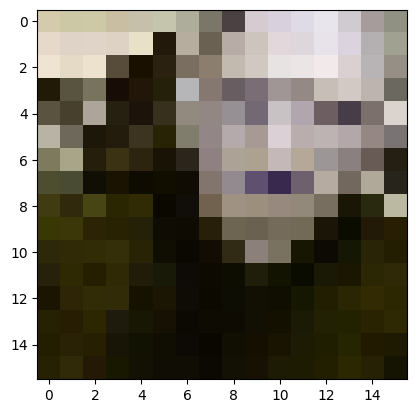

In [50]:
plt.imshow(output_img_array[0].reshape(SIZE,SIZE,3))

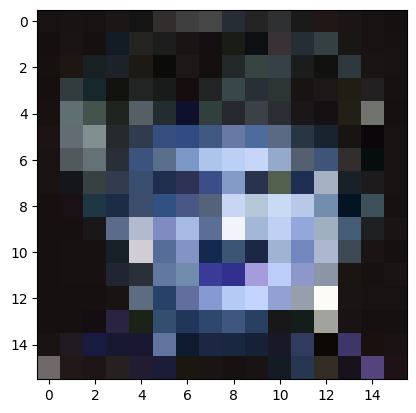

In [51]:
plt.imshow(test_img_array.reshape(SIZE,SIZE,3))

1/1 [==============================] - 0s 253ms/step


2023-01-11 15:45:15.995653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


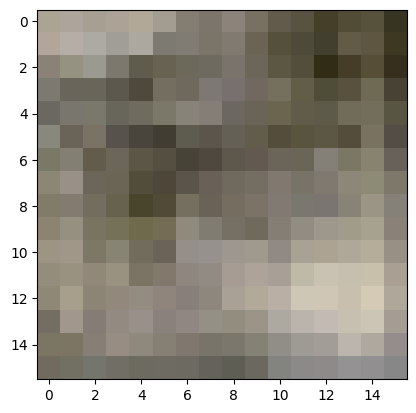

In [52]:
# now we are predicting the original harry picture, however the output should be voldemort
pred = model.predict(test_img_array)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))

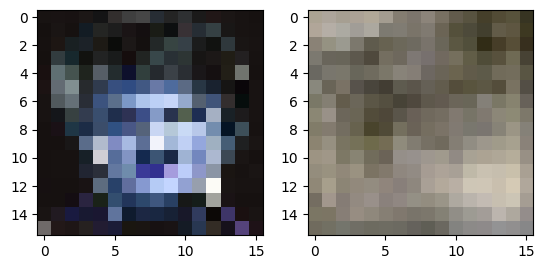

In [53]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(test_img_array[0].reshape(SIZE,SIZE, 3))
axes[1].imshow(pred[0].reshape(SIZE, SIZE, 3))
plt.show()

In [54]:
#save
model.save("domain-adapt_autoencoder_epochs."+str(epochs)+".model")

INFO:tensorflow:Assets written to: domain-adapt_autoencoder_epochs.20000.model/assets


INFO:tensorflow:Assets written to: domain-adapt_autoencoder_epochs.20000.model/assets


## Summary

By using the regular autoencoder we could successfully transform Yoda into many forms of augmented Michaelangelo. Would the current output be the ideal "mix" of all the augmented pictures? After all, I am happy that the autoencoder worked out, since this was my first time working with image data. It was therefore quite a pain to first of all understand how the pixels and arrays work at all. It would be much easier by knowing how to incorporate flatten layers for example to automatically transform the data.

Concerning the CNN, several approaches were used, which were overall really unsuccesful. Many of the fist approaches consisted of smaller Input layers and therefore the model could not learn anything. Using a higher amount of inputs really helped out the model.
Using 100.000 epochs was actually tried on one of the first approaches, however due to the low amount of input neurons the image was still just blurred and unidentifyable. When using train x on train x and therefore not applying a domain adoption, the output was somewhat visible after 5000 epochs.